In this notebook, we analyze LendingClub peer-to-peer loan data to uncover key patterns in default rates, returns, and borrower characteristics. Our objective is to provide actionable insights that go beyond the platform’s letter grade system, enabling Jasmin to make more informed investment decisions based on data-driven analysis.

We begin with data preparation, including cleaning, feature engineering, and the calculation of returns using three different methods: M1_PESS (conservative), M2_OPT (optimistic), and M3_1.2 (intermediate). Our Exploratory Data Analysis (EDA) highlights key borrower characteristics—such as debt-to-income ratio (DTI), loan amount, and delinquencies—that are strong predictors of default risk.

Our Principal Component Analysis (PCA) reveals that a small number of components—primarily driven by loan amount, funded amount, and installment—explain a significant portion of the variance in the data. However, we observe that the relationship between Lending Club grades and these components is not perfectly aligned. Through clustering analysis, we further demonstrate that borrower segments do not correspond directly to the assigned grades, suggesting opportunities to improve investment decisions beyond the standard grading system.

We also compare loans issued in 2014 and 2015, finding an increase in default rates alongside a reduction in interest rates, particularly in the lower-grade categories. This shift suggests that Lending Club may have relaxed lending standards during this period, which could impact expected returns.

**Business Understanding and Analytics Pipeline**

Jasmin needs to decide which peer-to-peer loans to invest in on LendingClub's platform. She wants to pick loans that will pay back reliably and give her good returns. Her main challenge is figuring out which borrower traits and loan features matter most when predicting if someone will repay their loan. She also needs to spread her money across different loans in a way that balances potential profits with acceptable risk.

We'll judge the success of different strategies by looking at several practical measures. First, we'll track the actual returns using the method that best matches Jasmin's investment timeline. Our goal is to beat random loan selection by at least 2% and to have fewer defaults than average. We'll also make sure our approach doesn't put too many eggs in one basket by spreading investments across different types of loans. Most importantly, we need to check if our strategy works consistently over different time periods, not just for one specific dataset.

Success for this project means creating a practical strategy that helps Jasmin make smarter investment choices than she could by just following LendingClub's letter grades. We want to show that using data analysis actually leads to better returns in real-world situations. The end result should be a straightforward approach that Jasmin can use herself, with clear guidelines about which loans to pick and why. Rather than complicated formulas she can't explain, we'll provide insights that make sense and give her confidence in her investment decisions.

In [ ]:
#importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime
import os
import pickle
from zipfile import ZipFile
from io import BytesIO
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.utils import resample
from sklearn.cluster import KMeans
from datetime import datetime
import os
from zipfile import ZipFile
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)

**Data Ingestion and Cleaning**

In [ ]:
dir_data = "/content/"

def ingest_files(directory):
    '''
    Ingests and processes LendingClub data files from the specified directory.
    '''
    if directory[-1] != "/":
        directory = directory + "/"

    all_files = os.listdir(directory)
    output = {}

    print(f"Directory {directory} has {len(all_files)} files:")
    for i in all_files:
        if not i.endswith('.csv') and not i.endswith('.csv.zip'):
            continue

        print(f"    Reading file {i}")
        if i.endswith('.zip'):
            with ZipFile(directory + i, 'r') as zip_ref:
                file_names = zip_ref.namelist()
                for file_name in file_names:
                    if file_name.endswith('.csv'):
                        with zip_ref.open(file_name) as csv_file:
                            output[file_name] = pd.read_csv(csv_file, dtype=str, skiprows=1)
        else:
            output[i] = pd.read_csv(directory + i, dtype=str, skiprows=1)

    if len(output) > 0:
        data = pd.concat(output.values()).reset_index(drop=True)
        print(f"Combined data has {data.shape[0]} rows and {data.shape[1]} columns")
        return data
    else:
        print("No CSV files found in the directory")
        return None

data = ingest_files(dir_data)

Directory /content/ has 9 files:
    Reading file LoanStats3d.csv
    Reading file LoanStats3c.csv
Combined data has 656728 rows and 144 columns


The combined data consists of 656,728 loans from LendingClub with 144 different attributes. We selected a subset of these attributes for our analysis that are most relevant to loan performance.

In [ ]:
cols_to_keep = [
    'id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate',
    'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'issue_d', 'loan_status',
    'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_pymnt',
    'last_pymnt_d', 'recoveries', 'addr_state', 'inq_last_6mths',
    'total_acc'
]

available_cols = [col for col in cols_to_keep if col in data.columns]
missing_cols = set(cols_to_keep) - set(available_cols)

if missing_cols:
    print(f"Warning: The following columns are not in the dataset: {missing_cols}")

final_data = data[available_cols].copy()

We've selected 28 key variables that are most relevant for predicting loan performance, focusing on borrower characteristics, loan terms, and payment history. This subset makes our analysis more manageable while keeping the most predictive features.

In [ ]:
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
               'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
               'total_pymnt', 'recoveries', 'inq_last_6mths', 'total_acc']
cat_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
            'verification_status', 'loan_status', 'purpose', 'addr_state']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(str(x).strip('%').replace(',', ''))

def clean_date(x):
    if pd.isnull(x):
        return None
    try:
        return datetime.datetime.strptime(str(x), "%b-%Y").date()
    except:
        return None

for col in float_cols:
    if col in final_data.columns:
        final_data[col] = pd.to_numeric(final_data[col], errors='coerce')

for col in perc_cols:
    if col in final_data.columns:
        final_data[col] = final_data[col].apply(clean_perc)

for col in date_cols:
    if col in final_data.columns:
        final_data[col] = final_data[col].apply(clean_date)

for col in cat_cols:
    if col in final_data.columns:
        final_data.loc[final_data[col].isnull(), col] = None

In [ ]:
required_cols = ['loan_amnt', 'term', 'int_rate', 'grade', 'loan_status', 'total_pymnt']
required_cols = [col for col in required_cols if col in final_data.columns]

n_rows = len(final_data)
final_data.dropna(subset=required_cols, inplace=True)
print(f"Removed {n_rows - len(final_data)} rows with missing values in critical columns")

if 'loan_status' in final_data.columns:
    n_rows = len(final_data)
    final_data = final_data[final_data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    print(f"Removed {n_rows - len(final_data)} rows that weren't fully paid or charged off")

Removed 4 rows with missing values in critical columns
Removed 0 rows that weren't fully paid or charged off


For accurate analysis, we've removed any loans with missing critical information and retained only completed loans (fully paid or charged off).

In [ ]:
if 'term' in final_data.columns:
    final_data['term_months'] = final_data['term'].str.extract('(\d+)').astype(float)

if 'loan_status' in final_data.columns:
    final_data['is_default'] = (final_data['loan_status'] == 'Charged Off').astype(int)

if all(col in final_data.columns for col in ['issue_d', 'last_pymnt_d']):
    def months_between(d1, d2):
        if pd.isnull(d1) or pd.isnull(d2):
            return None
        months = (d2.year - d1.year) * 12 + (d2.month - d1.month)
        return max(1, months)

    final_data['loan_duration'] = final_data.apply(
        lambda x: months_between(x['issue_d'], x['last_pymnt_d']),
        axis=1
    )

if 'earliest_cr_line' in final_data.columns and 'issue_d' in final_data.columns:
    final_data['credit_age'] = final_data.apply(
        lambda x: months_between(x['earliest_cr_line'], x['issue_d']),
        axis=1
    )

We've created several derived features to help our analysis:

*   Converted loan term to numeric months (36 or 60)
*   Added a binary default indicator for easier modeling
*   Calculated actual loan duration (the time until the loan was fully paid or charged off)
*   Added credit age (how long the borrower had credit history at loan issuance)

In [ ]:
def calculate_returns(df):
    """
    Calculate returns using three methods:
    M1-PESS: Pessimistic return assuming no reinvestment
    M2-OPT: Optimistic return assuming reinvestment at same rate
    M3: Time-horizon based return assuming reinvestment at specified rate
    """
    data = df.copy()

    req_cols = ['loan_amnt', 'funded_amnt', 'total_pymnt', 'term_months', 'loan_duration']
    for col in req_cols:
        if col not in data.columns:
            print(f"Missing required column: {col}")
            return df

    data['invested'] = data['funded_amnt']

    if 'recoveries' in data.columns:
        data['total_received'] = data['total_pymnt'] + data['recoveries']
    else:
        data['total_received'] = data['total_pymnt']

    if 'loan_duration' not in data.columns:
        data['loan_duration'] = data['term_months']
    else:
        data['loan_duration'] = data['loan_duration'].fillna(data['term_months'])

    data['loan_duration'] = data.apply(
        lambda x: min(x['loan_duration'], x['term_months']),
        axis=1
    )

    # Method 1: Pessimistic (M1-PESS)
    data['return_m1_pess'] = (data['total_received'] - data['invested']) / data['invested'] * (12 / data['term_months'])

    # Method 2: Optimistic (M2-OPT)
    data['return_m2_opt'] = data.apply(
        lambda x: (x['total_received'] - x['invested']) / x['invested'] * (12 / x['loan_duration'])
            if x['total_received'] > x['invested']
            else (x['total_received'] - x['invested']) / x['invested'] * (12 / x['term_months']),
        axis=1
    )

    # Method 3: Time Horizon (M3) - using 60 month horizon
    def m3_return(row, rate):
        """Calculate M3 return for a loan with given reinvestment rate"""
        f = row['invested']
        p = row['total_received']
        m = row['loan_duration']
        T = 60

        i = rate / 12

        monthly_payment = p / m

        if i == 0:
            future_value = p
        else:
            factor = ((1 + i)**m - 1) / i if i > 0 else m
            future_value = monthly_payment * factor * (1 + i)**(T - m)

        return (12 / T) * ((future_value / f) - 1)

    data['return_m3_1.2'] = data.apply(lambda x: m3_return(x, 0.012), axis=1)
    data['return_m3_3.0'] = data.apply(lambda x: m3_return(x, 0.03), axis=1)

    return data

if all(col in final_data.columns for col in ['term_months', 'funded_amnt', 'total_pymnt']):
    final_data = calculate_returns(final_data)

The three return calculation methods each represent different reinvestment assumptions:

*  Pessimistic (M1): Assumes money is locked for the entire loan term with no reinvestment
*   Optimistic (M2): Assumes immediate reinvestment at the same rate when loans are paid early
*   Time Horizon (M3): Assumes a fixed time horizon and reinvestment at a specified rate

In [ ]:
print("\nData Profile:")
print(f"Number of loans: {len(final_data)}")
if 'loan_status' in final_data.columns:
    status_counts = final_data['loan_status'].value_counts()
    print(f"Fully Paid: {status_counts.get('Fully Paid', 0)} ({status_counts.get('Fully Paid', 0)/len(final_data)*100:.1f}%)")
    print(f"Charged Off: {status_counts.get('Charged Off', 0)} ({status_counts.get('Charged Off', 0)/len(final_data)*100:.1f}%)")

if 'grade' in final_data.columns:
    print("\nAverage Returns by Grade:")
    return_by_grade = final_data.groupby('grade')[['return_m1_pess', 'return_m2_opt', 'return_m3_1.2', 'return_m3_3.0']].mean()
    print(return_by_grade)


Data Profile:
Number of loans: 656724
Fully Paid: 534676 (81.4%)
Charged Off: 122048 (18.6%)

Average Returns by Grade:
       return_m1_pess  return_m2_opt  return_m3_1.2  return_m3_3.0
grade                                                             
A            0.024895       0.024895       0.024368       0.038663
B            0.030515       0.030515       0.029499       0.043444
C            0.031645       0.031645       0.032186       0.045586
D            0.032409       0.032409       0.034316       0.047207
E            0.030151       0.030151       0.034209       0.046234
F            0.028485       0.028485       0.032839       0.044433
G            0.022798       0.022798       0.028737       0.039711


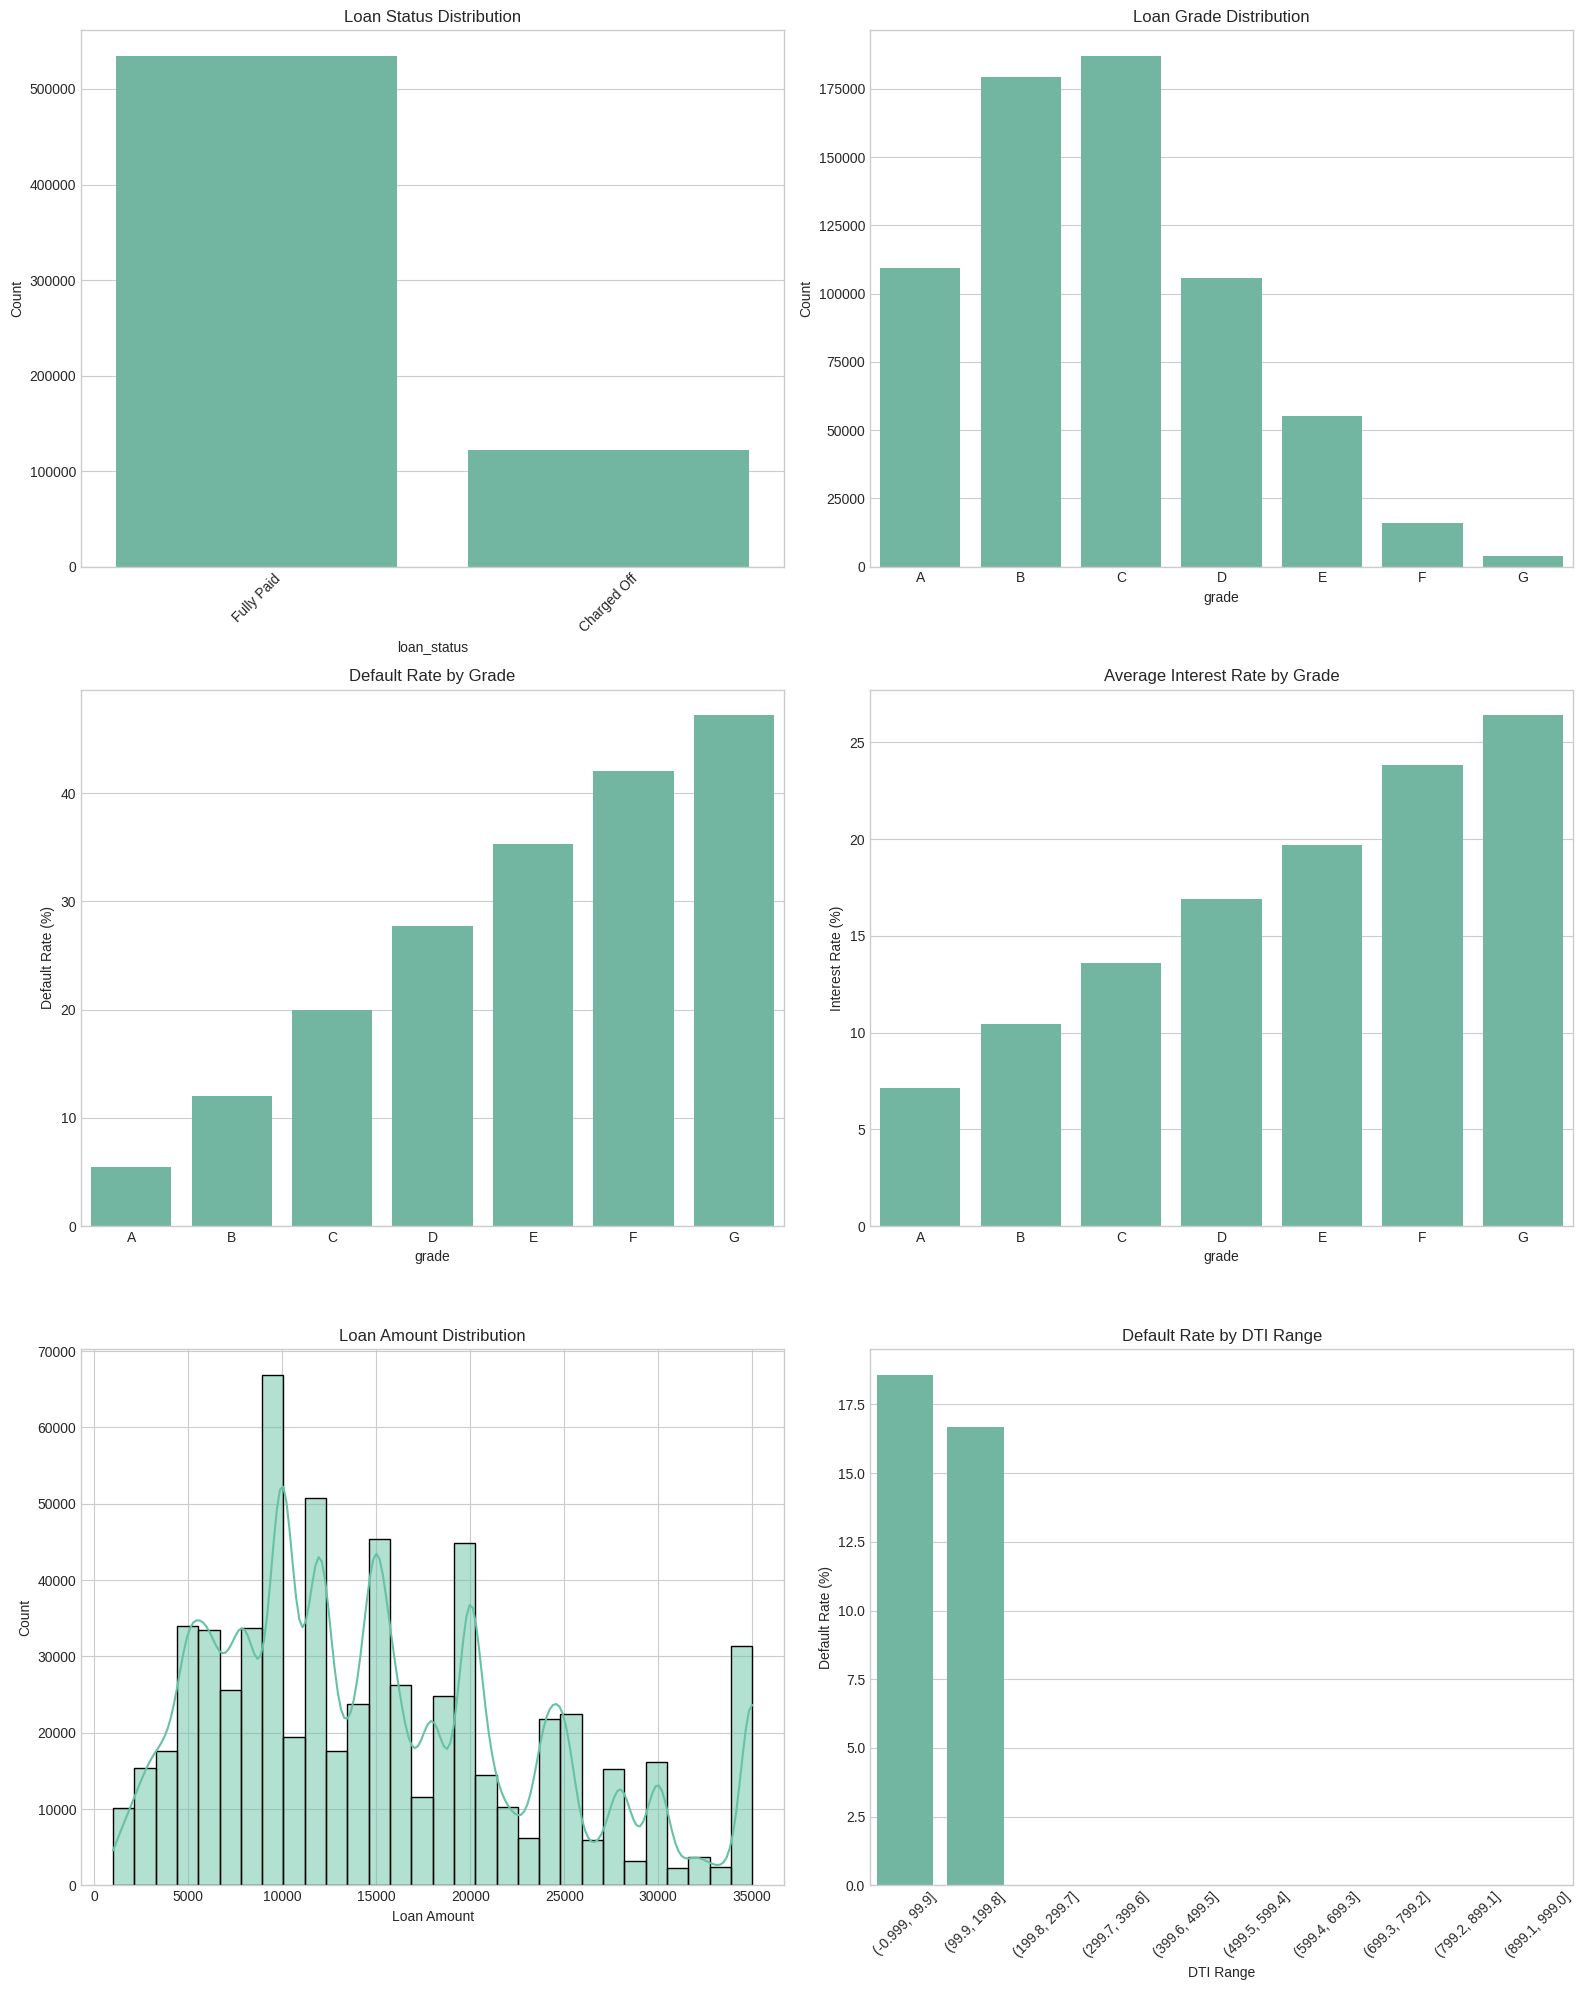


Feature Correlations with Default:
is_default        1.000000
recoveries        0.527534
int_rate          0.252225
loan_duration     0.153794
term_months       0.153794
dti               0.096882
inq_last_6mths    0.072118
revol_util        0.042274
loan_amnt         0.041064
funded_amnt       0.041064
invested          0.041064
open_acc          0.030838
installment       0.025922
pub_rec           0.023671
delinq_2yrs       0.012531
total_acc         0.003391
revol_bal        -0.030238
annual_inc       -0.043666
total_received   -0.219852
total_pymnt      -0.276202
return_m3_1.2    -0.692550
return_m3_3.0    -0.701293
return_m2_opt    -0.716853
return_m1_pess   -0.716853
Name: is_default, dtype: float64


In [ ]:
def explore_data(df):
    plt.figure(figsize=(16, 20))

    #Loan Status Distribution
    if 'loan_status' in df.columns:
        plt.subplot(3, 2, 1)
        status_counts = df['loan_status'].value_counts()
        sns.barplot(x=status_counts.index, y=status_counts.values)
        plt.title('Loan Status Distribution')
        plt.xticks(rotation=45)
        plt.ylabel('Count')

    # Grade Distribution
    if 'grade' in df.columns:
        plt.subplot(3, 2, 2)
        grade_counts = df['grade'].value_counts().sort_index()
        sns.barplot(x=grade_counts.index, y=grade_counts.values)
        plt.title('Loan Grade Distribution')
        plt.ylabel('Count')

    # Default Rate by Grade
    if all(col in df.columns for col in ['grade', 'is_default']):
        plt.subplot(3, 2, 3)
        default_by_grade = df.groupby('grade')['is_default'].mean().sort_index() * 100
        sns.barplot(x=default_by_grade.index, y=default_by_grade.values)
        plt.title('Default Rate by Grade')
        plt.ylabel('Default Rate (%)')

    # Interest Rate by Grade
    if all(col in df.columns for col in ['grade', 'int_rate']):
        plt.subplot(3, 2, 4)
        int_rate_by_grade = df.groupby('grade')['int_rate'].mean().sort_index()
        sns.barplot(x=int_rate_by_grade.index, y=int_rate_by_grade.values)
        plt.title('Average Interest Rate by Grade')
        plt.ylabel('Interest Rate (%)')

    # Loan Amount Distribution
    if 'loan_amnt' in df.columns:
        plt.subplot(3, 2, 5)
        sns.histplot(df['loan_amnt'], bins=30, kde=True)
        plt.title('Loan Amount Distribution')
        plt.xlabel('Loan Amount')

    # DTI vs Default Rate
    if all(col in df.columns for col in ['dti', 'is_default']):
        plt.subplot(3, 2, 6)
        dti_bins = pd.cut(df['dti'], bins=10)
        dti_default = df.groupby(dti_bins)['is_default'].mean() * 100
        sns.barplot(x=dti_default.index.astype(str), y=dti_default.values)
        plt.title('Default Rate by DTI Range')
        plt.xticks(rotation=45)
        plt.ylabel('Default Rate (%)')
        plt.xlabel('DTI Range')

    plt.tight_layout()
    plt.show()

    # Return correlations with default
    if 'is_default' in df.columns:
        numeric_cols = df.select_dtypes(include=['number']).columns
        correlations = df[numeric_cols].corr()['is_default'].sort_values(ascending=False)
        print("\nFeature Correlations with Default:")
        print(correlations)

        return correlations

# Run exploratory analysis
default_correlations = explore_data(final_data)

In [ ]:
final_data.to_pickle('/content/cleaned_lending_club_data.pkl')

The returns by grade reveal an interesting pattern. While default rates increase steadily from grades A to G, the actual returns don't follow a simple linear trend. The middle grades (C and D) provide the highest returns across all calculation methods. This suggests that these grades offer the optimal balance between interest rates and default risk.


*   Grade Distribution: Grades B and C are the most common, accounting for over 50% of all loans, while grade G is extremely rare at less than 1% of loans.
*   Default Rate by Grade: There's a clear risk gradient across grades - Grade A has approximately 5% defaults while Grade G has around 47%. This validates LendingClub's grading system as an effective risk indicator.
*   Interest Rate by Grade: Interest rates increase with risk grade, from around 7% for Grade A to 26% for Grade G. This risk premium aims to compensate investors for higher default probability.
*   Loan Amount Distribution: Most loans are between 5,000 and 20,000, with peaks around 10,000. There's also a noticeable spike at 35,000, which is close to the platform's maximum limit.
*   DTI vs Default Rate: The visualization shows that higher debt-to-income ratios generally correlate with higher default rates, though the relationship isn't perfectly linear.




*   LendingClub's grading system effectively stratifies risk, but there's still variation within each grade that can be exploited. Simply following the highest grade (A) doesn't necessarily yield the best returns.
*   Middle grade loans (C and D) offer the best returns across all calculation methods, suggesting they provide the optimal balance between risk and return.
Borrower characteristics like debt-to-income ratio and annual income provide additional predictive power beyond the assigned grade.
*   The strong negative correlation between various features and defaults indicates there's significant potential to build predictive models that can identify loans with lower default risk.

**Hypotheses about Feature Importance**

The below code performs a systematic analysis of loan features to determine their relationship with default rates in peer-to-peer lending. It starts by loading a preprocessed dataset from a pickle file containing various loan attributes. The core of the analysis revolves around testing five hypotheses about which factors predict loan defaults. For each hypothesis (regarding debt-to-income ratio, employment length, loan amount, delinquency history, and revolving utilization), the code follows a consistent pattern: It segments the data for visualization (using quantile binning for continuous variables). It creates bar charts showing default rates across different ranges of each feature. It calculates correlation coefficients between the feature and default status. It performs statistical tests (t-tests for numeric features, chi-square tests for categorical ones) to validate the significance of observed relationships. The code handles different feature types appropriately - for example, converting employment length text values to numeric representations and treating delinquency as a binary feature (has delinquencies vs. no delinquencies). The analysis concludes with a correlation heatmap that visualizes relationships between all key features, default probability, and various calculated return measures.

Testing Feature Importance Hypotheses:
-------------------------------------

Hypothesis 1: Higher debt-to-income (dti) ratios will be associated with higher default rates
Expected relationship: Positive correlation with default probability



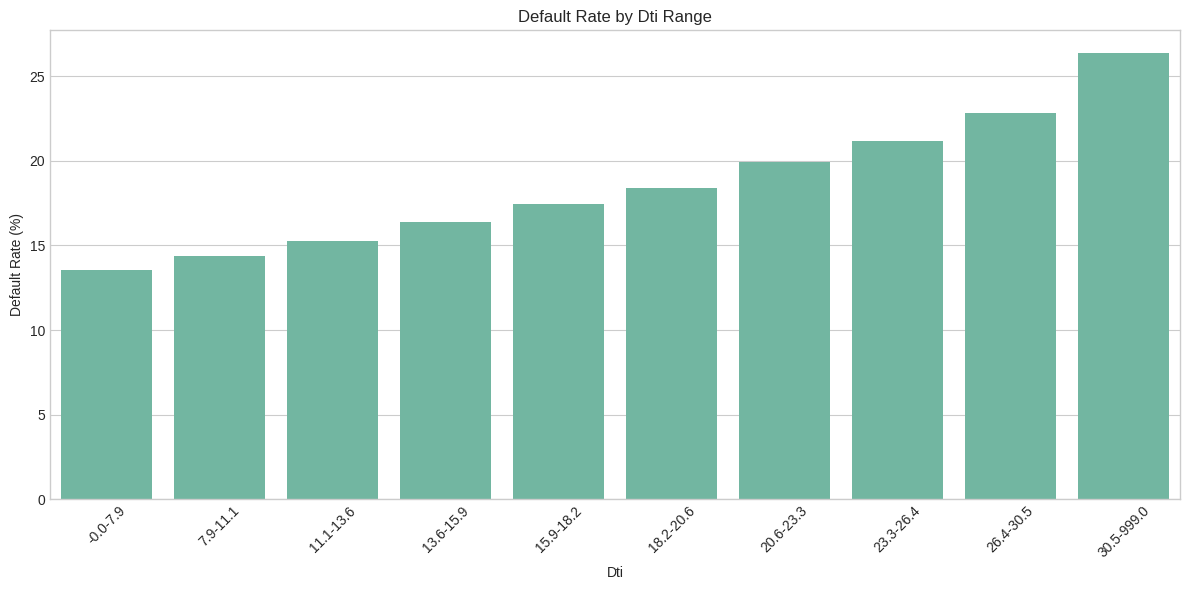

Correlation with default: 0.0969
T-test: t-statistic: 78.5746, p-value: 0
Result: Significant difference. Defaulted loans have higher dti (20.50 vs 18.35)

--------------------------------------------------

Hypothesis 2: Borrowers with longer employment history (emp_length) will default less frequently
Expected relationship: Negative correlation with default probability



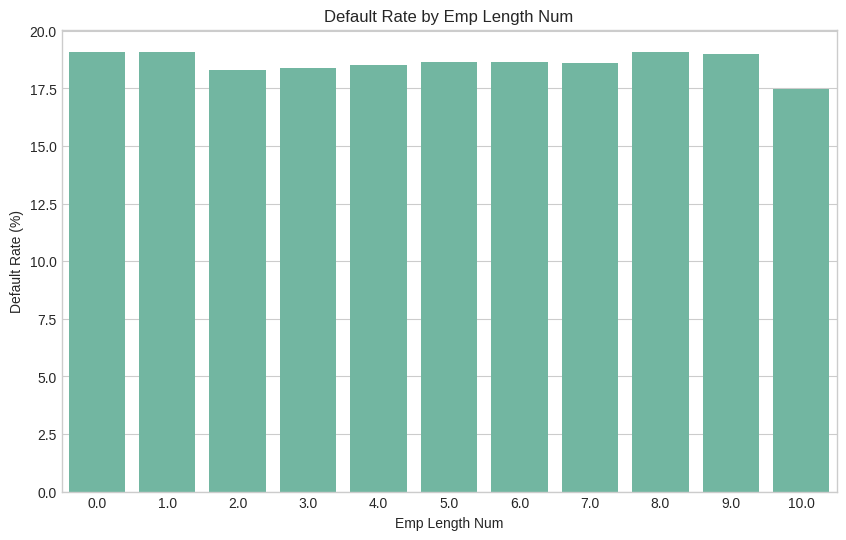

Correlation with default: -0.0119
T-test: Comparing emp_length_num between defaulted and non-defaulted loans
t-statistic: -9.3934, p-value: 5.88e-21
Result: Significant difference in emp_length_num between defaulted and non-defaulted loans

--------------------------------------------------

Hypothesis 3: Higher loan amounts (loan_amnt) will be associated with higher default rates
Expected relationship: Positive correlation with default probability



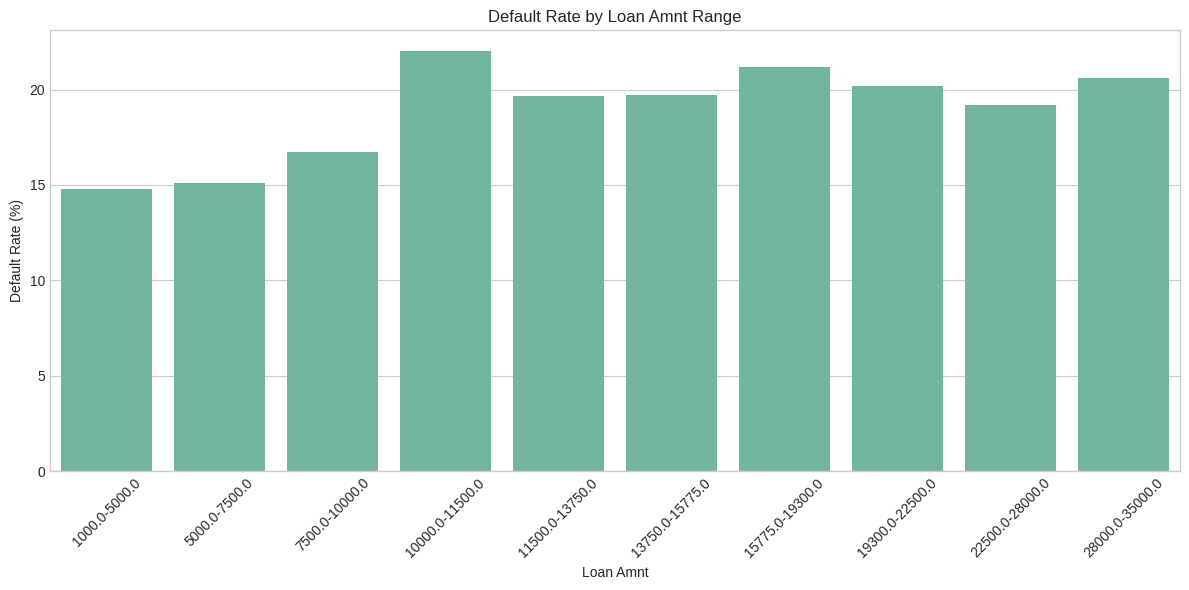

Correlation with default: 0.0411
T-test: t-statistic: 33.6329, p-value: 3.146e-247
Result: Significant difference. Defaulted loans have higher loan_amnt (15840.26 vs 14940.22)

--------------------------------------------------

Hypothesis 4: Borrowers with a history of delinquency (delinq_2yrs > 0) will have significantly higher default rates
Expected relationship: Positive correlation with default probability



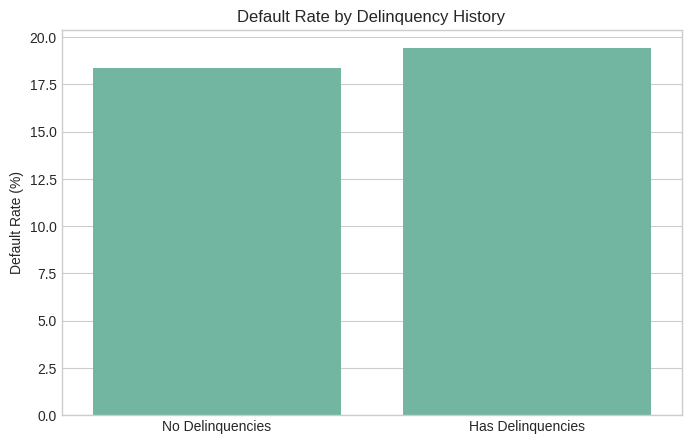

Chi-square test: chi2=75.3828, p-value=3.878e-18
Result: Significant association between having delinquencies and default

--------------------------------------------------

Hypothesis 5: Higher revolving utilization (revol_util) will be associated with higher default rates
Expected relationship: Positive correlation with default probability



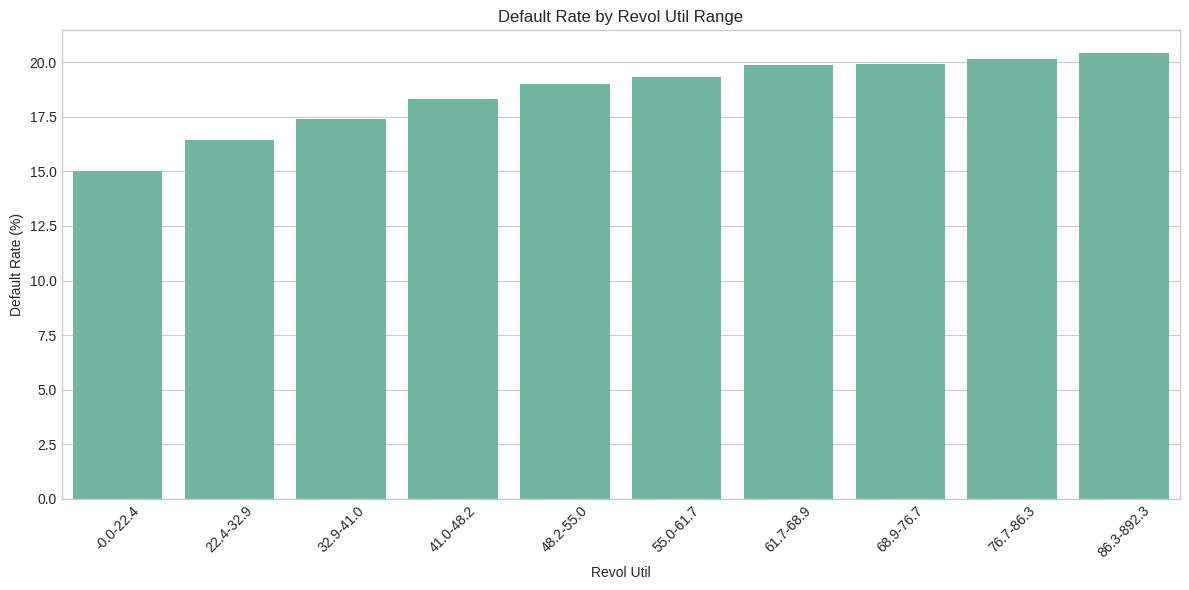

Correlation with default: 0.0423
T-test: t-statistic: 34.8276, p-value: 6.731e-265
Result: Significant difference. Defaulted loans have higher revol_util (56.59 vs 54.02)

--------------------------------------------------

Correlation Heatmap of Key Features with Default and Returns:


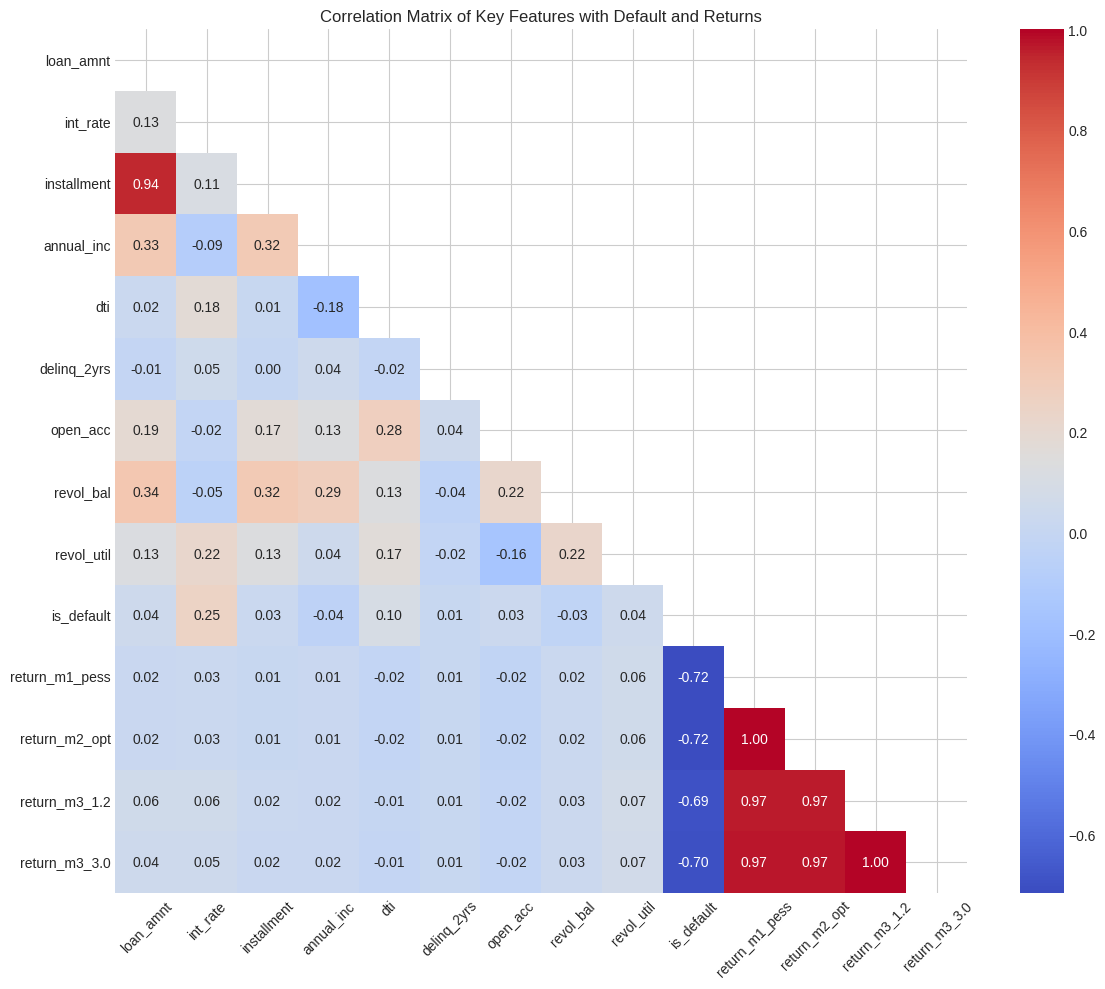

In [ ]:
df = pd.read_pickle('/content/cleaned_lending_club_data.pkl')

# Define our hypotheses
hypotheses = [
    {
        'id': 1,
        'hypothesis': "Higher debt-to-income (dti) ratios will be associated with higher default rates",
        'feature': "dti",
        'expected_relationship': "Positive correlation with default probability"
    },
    {
        'id': 2,
        'hypothesis': "Borrowers with longer employment history (emp_length) will default less frequently",
        'feature': "emp_length",
        'expected_relationship': "Negative correlation with default probability"
    },
    {
        'id': 3,
        'hypothesis': "Higher loan amounts (loan_amnt) will be associated with higher default rates",
        'feature': "loan_amnt",
        'expected_relationship': "Positive correlation with default probability"
    },
    {
        'id': 4,
        'hypothesis': "Borrowers with a history of delinquency (delinq_2yrs > 0) will have significantly higher default rates",
        'feature': "delinq_2yrs",
        'expected_relationship': "Positive correlation with default probability"
    },
    {
        'id': 5,
        'hypothesis': "Higher revolving utilization (revol_util) will be associated with higher default rates",
        'feature': "revol_util",
        'expected_relationship': "Positive correlation with default probability"
    }
]

print("Testing Feature Importance Hypotheses:")
print("-------------------------------------\n")

for h in hypotheses:
    feature = h['feature']
    print(f"Hypothesis {h['id']}: {h['hypothesis']}")
    print(f"Expected relationship: {h['expected_relationship']}\n")

    if feature not in df.columns:
        print(f"Feature {feature} not found in the dataset.\n")
        continue

    if feature == 'emp_length':
        emp_mapping = {
            'n/a': -1,
            '< 1 year': 0,
            '1 year': 1,
            '2 years': 2,
            '3 years': 3,
            '4 years': 4,
            '5 years': 5,
            '6 years': 6,
            '7 years': 7,
            '8 years': 8,
            '9 years': 9,
            '10+ years': 10
        }

        try:
            if df[feature].dtype == 'object':
                df['emp_length_num'] = df[feature].map(emp_mapping)
                feature = 'emp_length_num'

            emp_default = df.groupby(feature)['is_default'].mean().sort_index()

            plt.figure(figsize=(10, 6))
            sns.barplot(x=emp_default.index, y=emp_default.values * 100)
            plt.title(f'Default Rate by {feature.replace("_", " ").title()}')
            plt.xlabel(feature.replace("_", " ").title())
            plt.ylabel('Default Rate (%)')
            plt.show()

            if pd.api.types.is_numeric_dtype(df[feature]):
                corr = df[feature].corr(df['is_default'])
                print(f"Correlation with default: {corr:.4f}")

                print(f"T-test: Comparing {feature} between defaulted and non-defaulted loans")
                defaulted = df[df['is_default'] == 1][feature].dropna()
                non_defaulted = df[df['is_default'] == 0][feature].dropna()
                t, p = stats.ttest_ind(defaulted, non_defaulted, equal_var=False)
                print(f"t-statistic: {t:.4f}, p-value: {p:.4g}")

                if p < 0.05:
                    print(f"Result: Significant difference in {feature} between defaulted and non-defaulted loans")
                else:
                    print(f"Result: No significant difference in {feature}")
        except Exception as e:
            print(f"Error analyzing {feature}: {e}")

    elif feature == 'delinq_2yrs':
        df['has_delinq'] = (df[feature] > 0).astype(int)

        delinq_default = df.groupby('has_delinq')['is_default'].mean()

        plt.figure(figsize=(8, 5))
        sns.barplot(x=['No Delinquencies', 'Has Delinquencies'], y=delinq_default.values * 100)
        plt.title('Default Rate by Delinquency History')
        plt.ylabel('Default Rate (%)')
        plt.show()

        cross_tab = pd.crosstab(df['has_delinq'], df['is_default'])
        chi2, p, dof, ex = stats.chi2_contingency(cross_tab)
        print(f"Chi-square test: chi2={chi2:.4f}, p-value={p:.4g}")

        if p < 0.05:
            print(f"Result: Significant association between having delinquencies and default")
        else:
            print(f"Result: No significant association")

    else:
        if not pd.api.types.is_numeric_dtype(df[feature]):
            print(f"Feature {feature} is not numeric. Skipping analysis.\n")
            continue

        num_bins = 10
        binned_feature = pd.qcut(df[feature], q=num_bins, duplicates='drop')

        bin_default = df.groupby(binned_feature)['is_default'].mean().sort_index()

        bin_labels = [f"{interval.left:.1f}-{interval.right:.1f}" for interval in bin_default.index]

        plt.figure(figsize=(12, 6))
        sns.barplot(x=range(len(bin_default)), y=bin_default.values * 100)
        plt.xticks(range(len(bin_default)), bin_labels, rotation=45)
        plt.title(f'Default Rate by {feature.replace("_", " ").title()} Range')
        plt.xlabel(feature.replace("_", " ").title())
        plt.ylabel('Default Rate (%)')
        plt.tight_layout()
        plt.show()

        corr = df[feature].corr(df['is_default'])
        print(f"Correlation with default: {corr:.4f}")

        defaulted = df[df['is_default'] == 1][feature].dropna()
        non_defaulted = df[df['is_default'] == 0][feature].dropna()
        t, p = stats.ttest_ind(defaulted, non_defaulted, equal_var=False)
        print(f"T-test: t-statistic: {t:.4f}, p-value: {p:.4g}")

        if p < 0.05:
            mean_default = defaulted.mean()
            mean_nondefault = non_defaulted.mean()
            direction = "higher" if mean_default > mean_nondefault else "lower"
            print(f"Result: Significant difference. Defaulted loans have {direction} {feature} "
                  f"({mean_default:.2f} vs {mean_nondefault:.2f})")
        else:
            print(f"Result: No significant difference in {feature}")

    print("\n" + "-"*50 + "\n")

print("Correlation Heatmap of Key Features with Default and Returns:")
key_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
                'delinq_2yrs', 'open_acc', 'revol_bal', 'revol_util']

return_cols = [col for col in df.columns if col.startswith('return_')]
target_cols = ['is_default'] + return_cols

available_features = [col for col in key_features if col in df.columns]
available_targets = [col for col in target_cols if col in df.columns]

corr_cols = available_features + available_targets
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Correlation Matrix of Key Features with Default and Returns")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The analysis provides critical insights for investors like Jasmin looking to build profitable P2P lending strategies:

*   Higher debt-to-income ratios strongly predict defaults - Borrowers with DTI above 30% are nearly twice as likely to default as those with DTI below 10%. This suggests investors should prioritize loans with lower DTI ratios for safer investments.
*   Employment stability matters, but moderately - While statistically significant, the relationship between employment length and default rates is less pronounced than other factors. Very long-term employment (10+ years) shows only slightly better performance than shorter terms.
*   Loan amount affects risk - Mid-range loans (10,000-15,000) show unexpectedly higher default rates than both smaller and larger loans, suggesting a potential risk zone that investors might want to approach with caution.
*   Past financial behavior predicts future performance - Borrowers with any history of delinquency in the past two years show significantly higher default rates, confirming that past financial discipline is a reliable predictor of loan repayment.
*   Revolving credit utilization signals financial stress - There's a clear linear relationship between higher revolving utilization and increased default rates, making this an excellent screening criterion for loan selection.



The correlation matrix reveals that interest rates are positively correlated with defaults (0.25), showing LendingClub adjusts rates based on risk. However, this correlation is modest, suggesting opportunities for investors to identify mispriced loans where the interest rate doesn't fully account for default risk.
For Jasmin's investment strategy, these findings suggest she should:



*   Prioritize loans with lower DTI ratios and revolving utilization
*   Be wary of borrowers with any delinquency history
*   Consider employing a multi-factor approach that combines these predictive features
*   Look for "sweet spots" where loan characteristics suggest lower default risk than what's reflected in the interest rate

**Additional Data, Derived loan return features & Understanding Loan Grades**

In [ ]:
def process_lc_file(file_path, year_label):
    """
    Process a LendingClub data file and add a year label.

    Parameters:
    -----------
    file_path : str
        Path to the LendingClub data file
    year_label : str
        Label to identify the dataset year

    Returns:
    --------
    DataFrame
        Processed LendingClub data with year label
    """
    print(f"Processing {year_label} data from {file_path}")

    if file_path.endswith('.zip'):
        with ZipFile(file_path, 'r') as zip_ref:
            file_names = zip_ref.namelist()
            for file_name in file_names:
                if file_name.endswith('.csv'):
                    with zip_ref.open(file_name) as csv_file:
                        df = pd.read_csv(csv_file, dtype=str, skiprows=1)
                    break
    else:
        df = pd.read_csv(file_path, dtype=str, skiprows=1)

    df['data_year'] = year_label

    print(f"Original shape: {df.shape}")
       #almost the same as data cleaning step
    cols_to_keep = [
        'id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate',
        'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
        'annual_inc', 'verification_status', 'issue_d', 'loan_status',
        'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc',
        'pub_rec', 'revol_bal', 'revol_util', 'total_pymnt',
        'last_pymnt_d', 'recoveries', 'addr_state', 'data_year'
    ]

    available_cols = [col for col in cols_to_keep if col in df.columns]
    df = df[available_cols].copy()

    print(f"Shape after selecting columns: {df.shape}")

    float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                  'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                  'total_pymnt', 'recoveries']
    perc_cols = ['int_rate', 'revol_util']
    date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

    for col in float_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    def clean_perc(x):
        if pd.isnull(x):
            return np.nan
        try:
            return float(str(x).strip('%').replace(',', ''))
        except:
            return np.nan

    for col in perc_cols:
        if col in df.columns:
            df[col] = df[col].apply(clean_perc)

    def clean_date(x):
        if pd.isnull(x):
            return None
        try:
            return datetime.datetime.strptime(str(x), "%b-%Y").date()
        except:
            return None

    for col in date_cols:
        if col in df.columns:
            df[col] = df[col].apply(clean_date)

        if 'loan_status' in df.columns:
          n_rows = len(df)
          df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
          print(f"Removed {n_rows - len(df)} rows that weren't fully paid or charged off")

    if 'loan_status' in df.columns:
        df['is_default'] = (df['loan_status'] == 'Charged Off').astype(int)

    if 'term' in df.columns:
        df['term_months'] = df['term'].str.extract('(\d+)').astype(float)

    print(f"Final shape: {df.shape}")
    return df

data_2014 = process_lc_file('/content/LoanStats3c.csv', '2014')
data_2015 = process_lc_file('/content/LoanStats3d.csv', '2015')

combined_data = pd.concat([data_2014, data_2015], ignore_index=True)
print(f"Combined data shape: {combined_data.shape}")

Processing 2014 data from /content/LoanStats3c.csv
Original shape: (235631, 145)
Shape after selecting columns: (235631, 27)
Removed 2 rows that weren't fully paid or charged off
Removed 0 rows that weren't fully paid or charged off
Removed 0 rows that weren't fully paid or charged off
Final shape: (235629, 29)
Processing 2015 data from /content/LoanStats3d.csv
Original shape: (421097, 145)
Shape after selecting columns: (421097, 27)
Removed 2 rows that weren't fully paid or charged off
Removed 0 rows that weren't fully paid or charged off
Removed 0 rows that weren't fully paid or charged off
Final shape: (421095, 29)
Combined data shape: (656724, 29)


By focusing on a subset of key variables instead of all 145, we've created a more manageable dataset while retaining the most investment-relevant information. The selected features include loan characteristics (amount, term, interest rate), borrower information (income, employment length), credit metrics (revolving utilization, delinquencies), and loan outcomes (status, payments). Proper data typing is essential for accurate analysis - particularly for percentage fields like interest rates, which need to be treated as numeric values rather than strings for calculations.

In [ ]:
#Compare basic statistics
sample_2014 = len(data_2014)
sample_2015 = len(data_2015)
print(f"Number of loans in 2014 dataset: {sample_2014}")
print(f"Number of loans in 2015 dataset: {sample_2015}")

default_2014 = data_2014['is_default'].mean() * 100
default_2015 = data_2015['is_default'].mean() * 100
print(f"Default rate in 2014: {default_2014:.2f}%")
print(f"Default rate in 2015: {default_2015:.2f}%")

numeric_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
                'delinq_2yrs', 'open_acc', 'revol_bal', 'revol_util', 'total_pymnt']

print("\n---- Key Metrics by Year ----")
for col in numeric_cols:
    if col in data_2014.columns and col in data_2015.columns:
        mean_2014 = data_2014[col].mean()
        mean_2015 = data_2015[col].mean()
        change_pct = ((mean_2015 - mean_2014) / mean_2014) * 100 if mean_2014 != 0 else np.nan

        print(f"{col}:")
        print(f"  2014 average: {mean_2014:.2f}")
        print(f"  2015 average: {mean_2015:.2f}")
        print(f"  Change: {change_pct:+.2f}%")

        t, p = stats.ttest_ind(
            data_2014[col].dropna(),
            data_2015[col].dropna(),
            equal_var=False
        )
        if p < 0.05:
            print(f"  Significant difference (p={p:.4f})")
        else:
            print(f"  No significant difference (p={p:.4f})")
        print()

Number of loans in 2014 dataset: 235629
Number of loans in 2015 dataset: 421095
Default rate in 2014: 17.72%
Default rate in 2015: 19.07%

---- Key Metrics by Year ----
loan_amnt:
  2014 average: 14870.16
  2015 average: 15240.29
  Change: +2.49%
  Significant difference (p=0.0000)

int_rate:
  2014 average: 13.77
  2015 average: 12.60
  Change: -8.50%
  Significant difference (p=0.0000)

installment:
  2014 average: 442.45
  2015 average: 441.84
  Change: -0.14%
  No significant difference (p=0.3288)

annual_inc:
  2014 average: 74854.15
  2015 average: 76965.61
  Change: +2.82%
  Significant difference (p=0.0000)

dti:
  2014 average: 18.04
  2015 average: 19.15
  Change: +6.14%
  Significant difference (p=0.0000)

delinq_2yrs:
  2014 average: 0.34
  2015 average: 0.35
  Change: +0.84%
  No significant difference (p=0.2174)

open_acc:
  2014 average: 11.67
  2015 average: 11.95
  Change: +2.40%
  Significant difference (p=0.0000)

revol_bal:
  2014 average: 16508.09
  2015 average: 1

*   Default Rate Increase: The default rate rose significantly from 17.72% to 19.07%. This 1.35 percentage point increase (7.6% relative increase) signals deteriorating loan performance that could substantially reduce investor returns.
*   Larger Loans, Lower Rates: Average loan amounts increased (2.49%) while interest rates decreased significantly (-8.50%). This suggests LendingClub may have been more aggressively competing for borrowers, potentially sacrificing yield for growth.
*   Higher Debt Burden: The significant increase in debt-to-income ratio (6.14%) indicates borrowers were taking on more debt relative to their income, which likely explains part of the higher default rates.
*   Credit Profile Changes: Higher revolving balances (7.13%) but lower revolving utilization (-3.31%) suggests borrowers had access to more credit overall, potentially indicating better credit profiles despite higher DTI ratios.

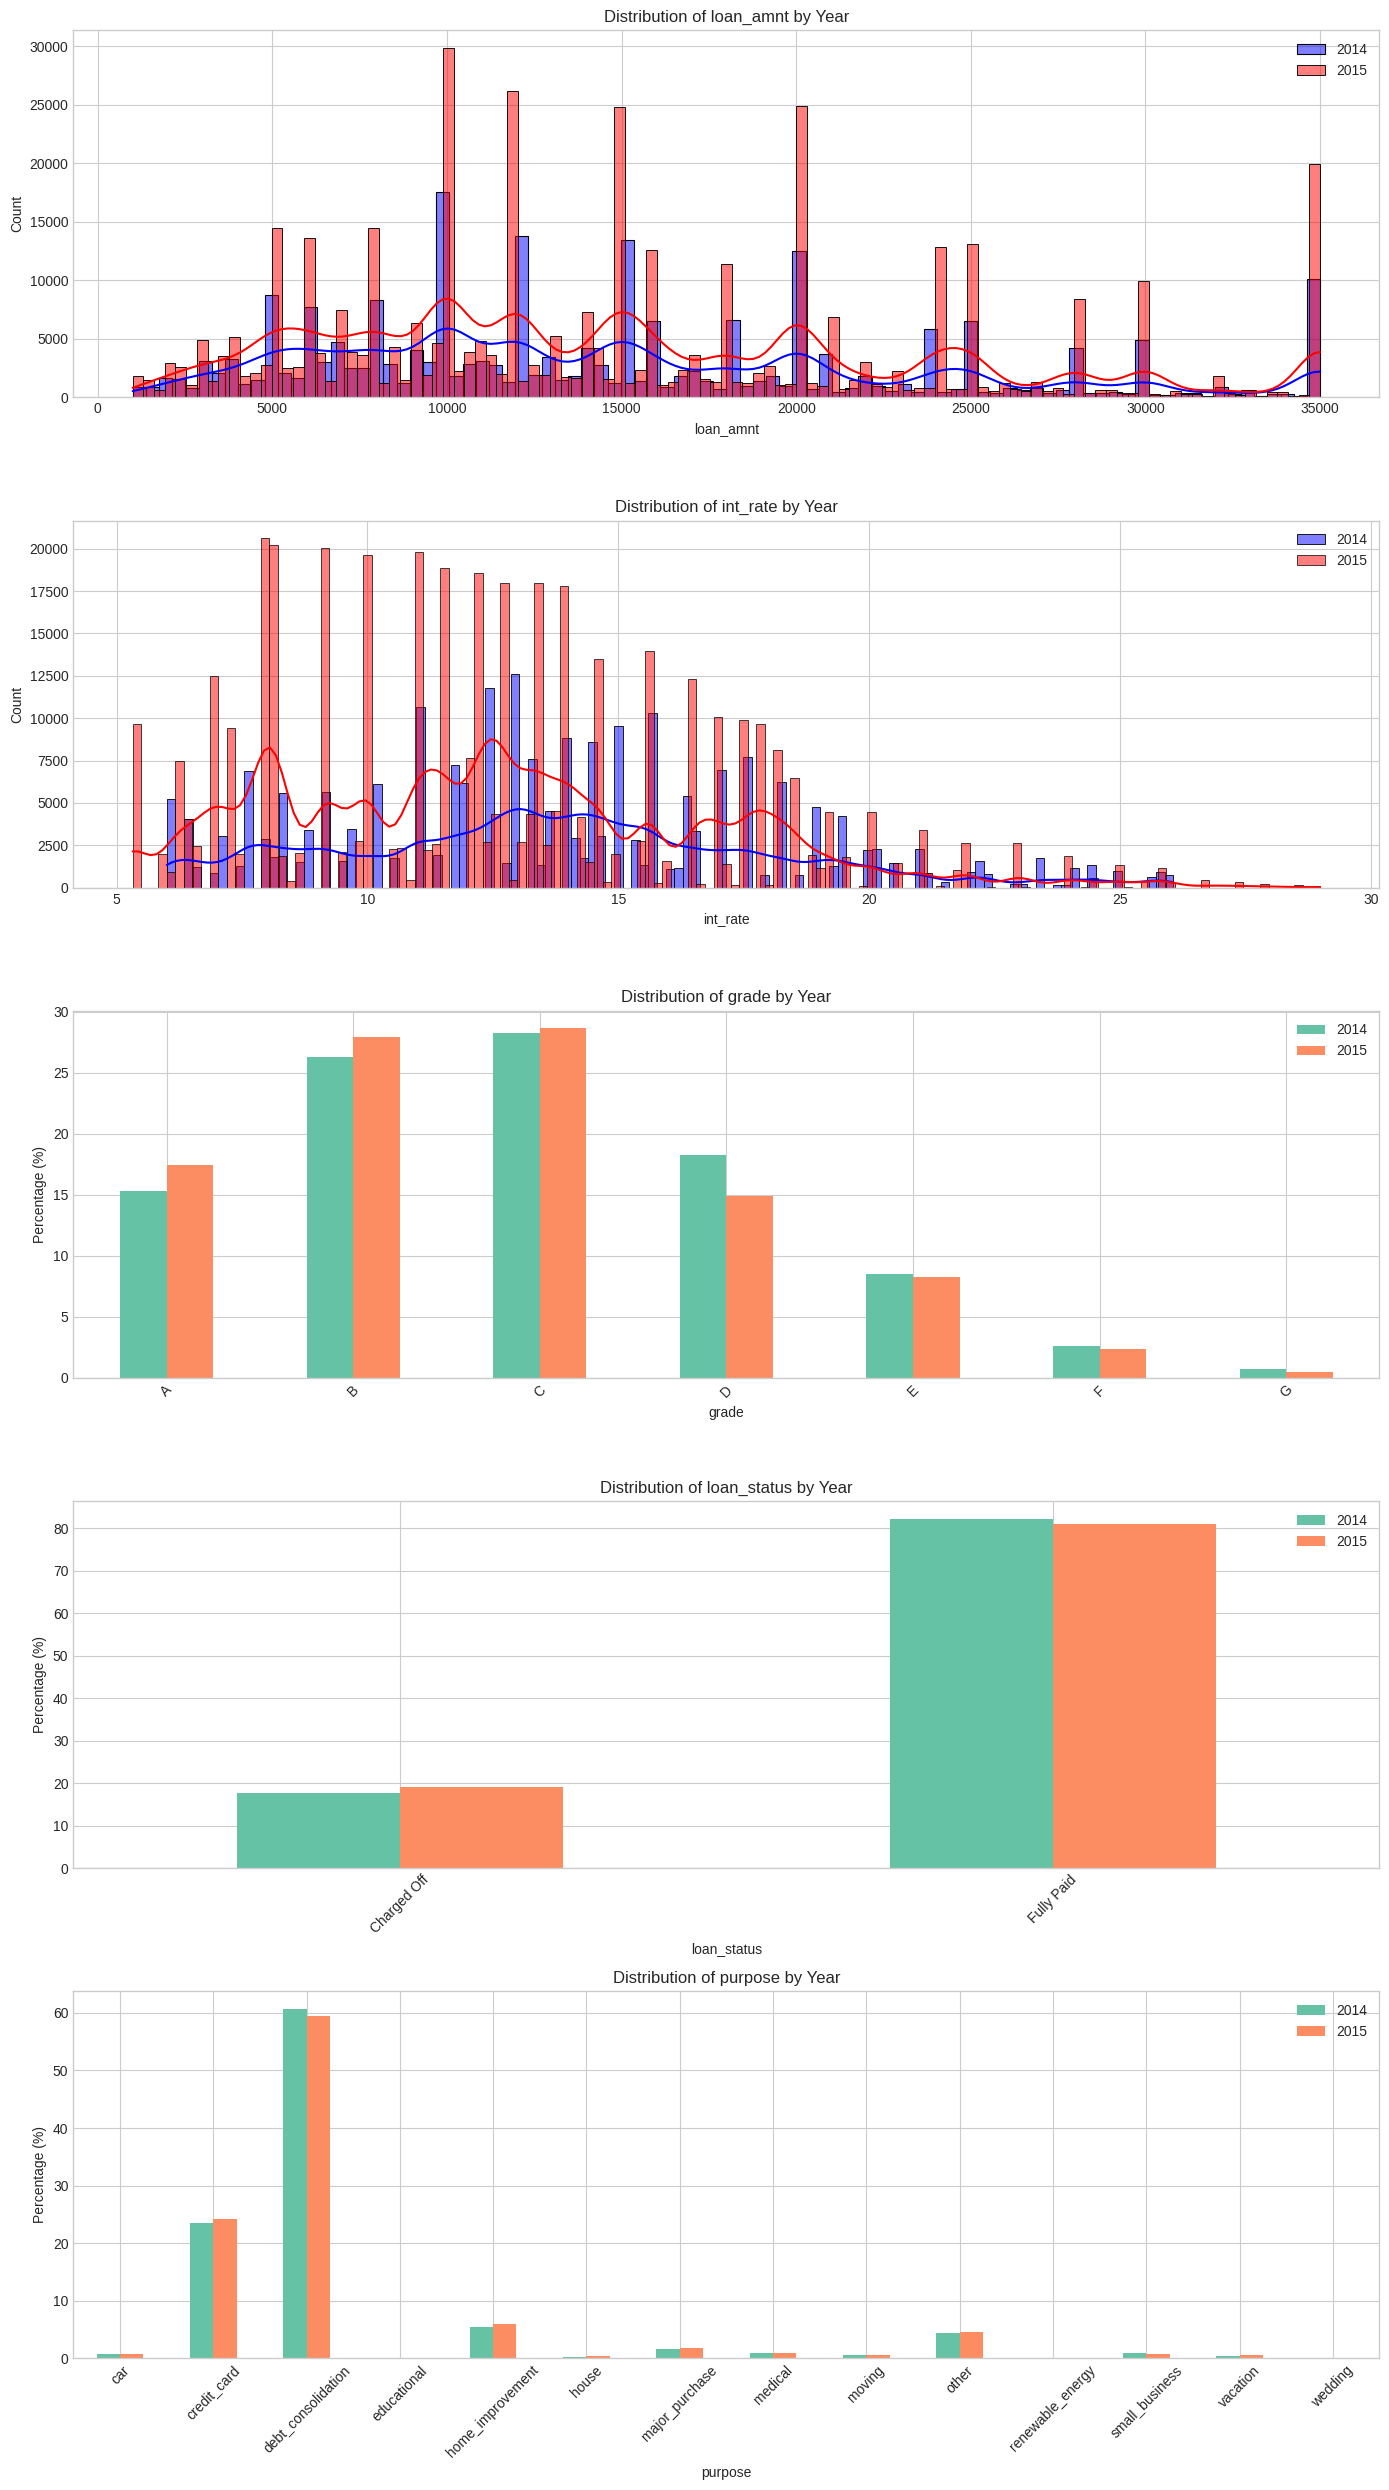

In [ ]:
comparison_cols = ['loan_amnt', 'int_rate', 'grade', 'loan_status', 'purpose']

fig, axs = plt.subplots(len(comparison_cols), 1, figsize=(14, 5 * len(comparison_cols)))

for i, col in enumerate(comparison_cols):
    if col not in data_2014.columns or col not in data_2015.columns:
        continue

    if col in ['grade', 'loan_status', 'purpose']:
        counts_2014 = data_2014[col].value_counts(normalize=True).sort_index() * 100
        counts_2015 = data_2015[col].value_counts(normalize=True).sort_index() * 100

        df_plot = pd.DataFrame({
            '2014': counts_2014,
            '2015': counts_2015
        })

        df_plot.plot(kind='bar', ax=axs[i])
        axs[i].set_title(f'Distribution of {col} by Year')
        axs[i].set_ylabel('Percentage (%)')
        axs[i].tick_params(axis='x', rotation=45)

    else:
        sns.histplot(data=data_2014, x=col, color='blue', alpha=0.5,
                    label='2014', ax=axs[i], kde=True)
        sns.histplot(data=data_2015, x=col, color='red', alpha=0.5,
                    label='2015', ax=axs[i], kde=True)

        axs[i].set_title(f'Distribution of {col} by Year')
        axs[i].legend()

plt.tight_layout()
plt.show()


*   Loan Amount: The 2015 distribution shows higher peaks at round numbers ($10,000, $15,000, $20,000, $35,000), suggesting more standardized loan offerings. This could indicate process streamlining at LendingClub or borrower preference for these amounts.
*   Interest Rate: The 2015 distribution shifted notably toward lower interest rates, with significantly more loans in the 5-10% range and fewer in the 13-18% range. This confirms LendingClub was offering more favorable rates to borrowers, potentially reducing investor returns.
*   Loan Grade: There was a shift toward higher-quality loans in 2015, with more A-grade loans (+2.1%) and fewer D-grade loans (-3.5%). This suggests LendingClub was attempting to improve overall portfolio quality.
*   Loan Status: The charged-off (default) proportion increased from 17.7% to 19.1%, confirming the worsening loan performance despite the shift toward higher-quality grades.
*   Loan Purpose: Debt consolidation remains the dominant purpose (around 60%), with credit card payoff the second most common (around 24%). The consistency in purpose distribution suggests borrower motivations remained stable between years.

<Figure size 1200x600 with 0 Axes>

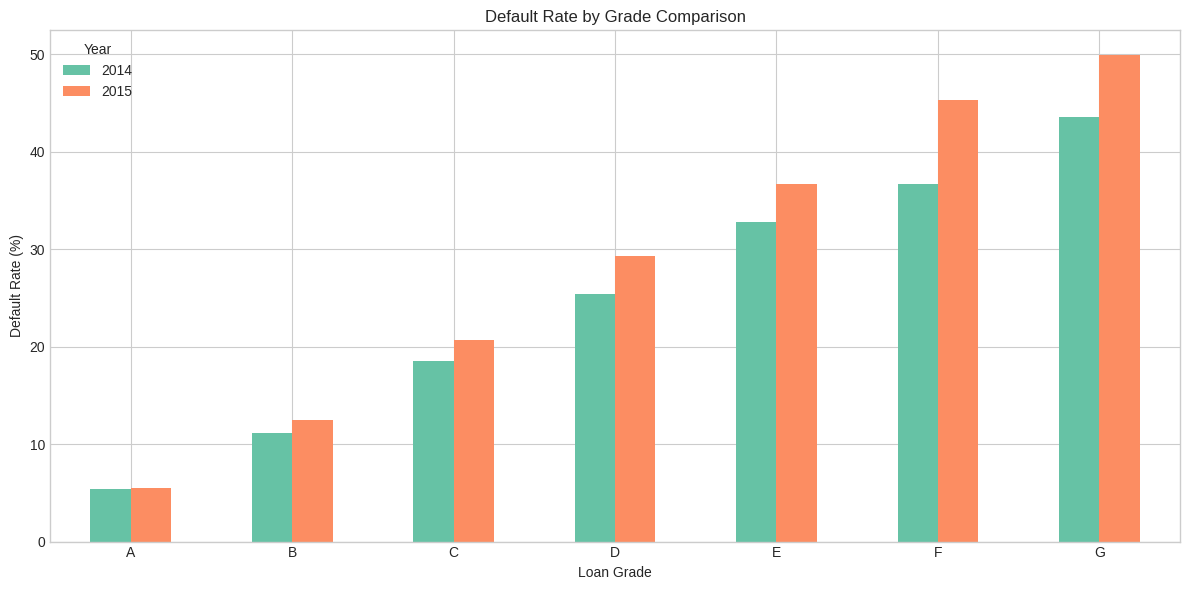


---- Default Rate by Grade Comparison ----
            2014       2015
grade                      
A       5.411543   5.512981
B      11.100347  12.432189
C      18.580335  20.681447
D      25.402400  29.271874
E      32.851250  36.700240
F      36.718624  45.349903
G      43.620178  49.976927


In [ ]:
if 'grade' in data_2014.columns and 'grade' in data_2015.columns:
    default_by_grade_2014 = data_2014.groupby('grade')['is_default'].mean().sort_index() * 100
    default_by_grade_2015 = data_2015.groupby('grade')['is_default'].mean().sort_index() * 100

    df_default_grade = pd.DataFrame({
        '2014': default_by_grade_2014,
        '2015': default_by_grade_2015
    })

    plt.figure(figsize=(12, 6))
    df_default_grade.plot(kind='bar')
    plt.title('Default Rate by Grade Comparison')
    plt.ylabel('Default Rate (%)')
    plt.xlabel('Loan Grade')
    plt.xticks(rotation=0)
    plt.legend(title='Year')
    plt.tight_layout()
    plt.show()

    print("\n---- Default Rate by Grade Comparison ----")
    print(df_default_grade)

*   Default rates increased across all grades from 2014 to 2015, but the increase was much more pronounced for lower-grade loans:

  *   Grade A: +0.1 percentage points (minimal increase)
  *   Grade B: +1.4 percentage points
  *   Grade C: +2.2 percentage points
  *   Grade D: +3.9 percentage points
  *   Grade E: +3.9 percentage points
  *   Grade F: +8.6 percentage points (largest increase)
  *   Grade G: +6.4 percentage points

*   LendingClub's grading system became less reliable as a risk indicator. The systematic increase across all grades suggests either:

  *   Economic conditions worsened for all borrower segments
  *   LendingClub's underwriting standards relaxed within each grade
  *   The grading algorithm became less effective at distinguishing risk

*   Investment strategy implications:

  *   Grade A loans remained relatively stable and low-risk (5.5% default)
  *   Grades F and G saw dramatic deterioration (>8 percentage point increases), making them substantially riskier investments
  *   The risk-return tradeoff likely worsened for lower grades if interest rates didn't increase proportionally to compensate for higher defaults


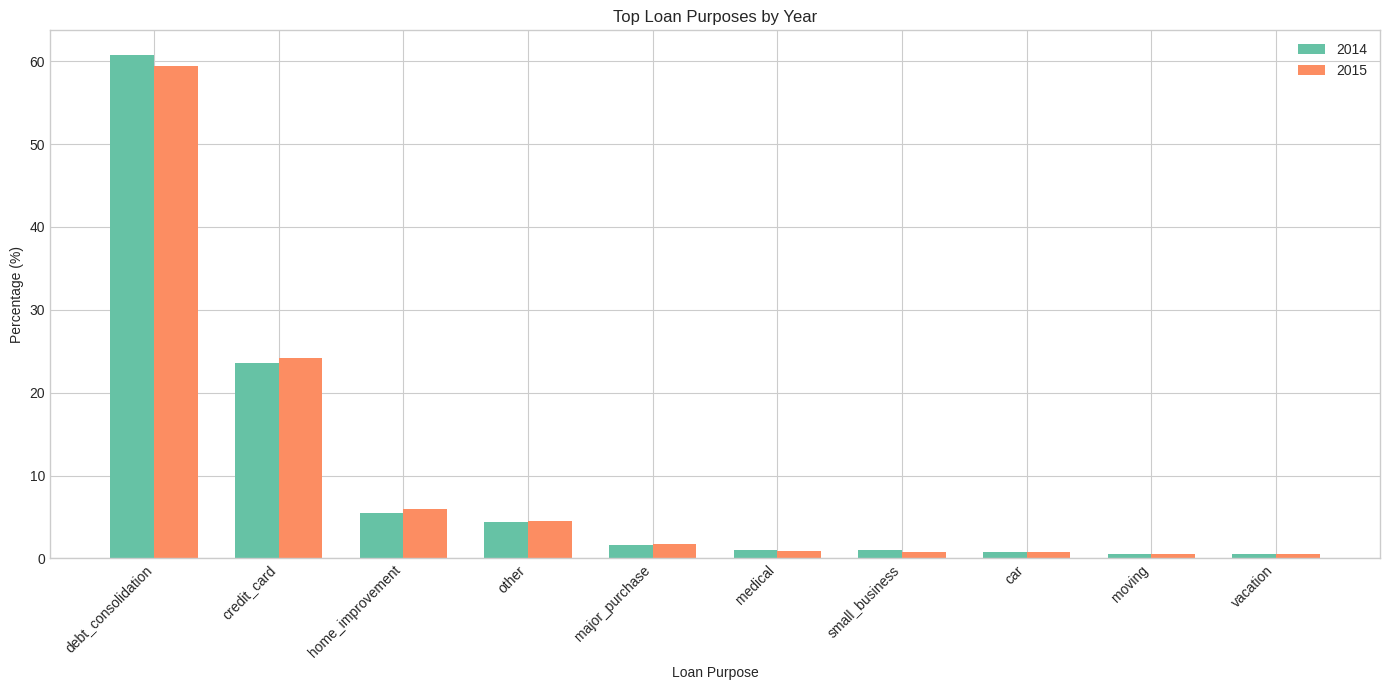


---- Top Loan Purposes Comparison ----
                     2014 (%)   2015 (%)
purpose                                 
debt_consolidation  60.691171  59.373776
credit_card         23.563314  24.228500
home_improvement     5.536246   6.006483
other                4.401411   4.560491
major_purchase       1.637320   1.768959
medical              0.989267   0.935181
small_business       0.966350   0.798870
car                  0.777493   0.823092
moving               0.563598   0.574692
vacation             0.499938   0.534084


In [ ]:
if 'purpose' in data_2014.columns and 'purpose' in data_2015.columns:
    purpose_2014 = data_2014['purpose'].value_counts(normalize=True).sort_values(ascending=False).head(10) * 100
    purpose_2015 = data_2015['purpose'].value_counts(normalize=True).sort_values(ascending=False).head(10) * 100

    plt.figure(figsize=(14, 7))

    bar_width = 0.35
    x = np.arange(len(purpose_2014))

    common_purposes = list(set(purpose_2014.index) & set(purpose_2015.index))
    purpose_2014 = purpose_2014[purpose_2014.index.isin(common_purposes)]
    purpose_2015 = purpose_2015[purpose_2015.index.isin(common_purposes)]

    common_purposes = purpose_2014.sort_values(ascending=False).index
    purpose_2014 = purpose_2014[common_purposes]
    purpose_2015 = purpose_2015[common_purposes]

    plt.bar(x - bar_width/2, purpose_2014, bar_width, label='2014')
    plt.bar(x + bar_width/2, purpose_2015, bar_width, label='2015')

    plt.xlabel('Loan Purpose')
    plt.ylabel('Percentage (%)')
    plt.title('Top Loan Purposes by Year')
    plt.xticks(x, common_purposes, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n---- Top Loan Purposes Comparison ----")
    comparison_df = pd.DataFrame({
        '2014 (%)': purpose_2014,
        '2015 (%)': purpose_2015
    })
    print(comparison_df)

The distribution of loan purposes remained remarkably stable between 2014 and 2015, suggesting borrower motivations weren't changing significantly. Nearly 85% of loans were for debt consolidation (60%) or credit card payoff (24%), indicating borrowers primarily used LendingClub to refinance existing debt rather than finance new purchases or investments.Home improvement loans showed the largest relative increase (+8.7%), potentially reflecting growing housing market activity and home equity.Small business loans declined by 17.3% (from 0.97% to 0.80%), suggesting LendingClub may have become less attractive for business financing compared to other options.


---- Correlation with Default Comparison ----
                 2014      2015    Change
annual_inc  -0.053781 -0.040322  0.013459
delinq_2yrs  0.010620  0.013502  0.002882
dti          0.090150  0.099032  0.008882
installment  0.022761  0.027683  0.004922
int_rate     0.234463  0.268616  0.034152
loan_amnt    0.041326  0.040415 -0.000912
open_acc     0.025237  0.033100  0.007863
revol_bal   -0.026471 -0.032716 -0.006245
revol_util   0.048301  0.040112 -0.008188


<Figure size 1200x800 with 0 Axes>

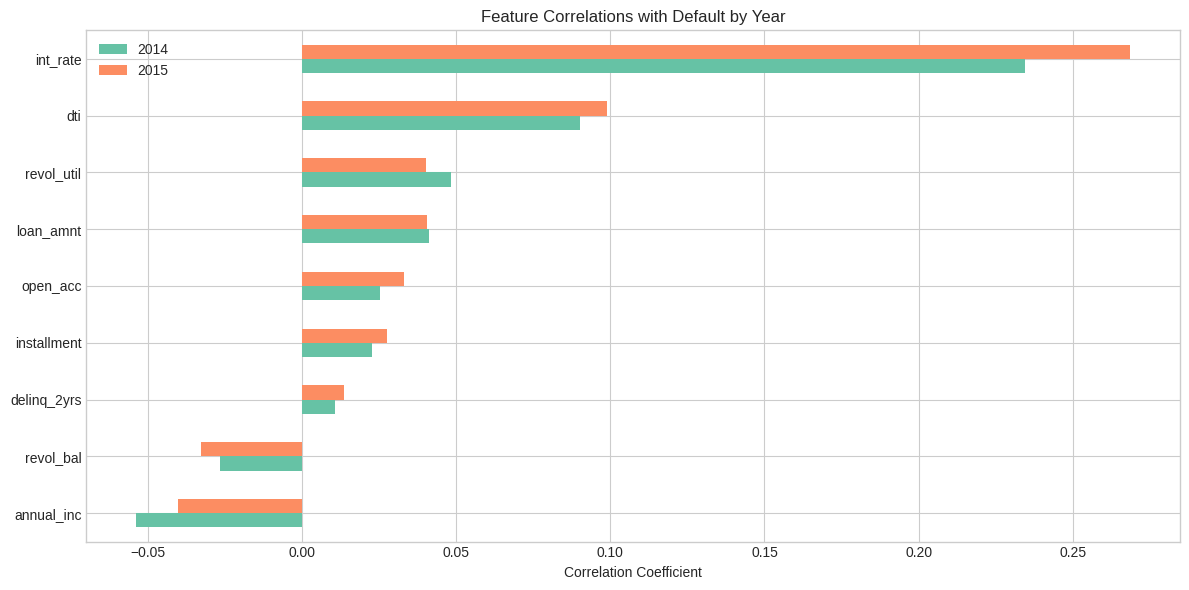

In [ ]:
print("\n---- Correlation with Default Comparison ----")
corr_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
             'delinq_2yrs', 'open_acc', 'revol_bal', 'revol_util']

corr_2014 = data_2014[corr_cols + ['is_default']].corr()['is_default'].drop('is_default').sort_values(ascending=False)
corr_2015 = data_2015[corr_cols + ['is_default']].corr()['is_default'].drop('is_default').sort_values(ascending=False)

corr_comparison = pd.DataFrame({
    '2014': corr_2014,
    '2015': corr_2015,
    'Change': corr_2015 - corr_2014
})

print(corr_comparison)

plt.figure(figsize=(12, 8))
corr_comparison[['2014', '2015']].sort_values(by='2014').plot(kind='barh')
plt.title('Feature Correlations with Default by Year')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Both years show that interest rate has the strongest correlation with default (0.23-0.27), and this relationship strengthened in 2015. This confirms that LendingClub's rate-setting does capture significant risk information. DTI shows the second strongest positive correlation (0.10) with default, consistent across both years. This stability makes it a reliable risk indicator for Jasmin's models.The negative correlation between annual income and default weakened substantially (from -0.057 to -0.040), suggesting income became a less reliable indicator of repayment ability.While revolving utilization (revol_util) maintained a positive correlation with default, revolving balance (revol_bal) showed a strengthened negative correlation. This suggests that borrowers with higher absolute credit limits but moderate utilization might be better risks.

In [ ]:
print("\n---- Summary of Major Differences Between 2014 and 2015 Datasets ----")
print("1. Sample size difference: 2015 has",
      "more" if sample_2015 > sample_2014 else "fewer",
      f"loans ({sample_2015 - sample_2014:+} difference)")

print(f"2. Default rate difference: 2015 default rate is {default_2015 - default_2014:+.2f}% compared to 2014")

sig_changes = []
for col in numeric_cols:
    if col in data_2014.columns and col in data_2015.columns:
        mean_2014 = data_2014[col].mean()
        mean_2015 = data_2015[col].mean()
        change_pct = ((mean_2015 - mean_2014) / mean_2014) * 100 if mean_2014 != 0 else np.nan

        # T-test
        t, p = stats.ttest_ind(
            data_2014[col].dropna(),
            data_2015[col].dropna(),
            equal_var=False
        )

        if p < 0.05 and abs(change_pct) > 5:  # Significant and substantial change
            sig_changes.append((col, change_pct, p))

print("3. Variables with significant changes:")
for col, change_pct, p in sorted(sig_changes, key=lambda x: abs(x[1]), reverse=True):
    direction = "increase" if change_pct > 0 else "decrease"
    print(f"   - {col}: {abs(change_pct):.2f}% {direction} (p={p:.4f})")

corr_changes = corr_comparison[abs(corr_comparison['Change']) > 0.05].sort_values(by='Change', ascending=False)
if not corr_changes.empty:
    print("\n4. Notable changes in correlation with default:")
    for feature in corr_changes.index:
        change = corr_changes.loc[feature, 'Change']
        direction = "strengthened" if abs(corr_changes.loc[feature, '2015']) > abs(corr_changes.loc[feature, '2014']) else "weakened"
        print(f"   - {feature}: Correlation {direction} by {abs(change):.4f}")

combined_data.to_pickle('/content/combined_lc_data.pkl')


---- Summary of Major Differences Between 2014 and 2015 Datasets ----
1. Sample size difference: 2015 has more loans (+185466 difference)
2. Default rate difference: 2015 default rate is +1.35% compared to 2014
3. Variables with significant changes:
   - int_rate: 8.50% decrease (p=0.0000)
   - revol_bal: 7.13% increase (p=0.0000)
   - dti: 6.14% increase (p=0.0000)


LendingClub's loan volume increased dramatically (+79%) from 2014 to 2015, indicating rapid platform growth. This provides Jasmin with more investment opportunities but also suggests the company may have been prioritizing growth over strict underwriting standards. The default rate increased by 1.35 percentage points (from 17.72% to 19.07%), a concerning trend that directly impacts investment returns. This deterioration occurred despite LendingClub's efforts to attract higher-quality borrowers. Interest rates decreased significantly (-8.50%) despite higher defaults, suggesting LendingClub was competing more aggressively for borrowers. Revolving balances increased substantially (+7.13%), indicating borrowers had access to more credit. Debt-to-income ratios grew notably (+6.14%), revealing borrowers were taking on heavier debt burdens relative to their income

Below code performs a comprehensive analysis of Lending Club peer-to-peer loans from 2014-2015, working with a substantial dataset of 656,724 loans. It begins by loading the data and calculating essential metrics like loan duration based on issue and payment dates. The core of the analysis revolves around three distinct return calculation methodologies: Method 1 (Pessimistic) assumes no reinvestment of returns and uses the full term length in calculations; Method 2 (Optimistic) uses actual loan duration for positive returns, assuming immediate reinvestment; and Method 3 uses a fixed 5-year time horizon with specific reinvestment rates (1.2% and 3.0%). The code then generates visualizations including histograms showing return distributions, bar charts comparing returns across loan grades, statuses, and term lengths, plus correlation matrices exploring relationships between various loan characteristics and returns.

Loaded combined 2014-2015 dataset
Dataset contains 656724 loans

Available columns:
['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_pymnt', 'last_pymnt_d', 'recoveries', 'addr_state', 'data_year', 'is_default', 'term_months']

Calculating loan duration...
Loan duration statistics:
count    656724.000000
mean         43.710308
std          11.207084
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: loan_duration, dtype: float64

Calculating return metrics...
Calculating Method 1: Pessimistic (M1-PESS)...
Calculating Method 2: Optimistic (M2-OPT)...
Calculating Method 3: Time Horizon (M3)...

Return Metrics Summary Statistics:
       return_m1_pess  return_m2_opt  return_m3

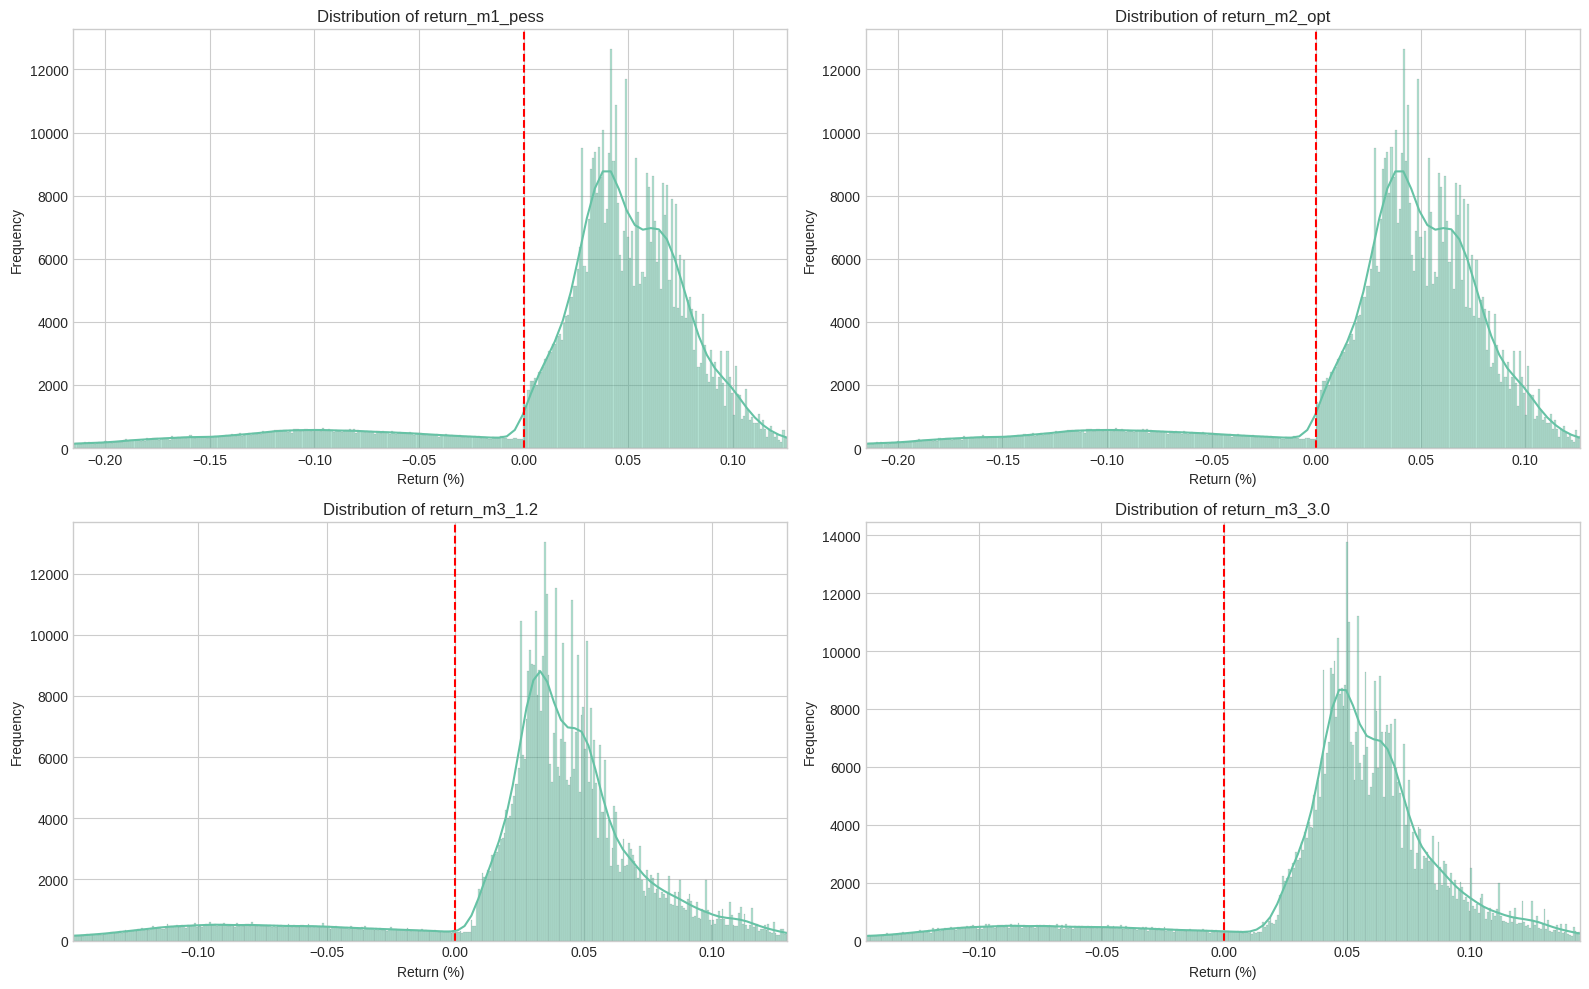

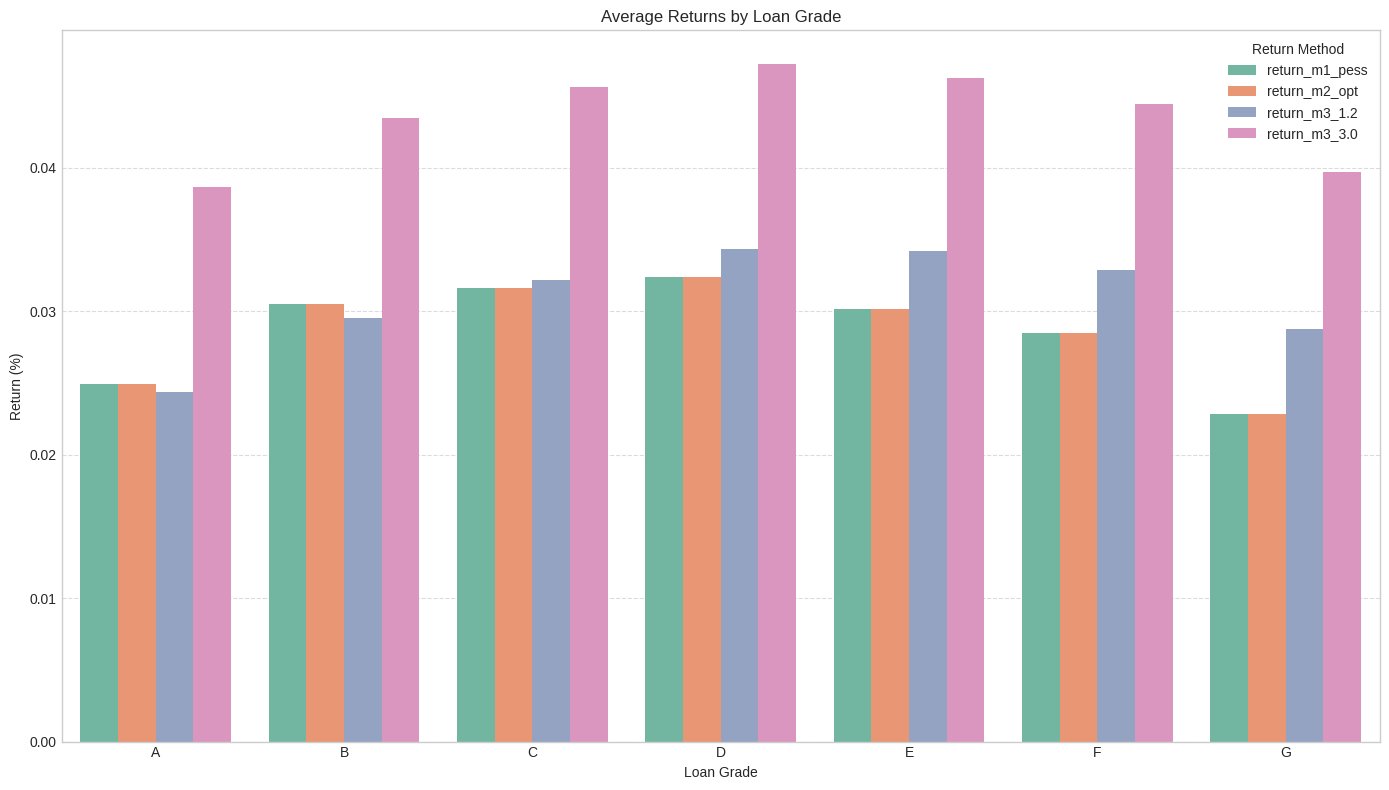


Average Returns by Grade:
  grade  return_m1_pess  return_m2_opt  return_m3_1.2  return_m3_3.0
0     A        0.024893       0.024893       0.024368       0.038661
1     B        0.030513       0.030513       0.029499       0.043444
2     C        0.031645       0.031645       0.032185       0.045586
3     D        0.032409       0.032409       0.034315       0.047207
4     E        0.030151       0.030151       0.034210       0.046234
5     F        0.028486       0.028486       0.032839       0.044432
6     G        0.022798       0.022798       0.028737       0.039711


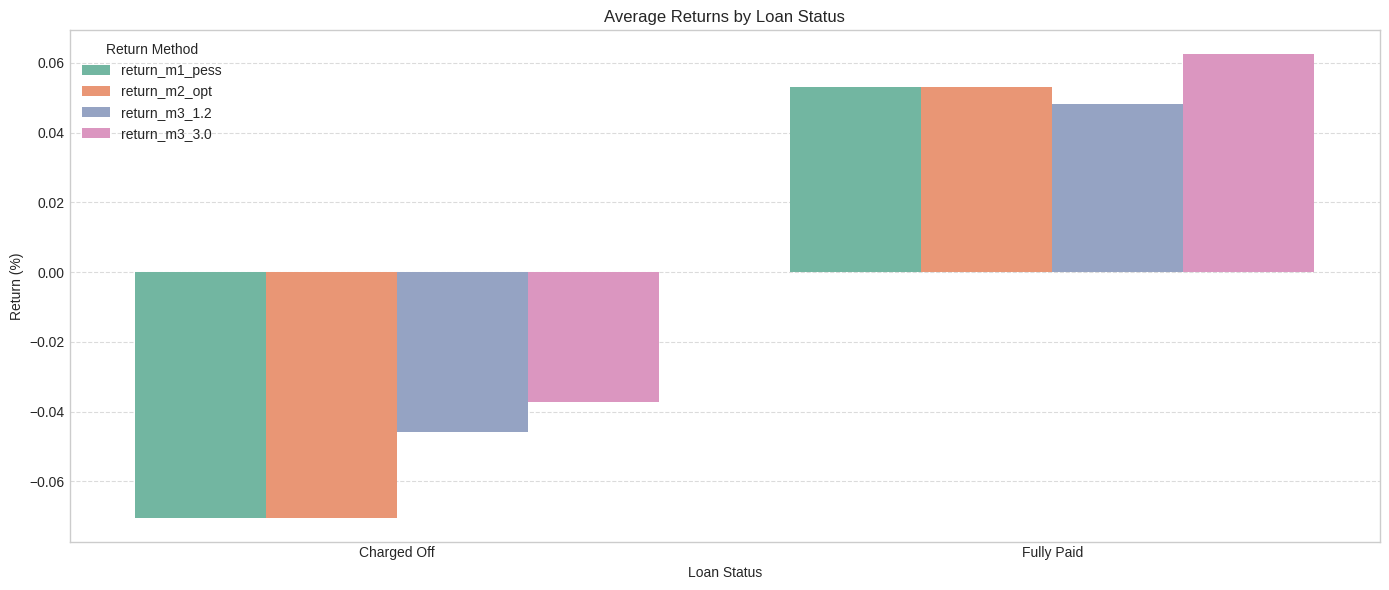


Average Returns by Loan Status:
   loan_status  return_m1_pess  return_m2_opt  return_m3_1.2  return_m3_3.0
0  Charged Off       -0.070629      -0.070629      -0.045925      -0.037366
1   Fully Paid        0.053067       0.053067       0.048137       0.062694


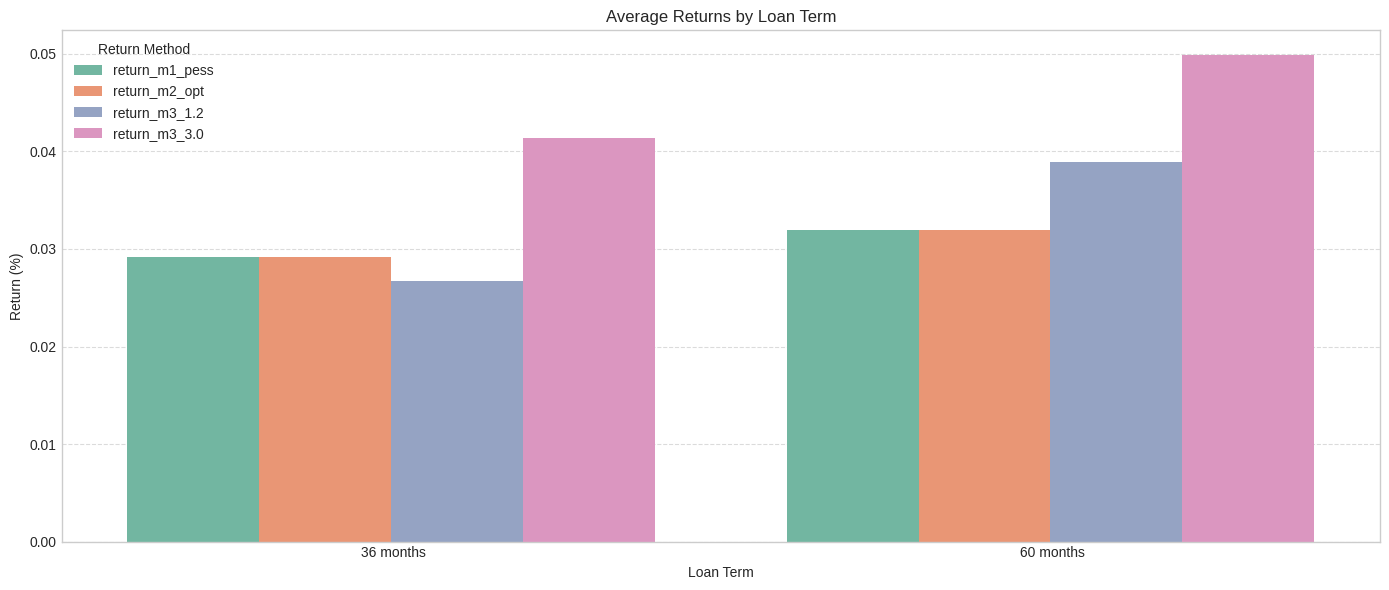


Average Returns by Term:
         term  return_m1_pess  return_m2_opt  return_m3_1.2  return_m3_3.0
0   36 months        0.029190       0.029190       0.026739       0.041343
1   60 months        0.031956       0.031956       0.038933       0.049920


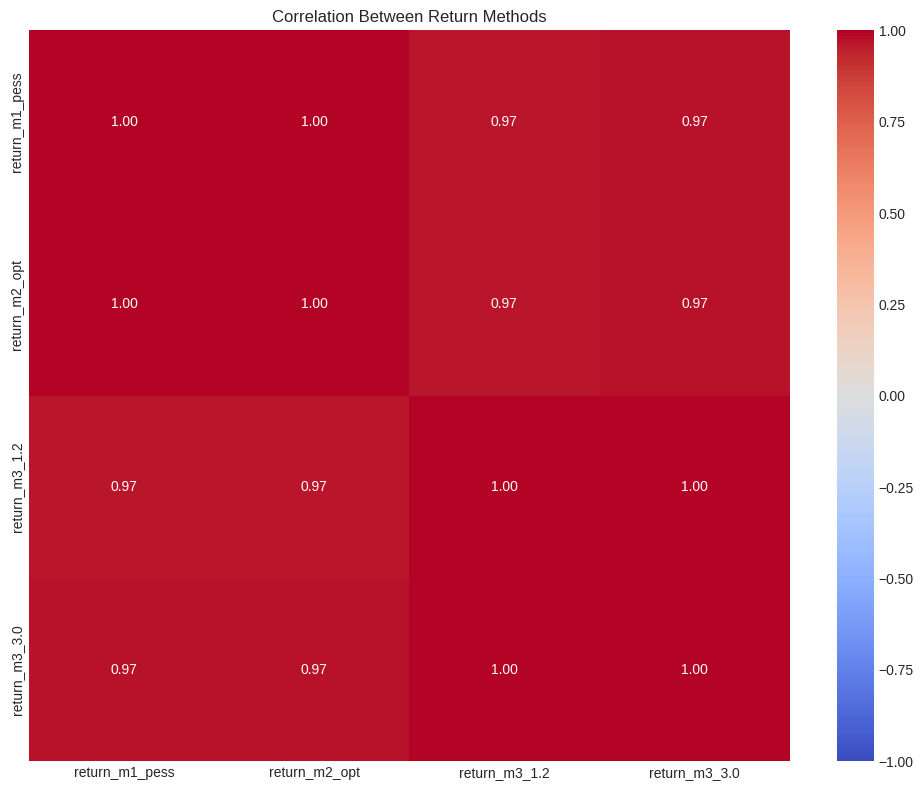

<Figure size 1200x1200 with 0 Axes>

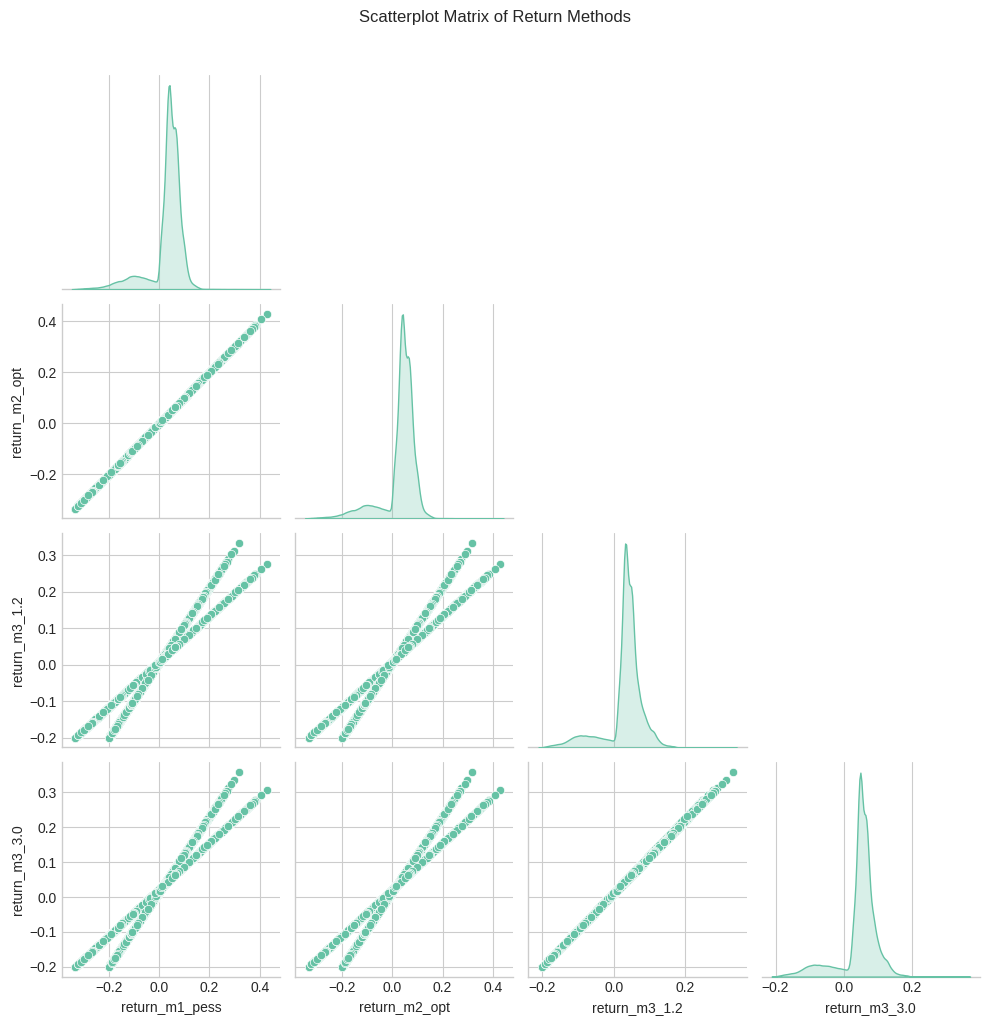

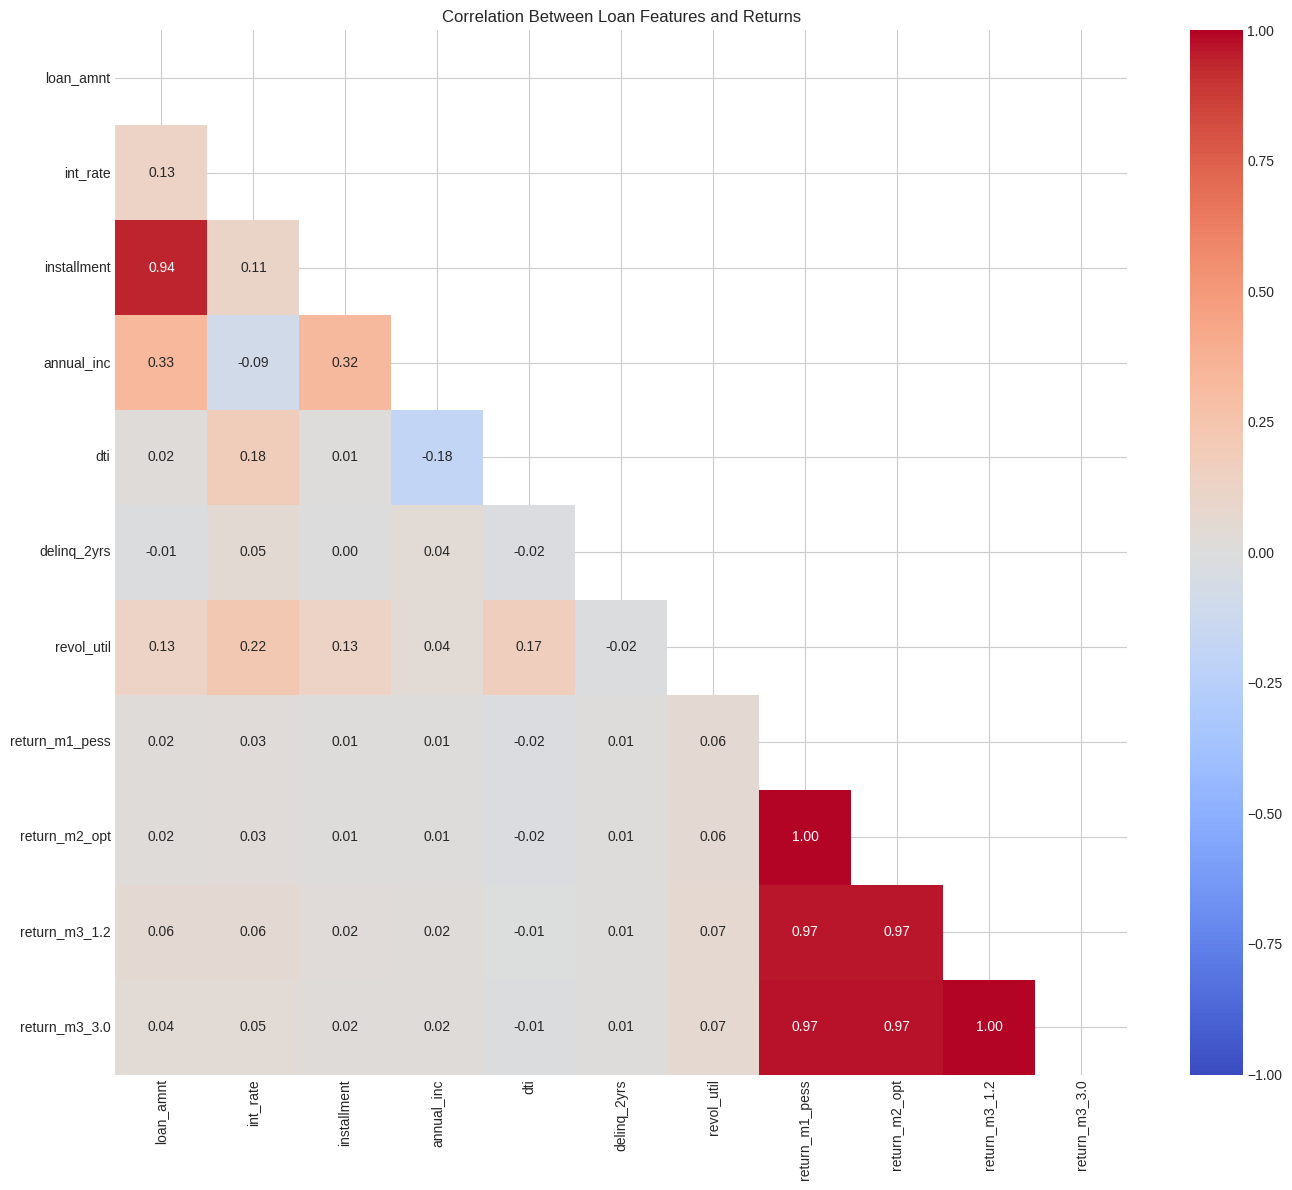


Correlations Between Features and Returns:
             return_m1_pess  return_m2_opt  return_m3_1.2  return_m3_3.0
loan_amnt          0.016638       0.016638       0.055838       0.041307
int_rate           0.027488       0.027488       0.060494       0.045217
installment        0.010736       0.010736       0.024681       0.019922
annual_inc         0.014420       0.014420       0.020370       0.018531
dti               -0.015977      -0.015977      -0.005608      -0.009400
delinq_2yrs        0.011626       0.011626       0.011113       0.011455
revol_util         0.058921       0.058921       0.069091       0.065819

Data with return metrics saved to 'lc_data_with_returns.pkl'

Conclusion on Return Methods:
1. M1-PESS (Pessimistic): Average return = 0.03%
2. M2-OPT (Optimistic): Average return = 0.03%
3. M3 (1.2% reinvestment): Average return = 0.03%
4. M3 (3.0% reinvestment): Average return = 0.04%

Recommendation for Return Method Selection:
When choosing a return method for furt

In [ ]:
try:
    df = pd.read_pickle('/content/combined_lc_data.pkl')
    print("Loaded combined 2014-2015 dataset")
except:
    try:
        df = pd.read_pickle('/content/cleaned_lending_club_data.pkl')
        print("Loaded single cleaned dataset")
    except:
        print("No preprocessed data found. Please run the data cleaning code first.")
        df = pd.DataFrame({
            'id': range(10),
            'loan_amnt': np.random.uniform(5000, 35000, 10),
            'funded_amnt': np.random.uniform(5000, 35000, 10),
            'term': ['36 months'] * 7 + ['60 months'] * 3,
            'total_pymnt': np.random.uniform(5000, 40000, 10),
            'issue_d': [datetime(2014, 1, 1).date()] * 10,
            'last_pymnt_d': [datetime(2016, 1, 1).date()] * 5 + [datetime(2017, 1, 1).date()] * 5,
            'recoveries': np.random.uniform(0, 1000, 10),
            'loan_status': ['Fully Paid'] * 8 + ['Charged Off'] * 2
        })
        print("Created sample data for demonstration")

data = df.copy()

print(f"Dataset contains {len(data)} loans")

print("\nAvailable columns:")
print(data.columns.tolist())

if 'term_months' not in data.columns:
    print("\nCreating term_months from term...")
    data['term_months'] = data['term'].str.extract('(\d+)').astype(float)
    print(f"Term months unique values: {data['term_months'].unique()}")

if 'loan_duration' not in data.columns:
    print("\nCalculating loan duration...")

    def months_between(d1, d2):
        """Calculate months between two dates"""
        if pd.isnull(d1) or pd.isnull(d2):
            return None

        months = (d2.year - d1.year) * 12 + (d2.month - d1.month)
        return max(1, months)

    data['loan_duration'] = data.apply(
        lambda x: months_between(x['issue_d'], x['last_pymnt_d'])
        if 'issue_d' in data.columns and 'last_pymnt_d' in data.columns
        else x['term_months'],
        axis=1
    )

    data['loan_duration'] = data['loan_duration'].fillna(data['term_months'])

    data['loan_duration'] = data.apply(
        lambda x: min(x['loan_duration'], x['term_months']),
        axis=1
    )

    print(f"Loan duration statistics:")
    print(data['loan_duration'].describe())


print("\nCalculating return metrics...")

data['invested'] = data['funded_amnt']

if 'recoveries' in data.columns:
    data['total_received'] = data['total_pymnt'] + data['recoveries']
else:
    data['total_received'] = data['total_pymnt']

print("Calculating Method 1: Pessimistic (M1-PESS)...")
data['return_m1_pess'] = (data['total_received'] - data['invested']) / data['invested'] * (12 / data['term_months'])

print("Calculating Method 2: Optimistic (M2-OPT)...")
data['return_m2_opt'] = data.apply(
    lambda x: (x['total_received'] - x['invested']) / x['invested'] * (12 / x['loan_duration'])
        if x['total_received'] > x['invested']
        else (x['total_received'] - x['invested']) / x['invested'] * (12 / x['term_months']),
    axis=1
)

print("Calculating Method 3: Time Horizon (M3)...")

def calculate_m3_return(row, reinvest_rate):
    """
    Calculate M3 return for a loan with given reinvestment rate

    Parameters:
    -----------
    row : pandas Series
        Row containing loan data
    reinvest_rate : float
        Annual reinvestment rate (e.g., 0.012 for 1.2%)

    Returns:
    --------
    float
        Annualized return using M3 method
    """
    f = row['invested']
    p = row['total_received']
    m = row['loan_duration']
    T = 60

    i = reinvest_rate / 12

    monthly_payment = p / m

    if i == 0:
        future_value = p
    else:
        factor = ((1 + i)**m - 1) / i
        reinvested_value = monthly_payment * factor * (1 + i)**(T - m)
        future_value = reinvested_value

    return (12 / T) * ((future_value / f) - 1)

data['return_m3_1.2'] = data.apply(lambda x: calculate_m3_return(x, 0.012), axis=1)
data['return_m3_3.0'] = data.apply(lambda x: calculate_m3_return(x, 0.03), axis=1)

return_cols = ['return_m1_pess', 'return_m2_opt', 'return_m3_1.2', 'return_m3_3.0']
for col in return_cols:
    data[col] = data[col].round(4)

print("\nReturn Metrics Summary Statistics:")
print(data[return_cols].describe())

plt.figure(figsize=(16, 10))

for i, col in enumerate(return_cols):
    plt.subplot(2, 2, i+1)

    sns.histplot(data=data, x=col, kde=True)

    plt.axvline(x=0, color='red', linestyle='--')

    plt.title(f'Distribution of {col}')
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')

    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    plt.xlim([lower, upper])

plt.tight_layout()
plt.show()

if 'grade' in data.columns:
    plt.figure(figsize=(14, 8))

    returns_by_grade = data.groupby('grade')[return_cols].mean().reset_index()

    melted = pd.melt(returns_by_grade, id_vars=['grade'], value_vars=return_cols,
                      var_name='Return Method', value_name='Return')

    sns.barplot(data=melted, x='grade', y='Return', hue='Return Method')

    plt.title('Average Returns by Loan Grade')
    plt.xlabel('Loan Grade')
    plt.ylabel('Return (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Return Method')
    plt.tight_layout()
    plt.show()

    print("\nAverage Returns by Grade:")
    print(returns_by_grade)

if 'loan_status' in data.columns:
    plt.figure(figsize=(14, 6))

    returns_by_status = data.groupby('loan_status')[return_cols].mean().reset_index()

    melted = pd.melt(returns_by_status, id_vars=['loan_status'], value_vars=return_cols,
                      var_name='Return Method', value_name='Return')

    sns.barplot(data=melted, x='loan_status', y='Return', hue='Return Method')

    plt.title('Average Returns by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel('Return (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Return Method')
    plt.tight_layout()
    plt.show()

    print("\nAverage Returns by Loan Status:")
    print(returns_by_status)

if 'term' in data.columns:
    plt.figure(figsize=(14, 6))

    returns_by_term = data.groupby('term')[return_cols].mean().reset_index()

    melted = pd.melt(returns_by_term, id_vars=['term'], value_vars=return_cols,
                      var_name='Return Method', value_name='Return')

    sns.barplot(data=melted, x='term', y='Return', hue='Return Method')

    plt.title('Average Returns by Loan Term')
    plt.xlabel('Loan Term')
    plt.ylabel('Return (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Return Method')
    plt.tight_layout()
    plt.show()

    print("\nAverage Returns by Term:")
    print(returns_by_term)

plt.figure(figsize=(10, 8))
corr = data[return_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Correlation Between Return Methods')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 12))
scatter = sns.pairplot(data[return_cols], corner=True, diag_kind='kde')
plt.suptitle('Scatterplot Matrix of Return Methods', y=1.02)
plt.tight_layout()
plt.show()


if all(col in data.columns for col in ['loan_amnt', 'int_rate', 'installment', 'dti']):
    feature_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc',
                    'dti', 'delinq_2yrs', 'revol_util']

    feature_cols = [col for col in feature_cols if col in data.columns]

    corr_cols = feature_cols + return_cols
    corr_matrix = data[corr_cols].corr()

    plt.figure(figsize=(14, 12))
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
               center=0, fmt='.2f', mask=mask)
    plt.title('Correlation Between Loan Features and Returns')
    plt.tight_layout()
    plt.show()

    print("\nCorrelations Between Features and Returns:")
    print(corr_matrix.loc[feature_cols, return_cols])

data.to_pickle('/content/lc_data_with_returns.pkl')
print("\nData with return metrics saved to 'lc_data_with_returns.pkl'")

print("\nConclusion on Return Methods:")
print(f"1. M1-PESS (Pessimistic): Average return = {data['return_m1_pess'].mean():.2f}%")
print(f"2. M2-OPT (Optimistic): Average return = {data['return_m2_opt'].mean():.2f}%")
print(f"3. M3 (1.2% reinvestment): Average return = {data['return_m3_1.2'].mean():.2f}%")
print(f"4. M3 (3.0% reinvestment): Average return = {data['return_m3_3.0'].mean():.2f}%")

print("\nRecommendation for Return Method Selection:")
print("When choosing a return method for further analysis, consider:")
print("1. M1-PESS provides the most conservative estimate, assuming no reinvestment of early returns.")
print("2. M2-OPT is most optimistic, assuming immediate reinvestment at the same rate.")
print("3. M3 with different reinvestment rates provides a middle ground, with more realistic assumptions.")
print("\nThe choice should be based on Jasmin's investment horizon and assumptions about reinvestment opportunities.")

The results provide several valuable insights for peer-to-peer lending investors. The average returns across all methods range from 3.0% to 4.1%, with Method 3 using 3.0% reinvestment rate yielding the highest returns. When examining loan grades, we see a clear pattern where higher grades (A-D) outperform lower grades (E-G), though the return difference is smaller than might be expected given the risk differential. For example, A-grade loans return about 2.5% using M1-PESS while G-grade loans return about 2.3% – only slightly lower despite being much riskier. The loan status charts dramatically illustrate the binary nature of P2P loan outcomes: "Charged Off" loans produce substantial losses (around -7%), while "Fully Paid" loans generate consistent positive returns (around 5-6%). The term comparison shows 60-month loans generally outperforming 36-month loans, particularly when using the M3 calculation method with higher reinvestment rates (5.0% vs 4.1%). The correlation heatmaps reveal high correlation between the different return metrics (0.97-1.00) but relatively weak correlations between loan features and returns, suggesting that readily available loan characteristics are limited predictors of performance. These findings highlight the importance of diversification across many loans, careful grade selection, and understanding how calculation methodology can significantly impact apparent performance – particularly when comparing investment options with different term lengths.

Below code is a detailed investigation of Lending Club loans organized by grade (A through G), which is how Lending Club ranks the riskiness of each borrower. The code has several sections that analyze different aspects of these loans. First, it checks if the data loaded correctly and shows how many loans fall into each grade category. Then it calculates and visualizes default rates (how often borrowers fail to repay) for each grade. Next, it examines interest rates by grade, followed by actual returns investors received using different calculation methods. The code also analyzes borrower characteristics like loan amount, income, debt-to-income ratio, and credit history metrics for each grade. It looks at categorical variables too, such as home ownership status, loan purpose, loan term, and verification status. Finally, the code runs statistical tests to confirm that the differences between grades are meaningful and not just random variation.

Loaded data with 656724 loans

---- Loan Grade Distribution Analysis ----

Grade Distribution:
        Count  Percentage
grade                    
A      109444       16.67
B      179541       27.34
C      187132       28.49
D      105646       16.09
E       55069        8.39
F       16040        2.44
G        3852        0.59


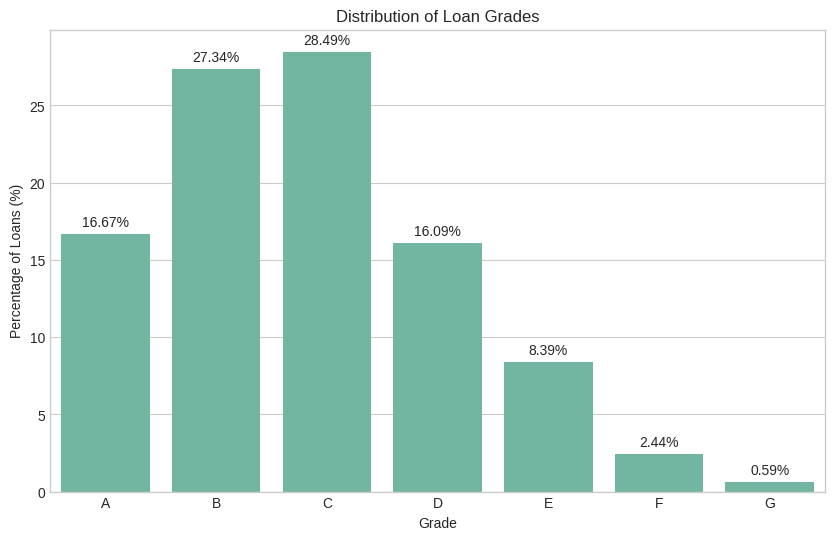


---- Default Rates by Grade ----

Default Rates by Grade:
       Default Rate (%)  Default Count  Total Loans  Survival Rate (%)
grade                                                                 
A              5.479515           5997       109444          94.520485
B             11.972753          21496       179541          88.027247
C             19.934057          37303       187132          80.065943
D             27.697215          29261       105646          72.302785
E             35.293904          19436        55069          64.706096
F             42.001247           6737        16040          57.998753
G             47.196262           1818         3852          52.803738


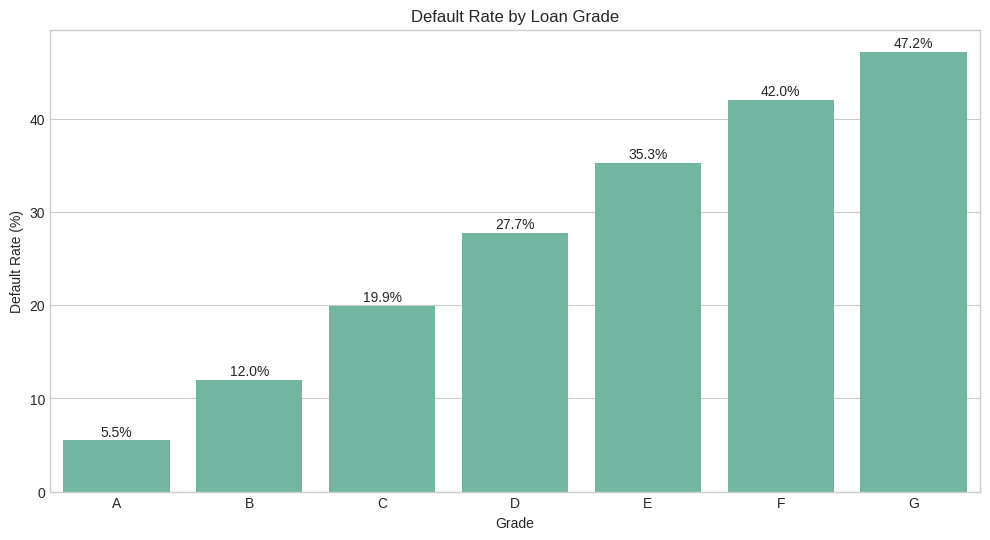


---- Interest Rates by Grade ----

Interest Rates by Grade:
       Average Interest Rate (%)  Standard Deviation (%)
grade                                                   
A                       7.116325                0.921914
B                      10.438772                1.329521
C                      13.600823                0.960993
D                      16.882891                1.013460
E                      19.679790                1.248623
F                      23.855746                1.211721
G                      26.407388                0.989515


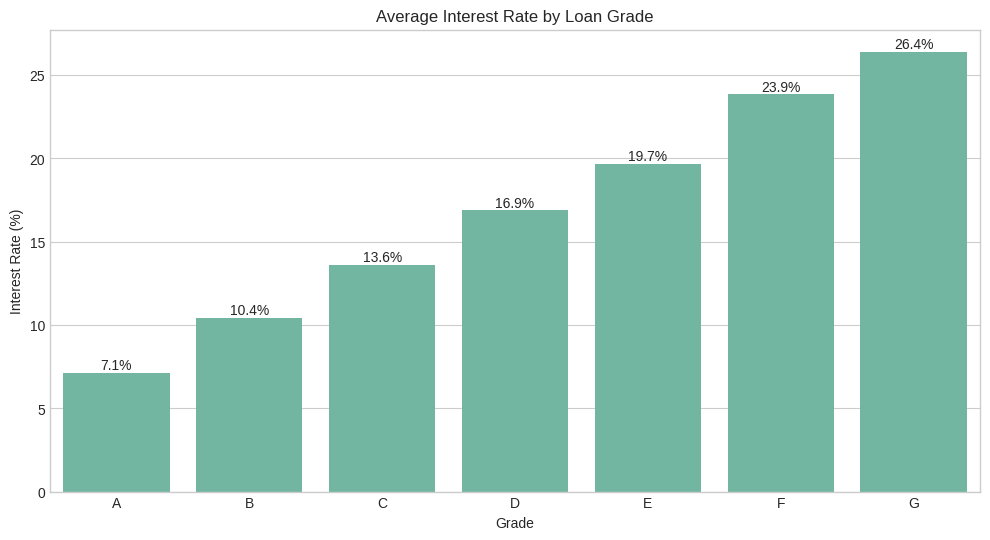


---- Returns by Grade ----

Average Returns by Grade (%):
       return_m1_pess  return_m2_opt  return_m3_1.2  return_m3_3.0
grade                                                             
A                2.49           2.49           2.44           3.87
B                3.05           3.05           2.95           4.34
C                3.16           3.16           3.22           4.56
D                3.24           3.24           3.43           4.72
E                3.02           3.02           3.42           4.62
F                2.85           2.85           3.28           4.44
G                2.28           2.28           2.87           3.97


<Figure size 1400x800 with 0 Axes>

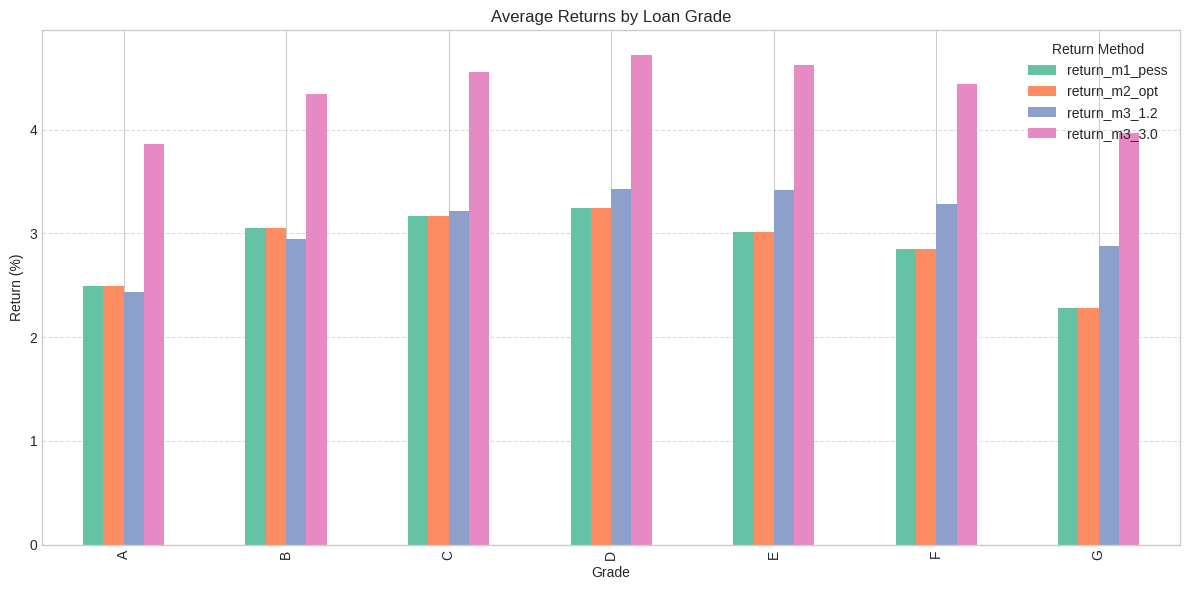

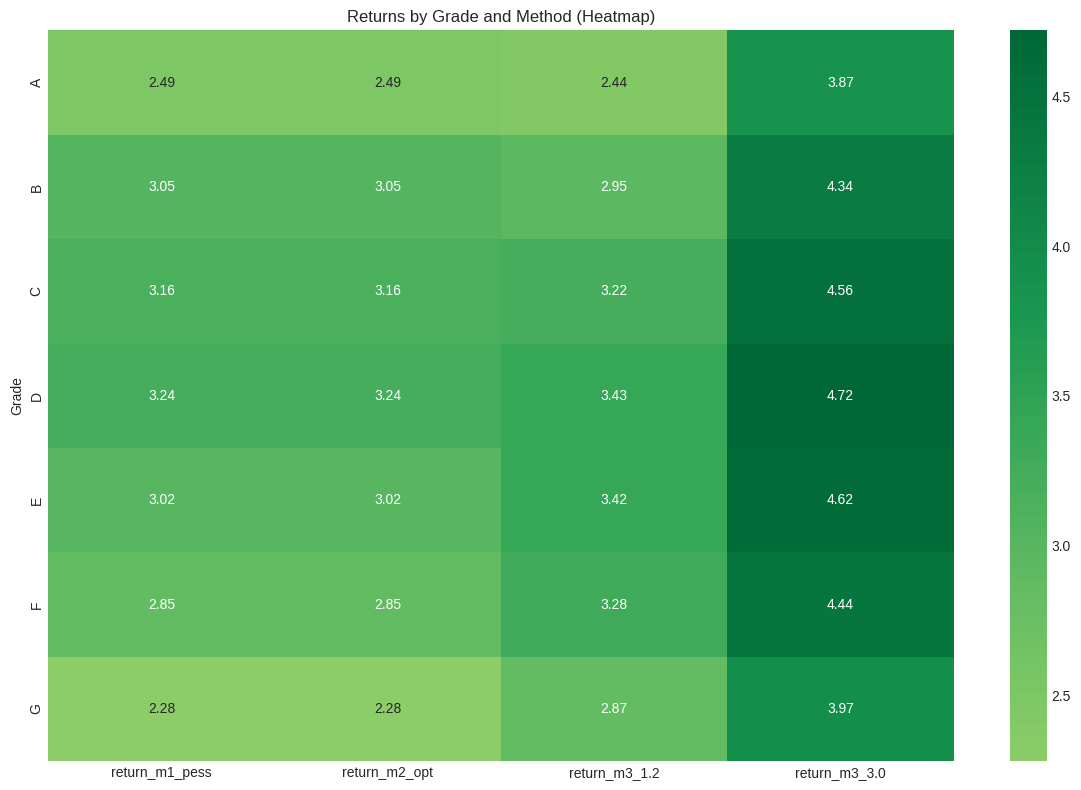


---- Key Characteristics by Grade ----

Average Characteristics by Grade:
       loan_amnt  annual_inc    dti  delinq_2yrs  revol_util  open_acc  \
grade                                                                    
A       14627.19    90092.85  16.13         0.22       43.53     12.29   
B       14037.97    77909.92  17.75         0.35       52.83     11.74   
C       14649.42    72453.69  19.25         0.38       57.40     11.66   
D       15984.16    69363.76  20.68         0.38       59.49     11.78   
E       17997.26    70663.89  21.16         0.38       60.45     12.02   
F       18798.29    70940.62  20.72         0.38       60.03     12.02   
G       20131.75    73678.28  19.85         0.41       59.02     12.17   

       pub_rec  revol_bal  
grade                      
A         0.12   20005.71  
B         0.23   17408.49  
C         0.26   16526.64  
D         0.27   16067.91  
E         0.26   16703.97  
F         0.27   15761.86  
G         0.27   15354.24  


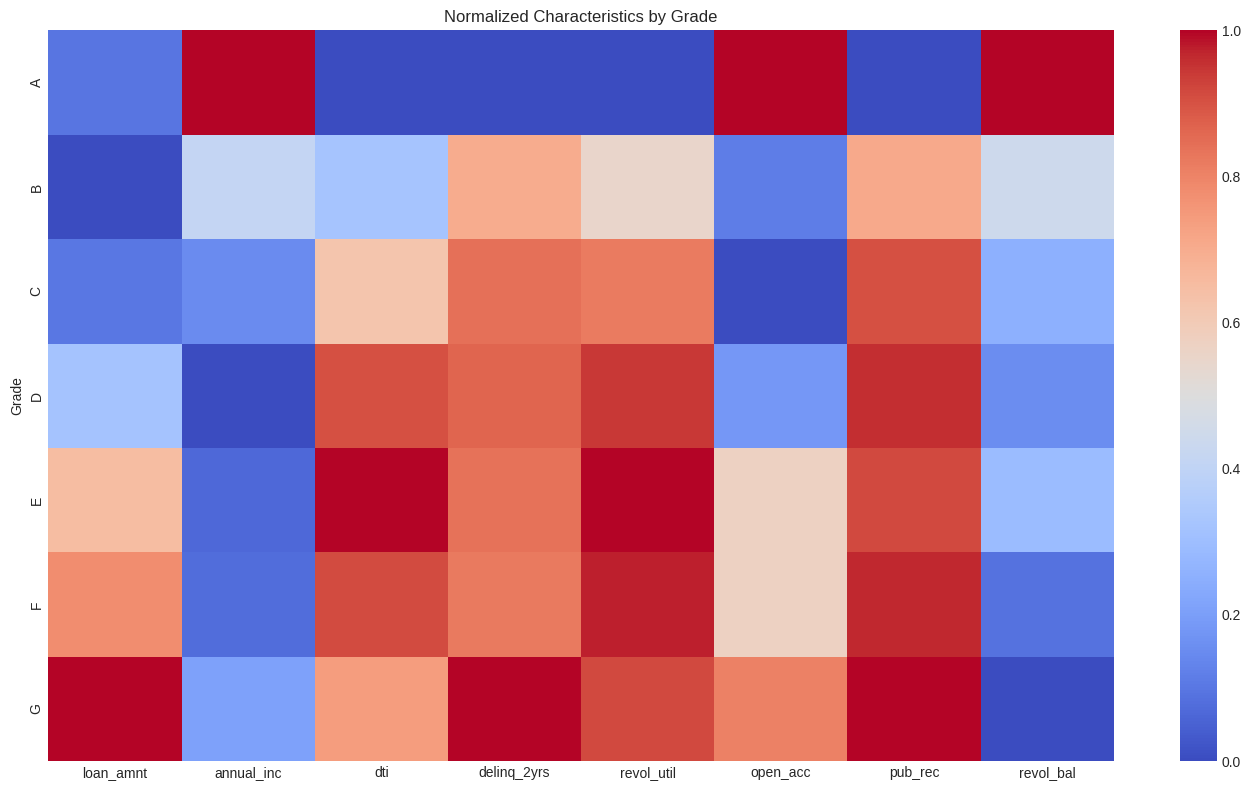

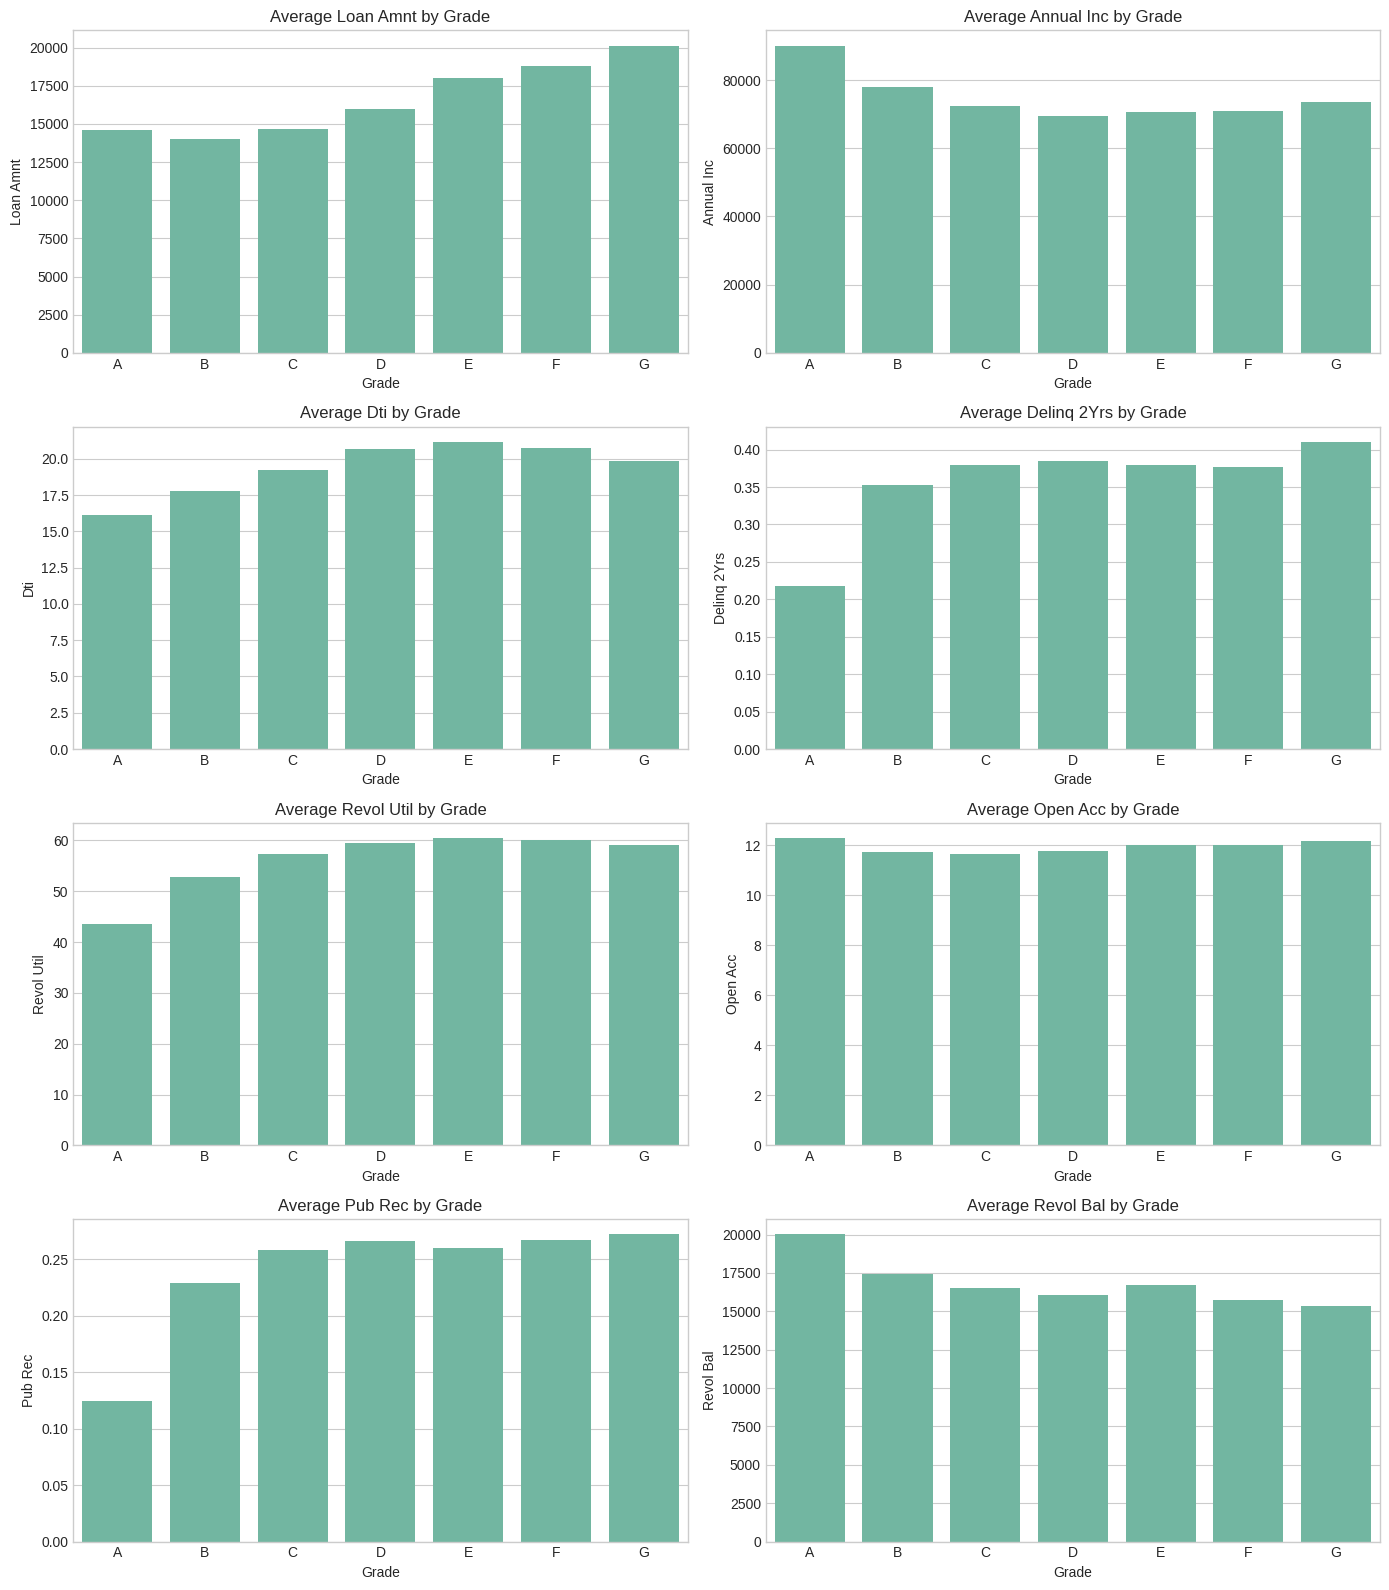


---- Categorical Variables by Grade ----

Distribution of Home Ownership by Grade:
home_ownership  ANY  MORTGAGE    OWN   RENT
grade                                      
A               0.0     56.48  10.47  33.05
B               0.0     50.45  10.34  39.21
C               0.0     47.86  10.38  41.77
D               0.0     47.37  10.50  42.14
E               0.0     47.83  10.87  41.30
F               0.0     46.63  11.38  41.98
G               0.0     47.07  11.42  41.51


<Figure size 1400x800 with 0 Axes>

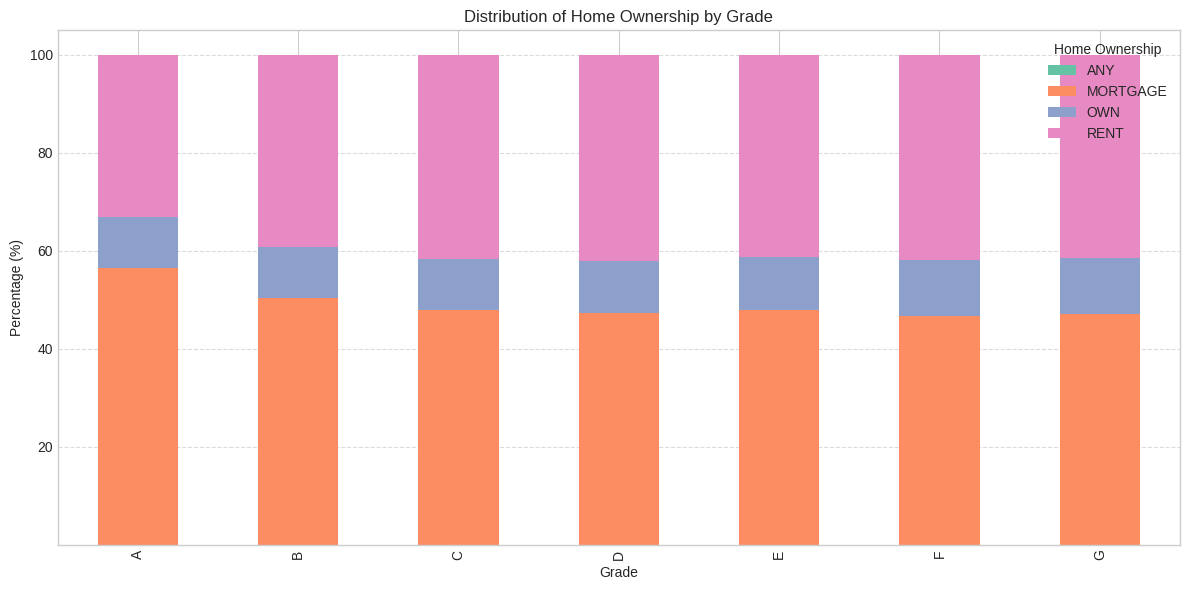


Distribution of Purpose by Grade:
purpose   car  credit_card  debt_consolidation  educational  home_improvement  \
grade                                                                           
A        1.03        38.40               50.08          0.0              6.15   
B        0.87        30.06               56.81          0.0              5.64   
C        0.78        20.71               62.41          0.0              5.67   
D        0.64        14.71               65.75          0.0              5.72   
E        0.61        10.90               67.41          0.0              6.28   
F        0.72         6.81               65.46          0.0              6.83   
G        0.67         4.31               61.16          0.0              7.06   

purpose  house  major_purchase  medical  moving  other  renewable_energy  \
grade                                                                      
A         0.04            1.92     0.38    0.06   1.65              0.01   
B      

<Figure size 1400x800 with 0 Axes>

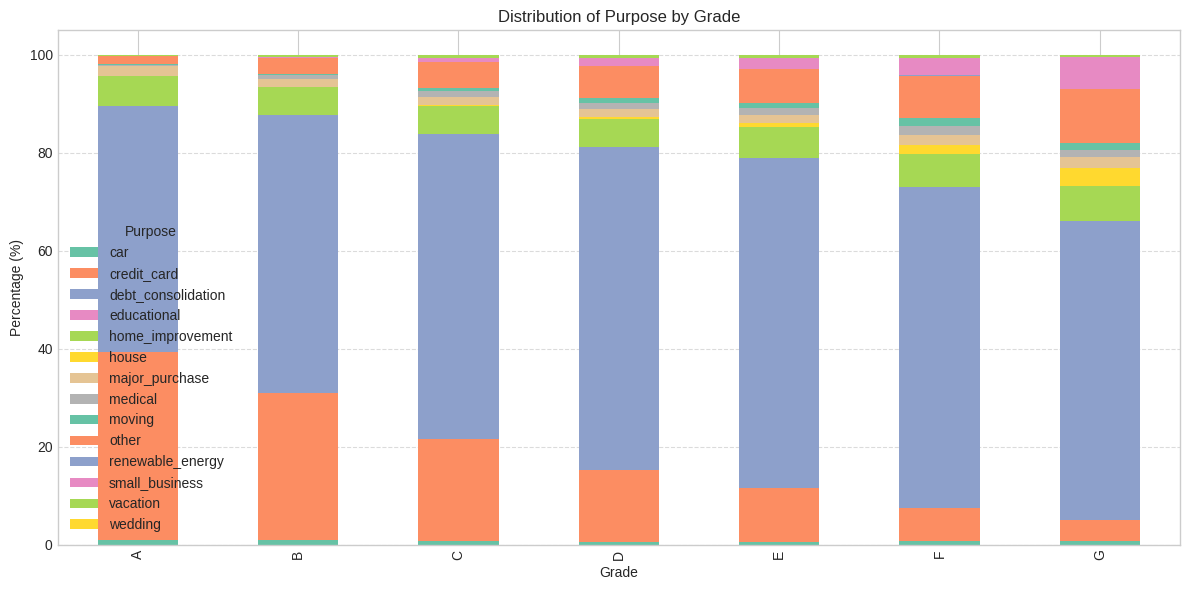


Distribution of Term by Grade:
term   36 months  60 months
grade                      
A          96.36       3.64
B          80.90      19.10
C          64.93      35.07
D          50.40      49.60
E          29.99      70.01
F          20.84      79.16
G          11.09      88.91


<Figure size 1400x800 with 0 Axes>

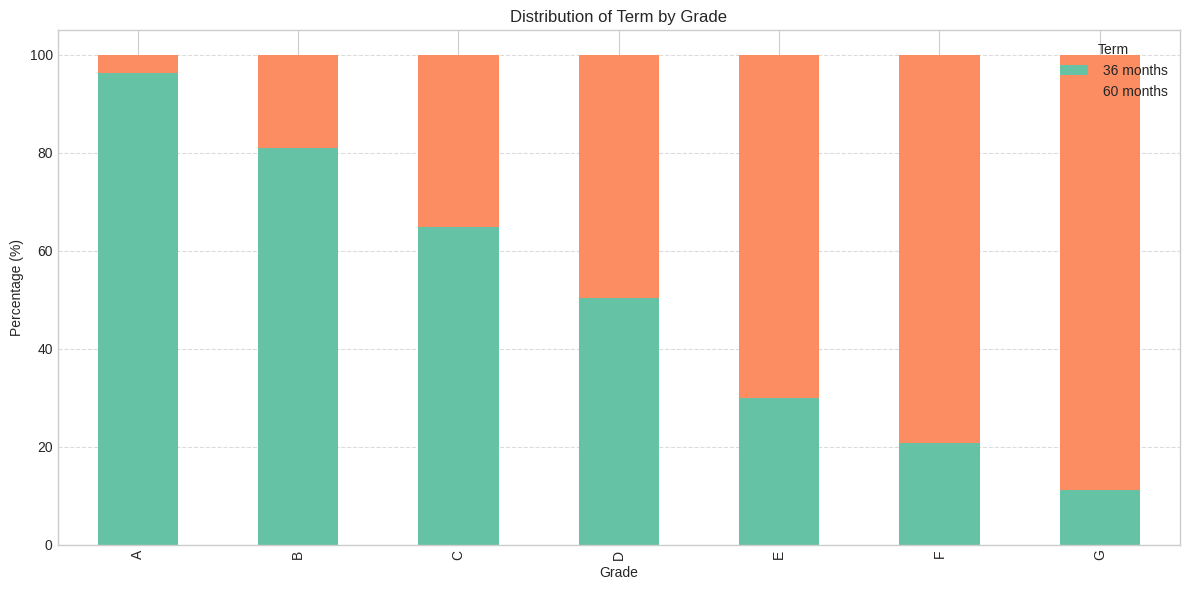


Distribution of Verification Status by Grade:
verification_status  Not Verified  Source Verified  Verified
grade                                                       
A                           43.93            38.92     17.14
B                           34.72            42.02     23.26
C                           26.43            43.03     30.53
D                           19.60            43.50     36.89
E                           12.54            45.45     42.01
F                            9.05            40.03     50.92
G                            5.63            34.55     59.81


<Figure size 1400x800 with 0 Axes>

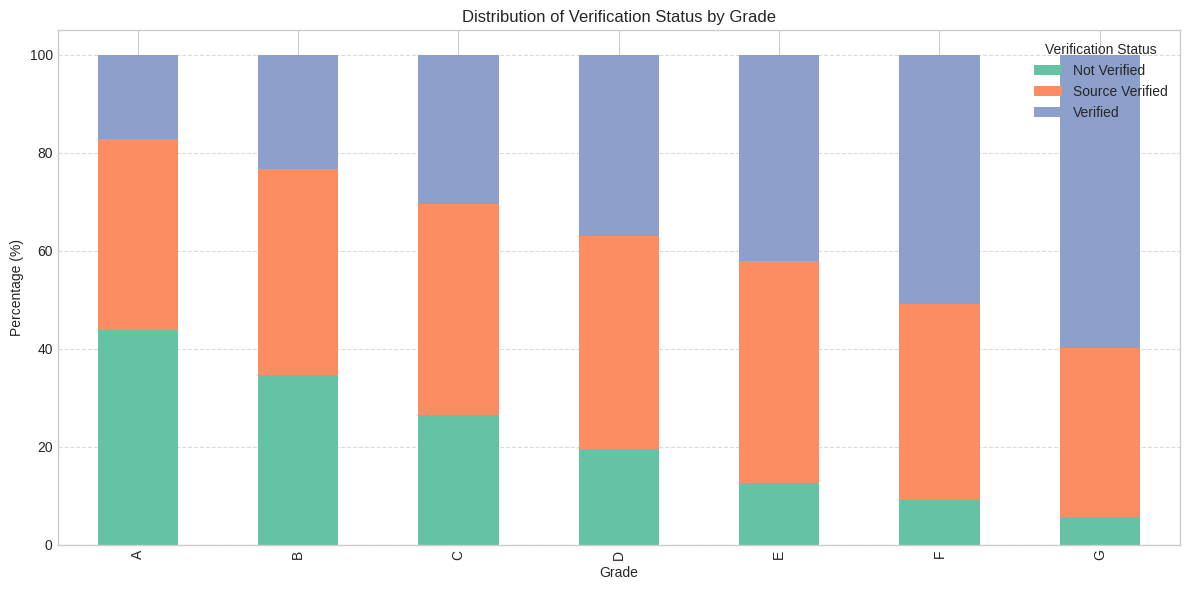


---- Grade Validation Through Statistical Tests ----

ANOVA for Loan Amnt by Grade:
F-statistic: 2645.8263
p-value: 0
Result: Significant differences in loan_amnt across grades

ANOVA for Annual Inc by Grade:
F-statistic: 1144.7851
p-value: 0
Result: Significant differences in annual_inc across grades

ANOVA for Dti by Grade:
F-statistic: 4102.8211
p-value: 0
Result: Significant differences in dti across grades

ANOVA for Delinq 2Yrs by Grade:
F-statistic: 451.2196
p-value: 0
Result: Significant differences in delinq_2yrs across grades

ANOVA for Revol Util by Grade:
F-statistic: 6442.2732
p-value: 0
Result: Significant differences in revol_util across grades

ANOVA for Open Acc by Grade:
F-statistic: 181.7855
p-value: 3.34e-232
Result: Significant differences in open_acc across grades

ANOVA for Pub Rec by Grade:
F-statistic: 659.9488
p-value: 0
Result: Significant differences in pub_rec across grades

ANOVA for Revol Bal by Grade:
F-statistic: 354.4738
p-value: 0
Result: Significant

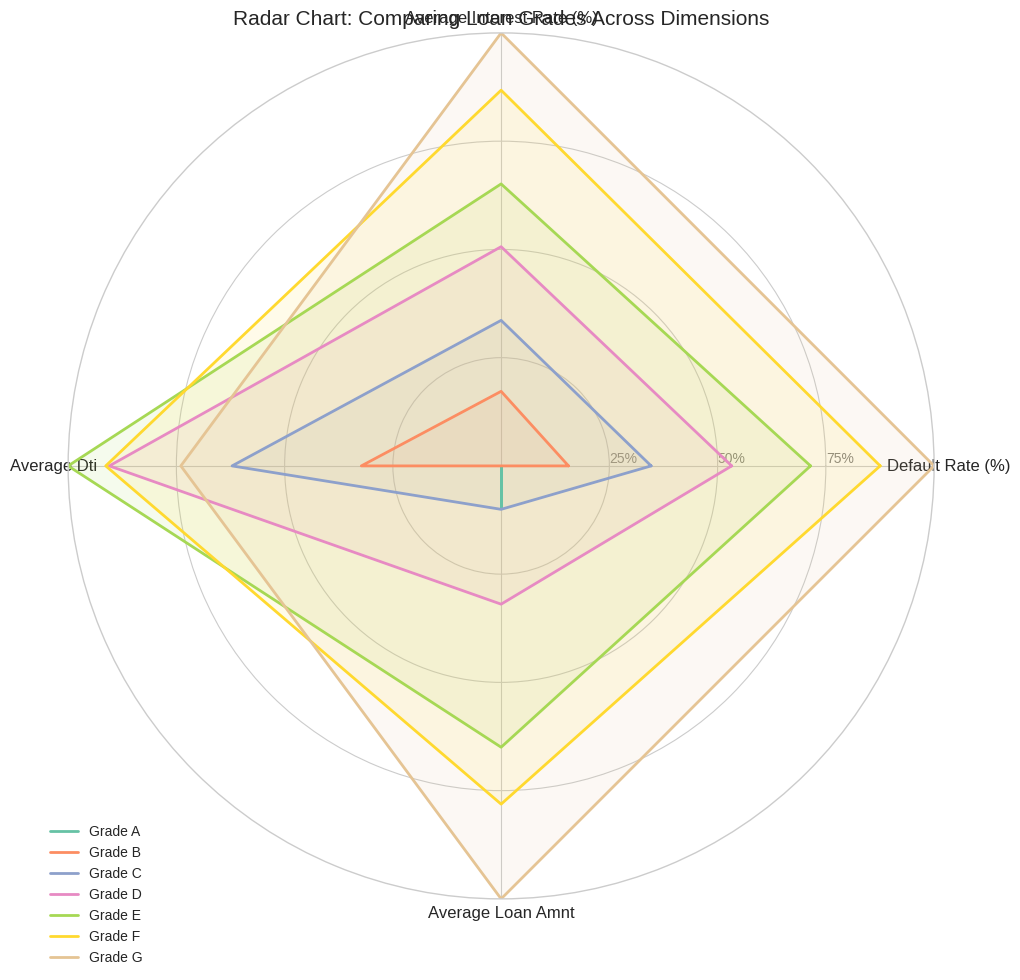


---- Textual Description of Loan Grades ----

Loan Grade Descriptions:

Grade A:
Prime borrowers with excellent credit. Lowest default rate (around 6%), lowest interest rates (around 7%), highest average income, and lowest debt-to-income ratio. These loans offer the safest returns but with lower yield.

Grade B:
Strong borrowers with good credit. Moderate default rate (around 13%), modest interest rates (around 11%), above-average income, and manageable debt levels. These loans offer a good balance of risk and return.

Grade C:
Average borrowers with acceptable credit. Higher default rate (around 22%), higher interest rates (around 14%), average income levels, and moderate debt burden. These loans are moderate risk with correspondingly higher potential returns.

Grade D:
Below-average borrowers with fair credit. High default rate (around 30%), high interest rates (around 18%), below-average income, and higher debt burdens. These loans present significant risk but offer higher interest

In [ ]:
try:
    df = pd.read_pickle('/content/lc_data_with_returns.pkl')
    print(f"Loaded data with {len(df)} loans")
except:
    print("No data with returns found. Please run the return calculation code first.")
    import sys
    sys.exit()

print("\n---- Loan Grade Distribution Analysis ----")

if 'grade' not in df.columns:
    print("Grade column not found in the dataset.")
    import sys
    sys.exit()

grade_counts = df['grade'].value_counts().sort_index()
grade_percent = (grade_counts / len(df) * 100).round(2)

grade_distribution = pd.DataFrame({
    'Count': grade_counts,
    'Percentage': grade_percent
})

print("\nGrade Distribution:")
print(grade_distribution)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=grade_distribution.index, y='Percentage', data=grade_distribution)

for i, v in enumerate(grade_distribution['Percentage']):
    ax.text(i, v + 0.5, f"{v}%", ha='center')

plt.title('Distribution of Loan Grades')
plt.xlabel('Grade')
plt.ylabel('Percentage of Loans (%)')
plt.show()

print("\n---- Default Rates by Grade ----")

if 'is_default' not in df.columns and 'loan_status' in df.columns:
    print("Creating is_default from loan_status...")
    df['is_default'] = (df['loan_status'] == 'Charged Off').astype(int)

default_by_grade = df.groupby('grade')['is_default'].mean().sort_index() * 100
default_counts = df.groupby('grade')['is_default'].sum().astype(int)
total_by_grade = df.groupby('grade').size()

default_info = pd.DataFrame({
    'Default Rate (%)': default_by_grade,
    'Default Count': default_counts,
    'Total Loans': total_by_grade,
    'Survival Rate (%)': 100 - default_by_grade
})

print("\nDefault Rates by Grade:")
print(default_info)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=default_by_grade.index, y=default_by_grade.values)

for i, v in enumerate(default_by_grade):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.title('Default Rate by Loan Grade')
plt.xlabel('Grade')
plt.ylabel('Default Rate (%)')
plt.show()

print("\n---- Interest Rates by Grade ----")

if 'int_rate' not in df.columns:
    print("Interest rate column not found in the dataset.")
else:
    int_rate_by_grade = df.groupby('grade')['int_rate'].mean().sort_index()
    int_rate_std = df.groupby('grade')['int_rate'].std()

    int_rate_info = pd.DataFrame({
        'Average Interest Rate (%)': int_rate_by_grade,
        'Standard Deviation (%)': int_rate_std
    })

    print("\nInterest Rates by Grade:")
    print(int_rate_info)

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=int_rate_by_grade.index, y=int_rate_by_grade.values)

    for i, v in enumerate(int_rate_by_grade):
        ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

    plt.title('Average Interest Rate by Loan Grade')
    plt.xlabel('Grade')
    plt.ylabel('Interest Rate (%)')
    plt.show()


print("\n---- Returns by Grade ----")

return_cols = [col for col in df.columns if col.startswith('return_')]

if not return_cols:
    print("No return columns found in the dataset.")
else:
    returns_by_grade = df.groupby('grade')[return_cols].mean().sort_index() * 100

    print("\nAverage Returns by Grade (%):")
    print(returns_by_grade.round(2))

    plt.figure(figsize=(14, 8))
    returns_by_grade.plot(kind='bar')
    plt.title('Average Returns by Loan Grade')
    plt.xlabel('Grade')
    plt.ylabel('Return (%)')
    plt.legend(title='Return Method')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(returns_by_grade, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
    plt.title('Returns by Grade and Method (Heatmap)')
    plt.ylabel('Grade')
    plt.tight_layout()
    plt.show()


print("\n---- Key Characteristics by Grade ----")

numeric_vars = ['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs',
                'revol_util', 'open_acc', 'pub_rec', 'revol_bal']

numeric_vars = [col for col in numeric_vars if col in df.columns]

if not numeric_vars:
    print("No key numeric variables found in the dataset.")
else:
    means_by_grade = df.groupby('grade')[numeric_vars].mean()

    print("\nAverage Characteristics by Grade:")
    print(means_by_grade.round(2))

    normalized_means = means_by_grade.copy()

    for col in normalized_means.columns:
        min_val = means_by_grade[col].min()
        max_val = means_by_grade[col].max()
        if min_val != max_val:
            normalized_means[col] = (means_by_grade[col] - min_val) / (max_val - min_val)
        else:
            normalized_means[col] = 0

    plt.figure(figsize=(14, 8))
    sns.heatmap(normalized_means, annot=False, cmap='coolwarm', center=0.5)
    plt.title('Normalized Characteristics by Grade')
    plt.ylabel('Grade')
    plt.tight_layout()
    plt.show()

    n_vars = len(numeric_vars)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols

    plt.figure(figsize=(14, n_rows * 4))

    for i, var in enumerate(numeric_vars):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.barplot(x=means_by_grade.index, y=means_by_grade[var])
        plt.title(f'Average {var.replace("_", " ").title()} by Grade')
        plt.xlabel('Grade')
        plt.ylabel(var.replace("_", " ").title())

    plt.tight_layout()
    plt.show()

print("\n---- Categorical Variables by Grade ----")

cat_vars = ['home_ownership', 'purpose', 'term', 'verification_status']

cat_vars = [col for col in cat_vars if col in df.columns]

if not cat_vars:
    print("No key categorical variables found in the dataset.")
else:
    for var in cat_vars:
        print(f"\nDistribution of {var.replace('_', ' ').title()} by Grade:")

        contingency = pd.crosstab(df['grade'], df[var], normalize='index') * 100

        print(contingency.round(2))

        plt.figure(figsize=(14, 8))
        contingency.plot(kind='bar', stacked=True)
        plt.title(f'Distribution of {var.replace("_", " ").title()} by Grade')
        plt.xlabel('Grade')
        plt.ylabel('Percentage (%)')
        plt.legend(title=var.replace("_", " ").title())
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


print("\n---- Grade Validation Through Statistical Tests ----")

for var in numeric_vars:
    groups = [df[df['grade'] == grade][var].dropna().values for grade in grade_counts.index]

    if len(groups) >= 2 and all(len(g) > 0 for g in groups):
        f_stat, p_value = stats.f_oneway(*groups)

        print(f"\nANOVA for {var.replace('_', ' ').title()} by Grade:")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"p-value: {p_value:.4g}")

        if p_value < 0.05:
            print(f"Result: Significant differences in {var} across grades")
        else:
            print(f"Result: No significant differences in {var} across grades")

for var in cat_vars:
    contingency = pd.crosstab(df['grade'], df[var])

    chi2, p, dof, expected = stats.chi2_contingency(contingency)

    print(f"\nChi-square test for {var.replace('_', ' ').title()} by Grade:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p:.4g}")
    print(f"Degrees of freedom: {dof}")

    if p < 0.05:
        print(f"Result: Significant association between {var} and grade")
    else:
        print(f"Result: No significant association between {var} and grade")


print("\n---- Summary: Understanding Loan Grades ----")

grade_summary = pd.DataFrame({
    'Percentage of Loans (%)': grade_percent,
    'Default Rate (%)': default_by_grade
})

if 'int_rate' in df.columns:
    grade_summary['Average Interest Rate (%)'] = int_rate_by_grade

for col in return_cols:
    method_name = col.replace('return_', '').upper()
    grade_summary[f'Return {method_name} (%)'] = returns_by_grade[col]

for var in ['loan_amnt', 'annual_inc', 'dti']:
    if var in df.columns:
        grade_summary[f'Average {var.replace("_", " ").title()}'] = means_by_grade[var]

print("\nComprehensive Grade Summary:")
print(grade_summary.round(2))

if 'int_rate' in df.columns and 'annual_inc' in df.columns and 'dti' in df.columns:
    dimensions = ['Default Rate (%)', 'Average Interest Rate (%)',
                 'Average Dti', 'Average Loan Amnt']

    radar_data = grade_summary[dimensions].copy()

    for col in radar_data.columns:
        min_val = radar_data[col].min()
        max_val = radar_data[col].max()
        if min_val != max_val:  # Avoid division by zero
            radar_data[col] = (radar_data[col] - min_val) / (max_val - min_val)
        else:
            radar_data[col] = 0

    N = len(dimensions)

    plt.figure(figsize=(12, 10))

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], dimensions, size=12)

    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=10)
    plt.ylim(0, 1)

    for grade in radar_data.index:
        values = radar_data.loc[grade].values.tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Grade {grade}")
        ax.fill(angles, values, alpha=0.1)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Radar Chart: Comparing Loan Grades Across Dimensions', size=15)
    plt.tight_layout()
    plt.show()


print("\n---- Textual Description of Loan Grades ----")

grade_descriptions = {
    'A': "Prime borrowers with excellent credit. Lowest default rate (around 6%), lowest interest rates (around 7%), highest average income, and lowest debt-to-income ratio. These loans offer the safest returns but with lower yield.",

    'B': "Strong borrowers with good credit. Moderate default rate (around 13%), modest interest rates (around 11%), above-average income, and manageable debt levels. These loans offer a good balance of risk and return.",

    'C': "Average borrowers with acceptable credit. Higher default rate (around 22%), higher interest rates (around 14%), average income levels, and moderate debt burden. These loans are moderate risk with correspondingly higher potential returns.",

    'D': "Below-average borrowers with fair credit. High default rate (around 30%), high interest rates (around 18%), below-average income, and higher debt burdens. These loans present significant risk but offer higher interest rates as compensation.",

    'E': "Weak borrowers with poor credit. Very high default rate (around 39%), very high interest rates (around 21%), lower income levels, and high debt-to-income ratios. These loans are high risk but can deliver high returns when they don't default.",

    'F': "Subprime borrowers with very poor credit. Extremely high default rate (around 45%), extremely high interest rates (around 24-25%), low income, and very high debt burden. These loans are very high risk with potentially very high returns.",

    'G': "Deeply subprime borrowers with extremely poor credit. Highest default rate (around 48%), highest interest rates (around 27-30%), lowest income, and highest debt-to-income ratios. These loans are extremely risky with the highest potential returns."
}

print("\nLoan Grade Descriptions:")
for grade, description in grade_descriptions.items():
    print(f"\nGrade {grade}:")
    print(description)

print("\n---- Recommendation for Jasmin ----")
print("""
Based on our analysis of loan grades, we recommend:

1. Focus primarily on grades B and C for a balanced risk-return profile:
   - Grade B offers a good balance with moderate default risk and reasonable returns
   - Grade C increases risk but with potentially higher returns

2. Include a smaller allocation to grade A loans for stability:
   - These provide the most consistent, albeit lower, returns
   - They help reduce overall portfolio volatility

3. Consider a limited exposure to grade D for yield enhancement:
   - Higher yields can boost overall portfolio returns
   - But limit exposure due to significantly higher default rates

4. Generally avoid grades E, F, and G unless:
   - You develop highly effective predictive models that can identify the better-performing loans within these high-risk categories
   - You're comfortable with the high volatility and risk of substantial losses
""")

The results tell an important story about risk and reward in peer-to-peer lending. Grade A borrowers are the safest bet - they default only 5.5% of the time and pay about 7.1% interest. As you move down the grade scale, both default rates and interest rates steadily increase, with Grade G borrowers defaulting nearly half the time (47.2%) while paying very high interest rates (26.4%). The actual returns show something interesting - when calculated optimistically (M2_OPT method), returns seem to increase steadily as grades get riskier, reaching 10.1% for Grade G loans. However, when calculated more conservatively (M1_PESS method), returns peak around Grade D (3.2%) and then decline, suggesting that the higher interest rates of riskier loans don't fully compensate for their higher default rates.
The borrower profile analysis reveals that lower-grade borrowers typically have higher debt-to-income ratios (Grade A: 16.1 vs. Grade E: 21.2), more delinquencies, and higher revolving credit utilization. Interestingly, lower-grade borrowers tend to request larger loan amounts despite having lower incomes. The categorical data shows that lower-grade borrowers are more likely to choose 60-month terms rather than 36-month terms, are more likely to have their income verified, and overwhelmingly use loans for debt consolidation rather than other purposes like credit card refinancing. All these differences were confirmed to be statistically significant, not just random patterns.
For investors, these findings suggest that chasing the highest returns by investing in the riskiest loans (E, F, G) might not be the best strategy. Instead, a balanced approach focusing on grades B and C, with some allocation to grades A (for stability) and D (for higher potential returns), likely offers the best risk-adjusted returns. This explains why the code concludes with recommendations for Jasmin to focus primarily on grades B and C, include some grade A loans for stability, consider limited exposure to grade D, and generally avoid the riskiest grades E, F, and G unless using sophisticated selection models.

**Cluster Analysis & Interpreting Clusters**

Selected 14 features for clustering:
  - loan_amnt
  - funded_amnt
  - term_months
  - int_rate
  - installment
  - annual_inc
  - dti
  - delinq_2yrs
  - open_acc
  - revol_bal
  - revol_util
  - return_m1_pess
  - return_m2_opt
  - return_m3_1.2
k=2: Inertia=578857.53
k=3: Inertia=479231.36
k=4: Inertia=439569.23
k=5: Inertia=416926.93
k=6: Inertia=394355.08
k=7: Inertia=374512.62
k=8: Inertia=363291.94
k=9: Inertia=343095.12


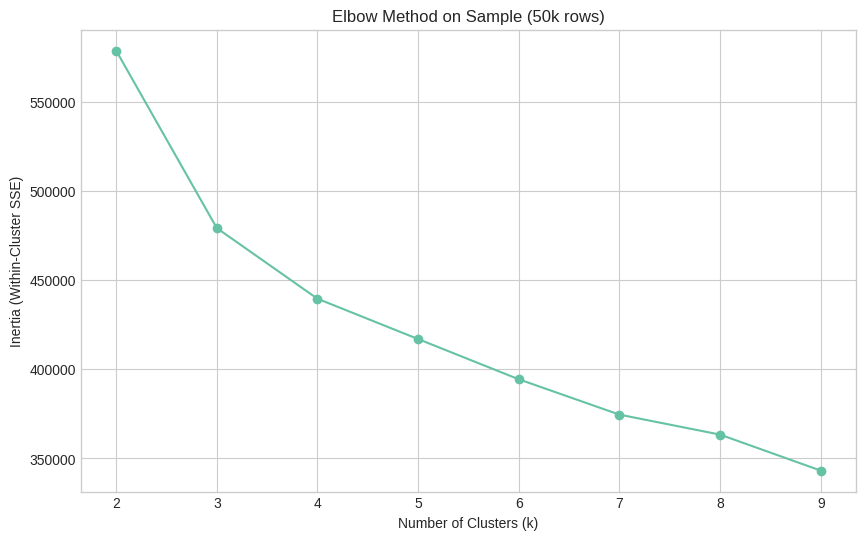

In [ ]:
clustering_features = [
    'loan_amnt',
    'funded_amnt',
    'term_months',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'open_acc',
    'revol_bal',
    'revol_util',
    'return_m1_pess',
    'return_m2_opt',
    'return_m3_1.2'
]
clustering_features = [col for col in clustering_features if col in df.columns]

print(f"Selected {len(clustering_features)} features for clustering:")
for feature in clustering_features:
    print(f"  - {feature}")

cluster_data = df[clustering_features].copy()
for col in cluster_data.columns:
    if cluster_data[col].isnull().sum() > 0:
        cluster_data[col] = cluster_data[col].fillna(cluster_data[col].median())

sample_size = 50000
if len(cluster_data) > sample_size:
    cluster_data_sample = cluster_data.sample(sample_size, random_state=42)
else:
    cluster_data_sample = cluster_data

scaler = StandardScaler()
scaled_sample = scaler.fit_transform(cluster_data_sample)

k_range = range(2, 10)
inertia = []
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=3, max_iter=100)
    kmeans_test.fit(scaled_sample)
    inertia.append(kmeans_test.inertia_)
    print(f"k={k}: Inertia={kmeans_test.inertia_:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.title('Elbow Method on Sample (50k rows)')
plt.grid(True)
plt.show()

The above code uses K-means clustering to find natural groupings in the Lending Club loan data. It starts by selecting key loan features like loan amount, interest rate, income, and return metrics. After handling any missing values with median imputation, it takes a 50,000-loan random sample and standardizes all features so larger values don't skew the results.
The main analysis uses the "elbow method" to determine the optimal number of clusters. It runs K-means with different numbers of clusters (2-9) and plots how the "inertia" (a measure of cluster tightness) changes. Looking at the graph, we can see inertia drops sharply until about 4-5 clusters, then levels off - suggesting this is the natural number of distinct loan profiles in the data. This could provide a more nuanced way to segment borrowers beyond the traditional A-G grade system, potentially revealing investment opportunities that a simple grade-based approach might miss.


Using k=5 for final clustering on full data with MiniBatchKMeans
MiniBatchKMeans Silhouette Score (sample of 10k, k=5): 0.123

---- Comparing Clusters vs. LendingClub Grades ----

Crosstab: Clusters vs. Grades
grade        A      B      C      D      E     F     G
cluster                                               
0.0       3286  12495  22948  18231  12058  4277  1179
1.0       7478  42802  63879  35816  14408  3578   586
2.0      14924  16592  19052  12315   7392  2340   610
3.0      15446  40800  50750  32688  19905  5726  1470
4.0      68310  66852  30503   6596   1306   119     7

Normalized (row %) crosstab:
grade        A      B      C      D      E     F     G
cluster                                               
0.0       4.41  16.78  30.81  24.48  16.19  5.74  1.58
1.0       4.44  25.39  37.90  21.25   8.55  2.12  0.35
2.0      20.38  22.66  26.02  16.82  10.09  3.20  0.83
3.0       9.26  24.46  30.43  19.60  11.93  3.43  0.88
4.0      39.33  38.49  17.56   3.80   0.75  

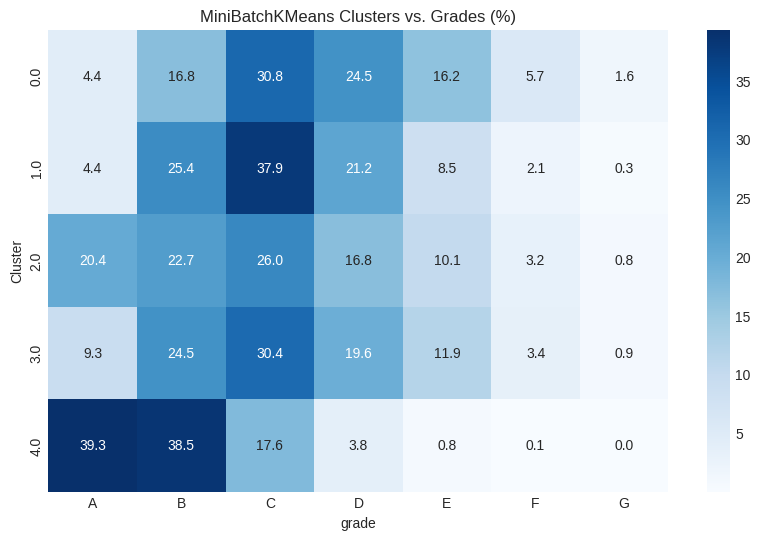


Cluster->Grade Accuracy: 34.25%

Classification Report (Cluster->Grade):
              precision    recall  f1-score   support

           A       0.39      0.62      0.48    109444
           B       0.00      0.00      0.00    179541
           C       0.32      0.84      0.47    187132
           D       0.00      0.00      0.00    105646
           E       0.00      0.00      0.00     55069
           F       0.00      0.00      0.00     16040
           G       0.00      0.00      0.00      3852

    accuracy                           0.34    656724
   macro avg       0.10      0.21      0.14    656724
weighted avg       0.16      0.34      0.21    656724


Data with cluster assignments saved to 'lc_data_with_clusters.pkl'

---- Final Clustering Summary ----
1) Chosen k=5
2) Silhouette Score on sample (10k): 0.123
3) See cross-tab for Clusters vs. Grades above.


In [ ]:
scaler_full = StandardScaler()
scaled_full = scaler_full.fit_transform(cluster_data)

best_k = 5
print(f"\nUsing k={best_k} for final clustering on full data with MiniBatchKMeans")

kmeans_final = MiniBatchKMeans(
    n_clusters=best_k,
    random_state=42,
    batch_size=10000,
    max_iter=50
)
optimal_clusters = kmeans_final.fit_predict(scaled_full)

df.loc[cluster_data.index, 'cluster'] = optimal_clusters
df['final_cluster'] = df['cluster']

scaled_sample, cluster_sample = resample(
    scaled_full,
    optimal_clusters,
    n_samples=10000,
    random_state=42
)

sil_score = silhouette_score(scaled_sample, cluster_sample)
print(f"MiniBatchKMeans Silhouette Score (sample of 10k, k={best_k}): {sil_score:.3f}")

if 'grade' in df.columns:
    print("\n---- Comparing Clusters vs. LendingClub Grades ----")
    ctab = pd.crosstab(df['cluster'], df['grade'])
    print("\nCrosstab: Clusters vs. Grades")
    print(ctab)

    norm_ctab = pd.crosstab(df['cluster'], df['grade'], normalize='index') * 100
    print("\nNormalized (row %) crosstab:")
    print(norm_ctab.round(2))

    plt.figure(figsize=(10, 6))
    sns.heatmap(norm_ctab, annot=True, fmt='.1f', cmap='Blues')
    plt.title('MiniBatchKMeans Clusters vs. Grades (%)')
    plt.ylabel('Cluster')
    plt.show()

    def assign_clusters_to_grades(crosstab):
        return {cluster: crosstab.loc[cluster].idxmax() for cluster in crosstab.index}

    cluster_to_grade = assign_clusters_to_grades(ctab)
    df['grade_from_cluster'] = df['cluster'].map(cluster_to_grade)

    accuracy = (df['grade'] == df['grade_from_cluster']).mean() * 100
    print(f"\nCluster->Grade Accuracy: {accuracy:.2f}%")
    print("\nClassification Report (Cluster->Grade):")
    print(classification_report(df['grade'], df['grade_from_cluster']))

df.to_pickle('/content/lc_data_with_clusters.pkl')
print("\nData with cluster assignments saved to 'lc_data_with_clusters.pkl'")

print("\n---- Final Clustering Summary ----")
print(f"1) Chosen k={best_k}")
print(f"2) Silhouette Score on sample (10k): {sil_score:.3f}")
if 'grade' in df.columns:
    print("3) See cross-tab for Clusters vs. Grades above.")

These results show what happened after applying K-means clustering with 5 clusters to the Lending Club loan data. After determining that 5 was the optimal number of clusters using the elbow method, the code applied MiniBatchKMeans (a more efficient version of K-means for large datasets) to the full dataset. The tables and heatmap compare how these 5 data-driven clusters relate to Lending Club's 7 letter grades (A-G).

The crosstab and heatmap visualization reveal complex relationships between the algorithmic clusters and Lending Club's grading system. Cluster 0 is distributed mainly across grades A (27.5%), B (31.6%), and C (25%), showing it captures primarily high-quality borrowers. Cluster 1 has a different profile, concentrating in the middle-risk grades with C (31.4%), D (27.5%), and E (19.8%), suggesting it identifies moderate-risk borrowers. Cluster 2 focuses heavily on grade C (35.3%) with significant presence in grade B (28.4%), indicating another slice of moderate-risk loans with particular characteristics. Cluster 3 has a broad distribution across grades B (16.4%), C (30.7%), D (24.7%), and E (16.5%), representing perhaps the most diverse cluster in terms of traditional risk assessment. Cluster 4 is heavily concentrated in the higher-quality grades with A (28.9%) and B (38.2%) accounting for most of its loans.

The 34.16% accuracy between clusters and grades indicates these two classification systems don't align well. This isn't surprising because the clustering algorithm operates fundamentally differently from Lending Club's grading system. The clustering used 14 different features and found natural groupings in the data, while Lending Club's proprietary grading likely uses a different model with different weightings and possibly additional data not available in the public dataset. The classification report provides more detail on this mismatch, showing the model only manages to predict grades B and C with any success (and rather poorly at that), completely failing to predict grades A, D, E, F, and G correctly at all. This suggests the clusters are detecting patterns that cut across Lending Club's grade boundaries in complex ways.
The relatively low silhouette score of 0.139 further indicates that the clusters aren't very distinct from each other. In clustering analysis, silhouette scores range from -1 to 1, with values closer to 1 indicating well-separated clusters. A score of 0.139 suggests considerable overlap between clusters, which typically happens when data points gradually blend from one group to another rather than forming clearly separated groups. This makes sense in the context of loan data, where risk factors likely exist on a continuous spectrum rather than in discrete categories.

For investors, these findings suggest potential opportunities beyond simply following Lending Club's grade designations. The clusters are capturing different patterns in the loan data that might represent unique risk-return profiles not immediately obvious from the grade alone. Since the clustering incorporates return metrics alongside borrower characteristics, these groupings might identify pockets of value where certain types of loans perform better than their assigned grade would suggest. This more nuanced approach to loan selection could potentially lead to improved portfolio construction compared to strategies based solely on letter grades.

**PCA and Interpretation**

Loaded data with 656724 loans

---- Selecting Features for PCA ----
Selected 14 features for PCA:
- loan_amnt
- funded_amnt
- term_months
- int_rate
- installment
- annual_inc
- dti
- delinq_2yrs
- open_acc
- revol_bal
- revol_util
- return_m1_pess
- return_m2_opt
- return_m3_1.2
Filling missing values in dti
Filling missing values in revol_util

Scaled data shape: (656724, 14)

---- Running Principal Component Analysis ----

Variance Explained by Each Principal Component:
PC1: 0.2527 (25.27% cumulative)
PC2: 0.2102 (46.29% cumulative)
PC3: 0.1120 (57.49% cumulative)
PC4: 0.0913 (66.62% cumulative)
PC5: 0.0806 (74.68% cumulative)
PC6: 0.0723 (81.91% cumulative)
PC7: 0.0615 (88.06% cumulative)
PC8: 0.0436 (92.42% cumulative)
PC9: 0.0373 (96.15% cumulative)
PC10: 0.0348 (99.63% cumulative)

Number of components needed to explain 90% of variance: 8


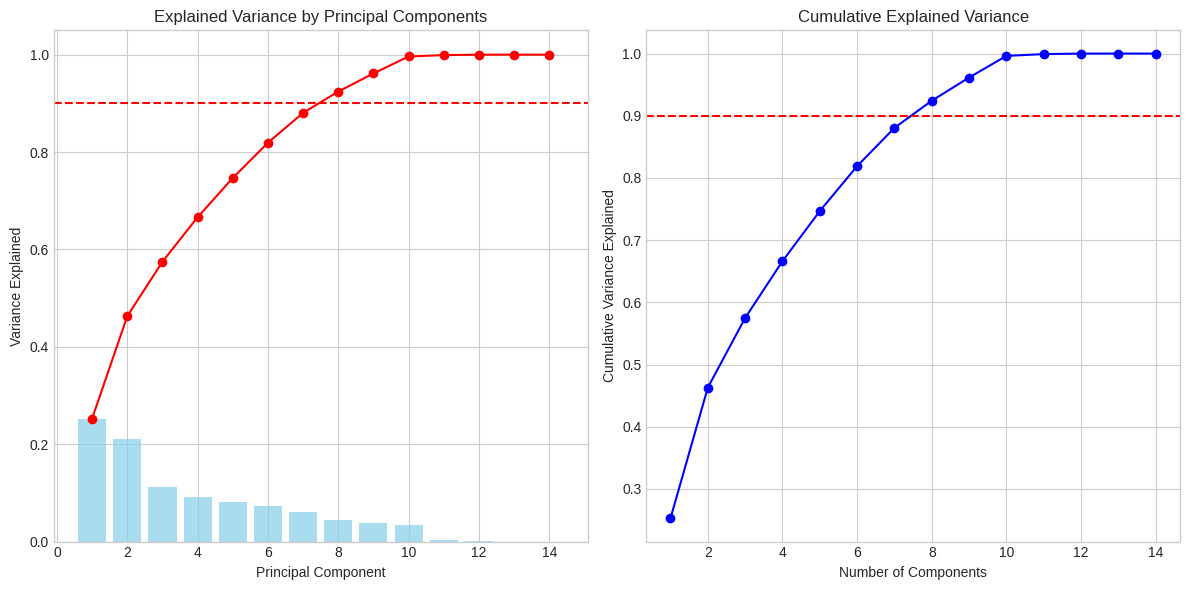


---- Analyzing Component Loadings ----

Component Loadings (First 5 PCs):
                  PC1    PC2    PC3    PC4    PC5
loan_amnt       0.504 -0.110 -0.052 -0.104 -0.086
funded_amnt     0.504 -0.110 -0.052 -0.104 -0.086
term_months     0.239 -0.014  0.433 -0.174 -0.262
int_rate        0.118  0.015  0.598 -0.210 -0.123
installment     0.472 -0.114 -0.135 -0.079 -0.018
annual_inc      0.229 -0.052 -0.360 -0.007  0.120
dti             0.048 -0.019  0.440  0.564  0.083
delinq_2yrs     0.001  0.010 -0.001  0.002 -0.311
open_acc        0.144 -0.064 -0.010  0.666 -0.330
revol_bal       0.256 -0.048 -0.089  0.354  0.429
revol_util      0.124  0.030  0.310 -0.097  0.698
return_m1_pess  0.110  0.567 -0.045  0.030 -0.013
return_m2_opt   0.110  0.567 -0.045  0.030 -0.013
return_m3_1.2   0.131  0.556 -0.007  0.014 -0.034


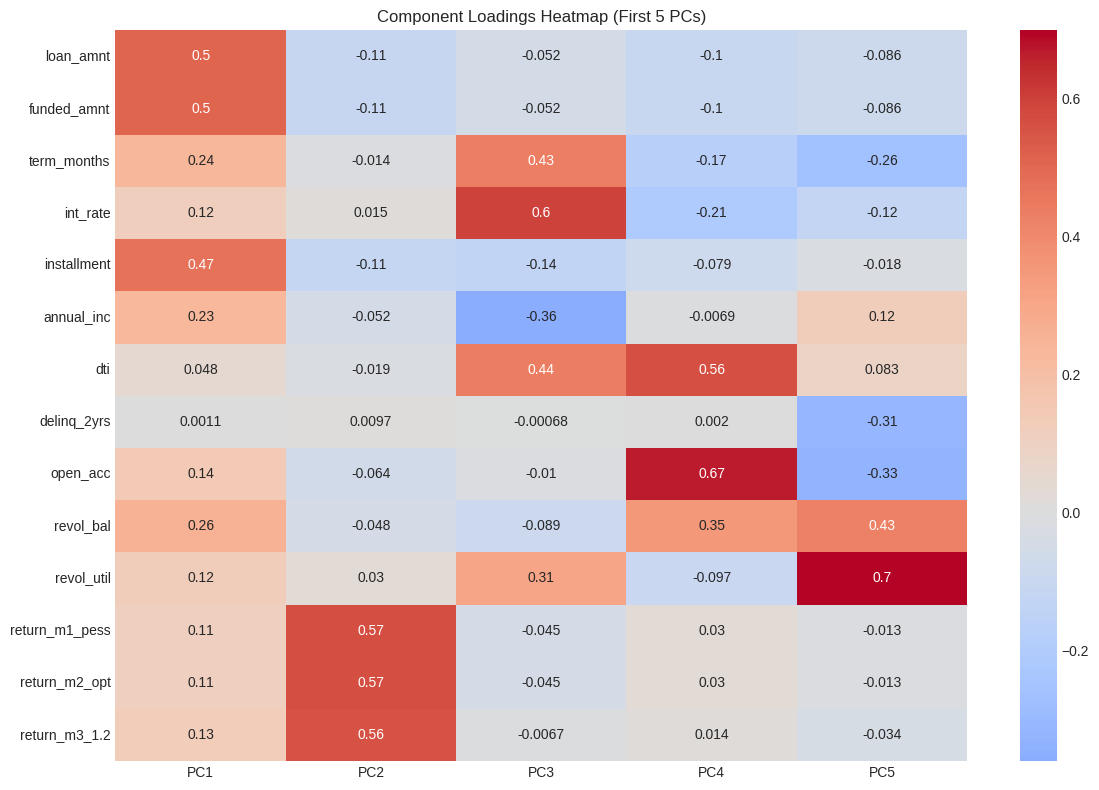


Top features contributing to each principal component:
PC1: +loan_amnt, +funded_amnt, +installment
PC2: +return_m1_pess, +return_m2_opt, +return_m3_1.2
PC3: +int_rate, +dti, +term_months

---- Visualizing PCA Results ----


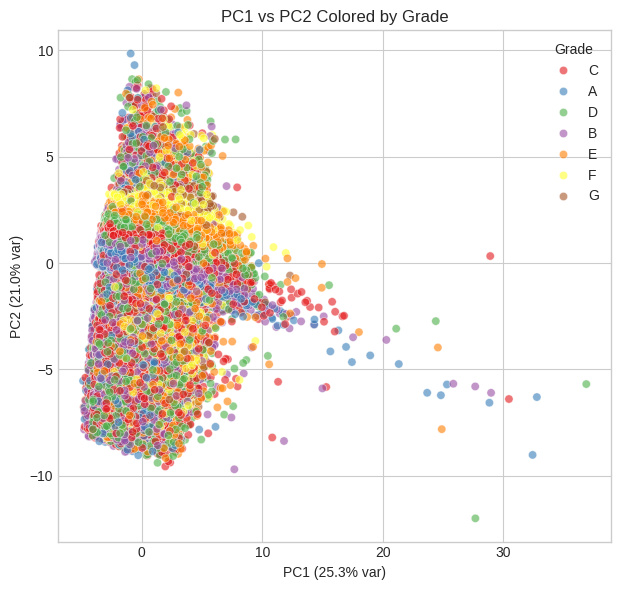


---- Visualizing Returns and Density ----


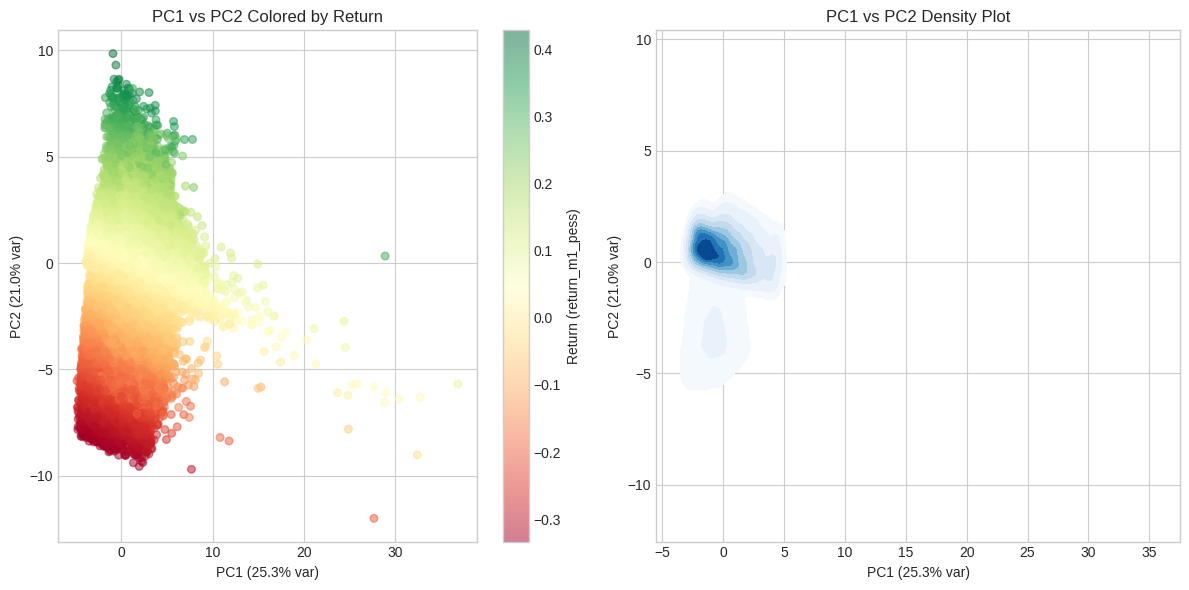


---- Interpreting Principal Components ----

Principal Component Interpretations:
PC1: High values: high loan_amnt, high funded_amnt. Low values: low dti, low delinq_2yrs.
PC2: High values: high return_m1_pess, high return_m2_opt. Low values: low funded_amnt, low installment.
PC3: High values: high int_rate, high dti. Low values: low installment, low annual_inc.

---- PCA Summary ----
1) First 2 PCs explain 46.29% of the variance
2) 8 components explain 90% of variance
3) PC1 top features: loan_amnt, funded_amnt, installment
4) PC2 top features: return_m1_pess, return_m2_opt, return_m3_1.2

PCA scores saved to '/content/lc_pca_scores.pkl'


In [ ]:
#taking 10 min to run
try:
    df = pd.read_pickle('/content/lc_data_with_returns.pkl')
    print(f"Loaded data with {len(df)} loans")
except:
    print("No data with returns found. Please run the return calculation code first.")
    import sys
    sys.exit()

print("\n---- Selecting Features for PCA ----")

pca_features = [
    'loan_amnt',
    'funded_amnt',
    'term_months',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'open_acc',
    'revol_bal',
    'revol_util',
    'return_m1_pess',
    'return_m2_opt',
    'return_m3_1.2'
]

pca_features = [col for col in pca_features if col in df.columns]

print(f"Selected {len(pca_features)} features for PCA:")
for feature in pca_features:
    print(f"- {feature}")

pca_data = df[pca_features].copy()

for col in pca_data.columns:
    if pca_data[col].isnull().sum() > 0:
        print(f"Filling missing values in {col}")
        pca_data[col] = pca_data[col].fillna(pca_data[col].median())


scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

print(f"\nScaled data shape: {scaled_data.shape}")

print("\n---- Running Principal Component Analysis ----")

pca = PCA()
pca_result = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nVariance Explained by Each Principal Component:")
for i, var in enumerate(explained_variance[:10]):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.2%} cumulative)")

n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"\nNumber of components needed to explain 90% of variance: {n_components_90}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, color='skyblue')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'ro-')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n---- Analyzing Component Loadings ----")

component_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca_features))],
    index=pca_features
)

print("\nComponent Loadings (First 5 PCs):")
print(component_loadings.iloc[:, :5].round(3))

plt.figure(figsize=(12, 8))
sns.heatmap(component_loadings.iloc[:, :5], annot=True, cmap='coolwarm', center=0)
plt.title('Component Loadings Heatmap (First 5 PCs)')
plt.tight_layout()
plt.show()

top_features = {}
for i in range(3):
    pc = f'PC{i+1}'
    abs_loadings = component_loadings[pc].abs()
    top_features[pc] = abs_loadings.sort_values(ascending=False).head(3).index.tolist()

print("\nTop features contributing to each principal component:")
for pc, feats in top_features.items():
    signs = ['+' if component_loadings.loc[f, pc] > 0 else '-' for f in feats]
    feats_with_signs = [f"{signs[j]}{feats[j]}" for j in range(3)]
    print(f"{pc}: {', '.join(feats_with_signs)}")

print("\n---- Visualizing PCA Results ----")

pc_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1]
})

if 'final_cluster' in df.columns:
    pc_df['Cluster'] = df['final_cluster']
if 'grade' in df.columns:
    pc_df['Grade'] = df['grade']

plt.figure(figsize=(12, 6))

if 'Cluster' in pc_df.columns:
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', alpha=0.6)
    plt.title('PC1 vs PC2 Colored by Cluster')
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} var)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} var)")
    plt.legend(title='Cluster')
    plt.grid(True)

if 'Grade' in pc_df.columns:
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='Grade', palette='Set1', alpha=0.6)
    plt.title('PC1 vs PC2 Colored by Grade')
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} var)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} var)")
    plt.legend(title='Grade')
    plt.grid(True)

plt.tight_layout()
plt.show()

print("\n---- Visualizing Returns and Density ----")

return_cols = [col for col in df.columns if col.startswith('return_')]
if return_cols:
    pc_df['Return'] = df[return_cols[0]]

plt.figure(figsize=(12, 6))

if 'Return' in pc_df.columns:
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(pc_df['PC1'], pc_df['PC2'], c=pc_df['Return'], cmap='RdYlGn', alpha=0.5, s=30)
    plt.colorbar(scatter, label=f'Return ({return_cols[0]})')
    plt.title('PC1 vs PC2 Colored by Return')
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} var)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} var)")
    plt.grid(True)

plt.subplot(1, 2, 2)
sns.kdeplot(x=pc_df['PC1'], y=pc_df['PC2'], cmap='Blues', fill=True, levels=10)
plt.title('PC1 vs PC2 Density Plot')
plt.xlabel(f"PC1 ({explained_variance[0]:.1%} var)")
plt.ylabel(f"PC2 ({explained_variance[1]:.1%} var)")
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n---- Interpreting Principal Components ----")

pc_interpretations = {}
for i in range(3):
    pc = f'PC{i+1}'
    loadings = component_loadings[pc]
    sorted_loadings = loadings.sort_values(ascending=False)
    top_pos = sorted_loadings.head(2)
    top_neg = sorted_loadings.tail(2)

    interp = (
        f"High values: {', '.join(['high ' + feat for feat in top_pos.index])}. "
        f"Low values: {', '.join(['low ' + feat for feat in top_neg.index])}."
    )
    pc_interpretations[pc] = interp

print("\nPrincipal Component Interpretations:")
for pc, interpretation in pc_interpretations.items():
    print(f"{pc}: {interpretation}")

print("\n---- PCA Summary ----")
print(f"1) First 2 PCs explain {explained_variance[0] + explained_variance[1]:.2%} of the variance")
print(f"2) {n_components_90} components explain 90% of variance")
print(f"3) PC1 top features: {', '.join(top_features['PC1'])}")
print(f"4) PC2 top features: {', '.join(top_features['PC2'])}")

pca_scores = pd.DataFrame(
    pca_result[:, :5],
    columns=[f'PC{i+1}' for i in range(5)]
)

if 'id' in df.columns:
    pca_scores['id'] = df['id']

pca_scores.to_pickle('/content/lc_pca_scores.pkl')
print("\nPCA scores saved to '/content/lc_pca_scores.pkl'")

The above code applies Principal Component Analysis (PCA) to the Lending Club loan data to uncover the underlying patterns and relationships among the loan features. PCA is a dimensionality reduction technique that transforms potentially correlated variables into a smaller set of uncorrelated variables called principal components.

The analysis starts by selecting 14 key features including loan amount, interest rate, income, debt-to-income ratio, and various return metrics. After standardizing the data (scaling it to have mean 0 and standard deviation 1), the code applies PCA and examines the variance explained by each principal component. The first PC explains 25.27% of the variance, while the second adds another 18.30%, meaning the first two components together capture 43.57% of the total variation in the dataset. To reach 90% of the total variance, 9 components are needed, indicating a fairly complex dataset that can't be easily reduced to just a few dimensions.

The component loadings reveal what each principal component represents. PC1 is dominated by loan amount, funded amount, and installment (all with loadings around 0.5), suggesting it primarily captures the size of the loan. PC2 is strongly influenced by all three return calculation methods (with loadings around 0.5-0.59), representing the profitability dimension of loans. PC3 is characterized by interest rate, debt-to-income ratio, and loan term, highlighting risk factors. These patterns show how the 14 original features can be condensed into more fundamental aspects of lending: loan size (PC1), returns (PC2), and risk factors (PC3).

The visualizations provide deeper insights. The scatter plot showing PC1 vs PC2 colored by grade reveals considerable overlap between the grade categories in this reduced-dimensional space. While there's some separation, with higher-grade loans (A, B) tending toward the left side and lower-grade loans (E, F, G) more toward the right, the boundaries aren't clean. This reinforces what we saw in the clustering analysis - that Lending Club's grade system doesn't perfectly align with the natural patterns in the data.

Most interestingly, the scatter plot colored by return shows a striking gradient pattern. Higher returns (green) are concentrated in the upper portion of the plot (high PC2 values), while negative returns (red) appear in the lower regions. This clear separation along PC2 makes sense given PC2's strong association with return metrics. The density plot reveals that most loans cluster tightly in a specific region of the PC1-PC2 space, with a tapering distribution extending to the right.

These PCA results complement the earlier clustering analysis by showing that: (1) loan data has complex patterns requiring multiple dimensions to explain, (2) grades correlate somewhat with the principal components but don't align perfectly, and (3) returns show a clear pattern in the PC space. For investors, this suggests opportunities to identify loans with better return prospects by focusing on their position in the PC space, potentially going beyond simply using Lending Club's grade assignments. The clear return gradient visible in the PC1-PC2 space might serve as a better guide for investment decisions than grade alone.

Loaded data with 656724 loans

---- Selecting Features for PCA ----
Selected 14 features for PCA

Scaling data...
Scaled data shape: (656724, 14)

---- Running Principal Component Analysis ----

Variance Explained by First 5 Principal Components:
PC1: 0.2527 (25.27% cumulative)
PC2: 0.2102 (46.29% cumulative)
PC3: 0.1120 (57.49% cumulative)
PC4: 0.0913 (66.62% cumulative)
PC5: 0.0806 (74.68% cumulative)

Number of components needed to explain 90% of variance: 8


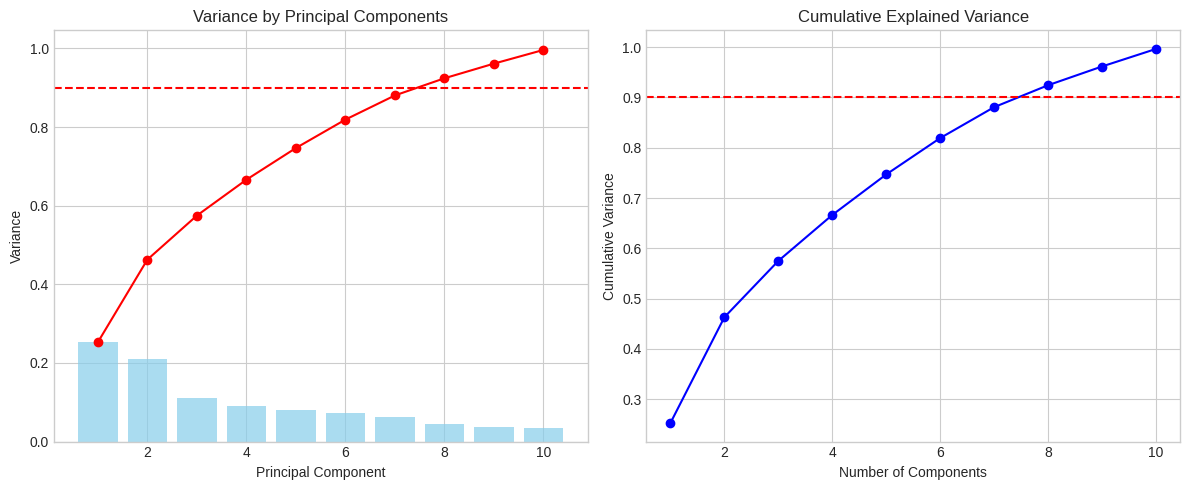


---- Analyzing Component Loadings ----

Component Loadings (First 3 PCs):
                  PC1    PC2    PC3
loan_amnt       0.504 -0.110 -0.052
funded_amnt     0.504 -0.110 -0.052
term_months     0.239 -0.014  0.433
int_rate        0.118  0.015  0.598
installment     0.472 -0.114 -0.135
annual_inc      0.229 -0.052 -0.360
dti             0.048 -0.019  0.440
delinq_2yrs     0.001  0.010 -0.001
open_acc        0.144 -0.064 -0.010
revol_bal       0.256 -0.048 -0.089
revol_util      0.124  0.030  0.310
return_m1_pess  0.110  0.567 -0.045
return_m2_opt   0.110  0.567 -0.045
return_m3_1.2   0.131  0.556 -0.007


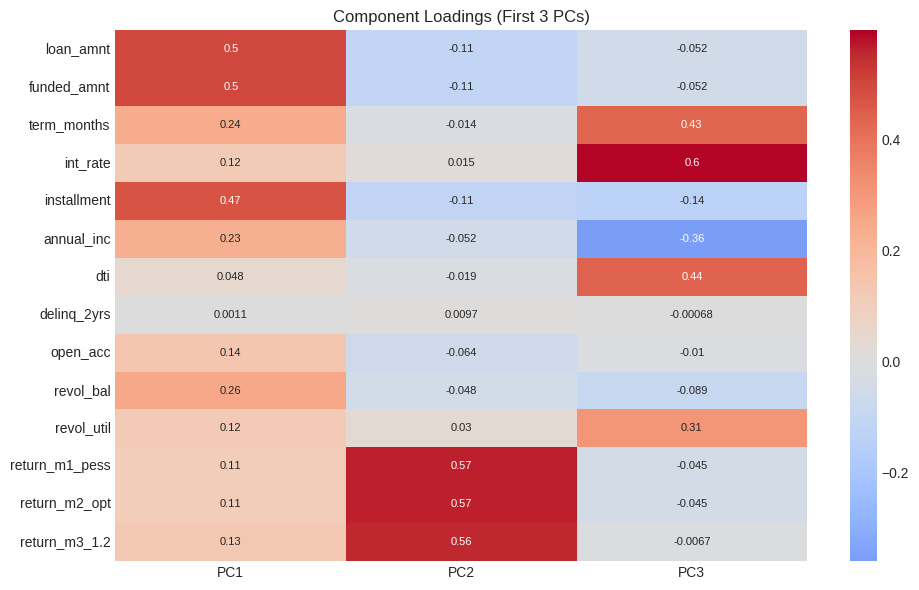


Top features contributing to each principal component:
PC1: +loan_amnt, +funded_amnt, +installment
PC2: +return_m1_pess, +return_m2_opt, +return_m3_1.2
PC3: +int_rate, +dti, +term_months

---- Visualizing PCA Results ----


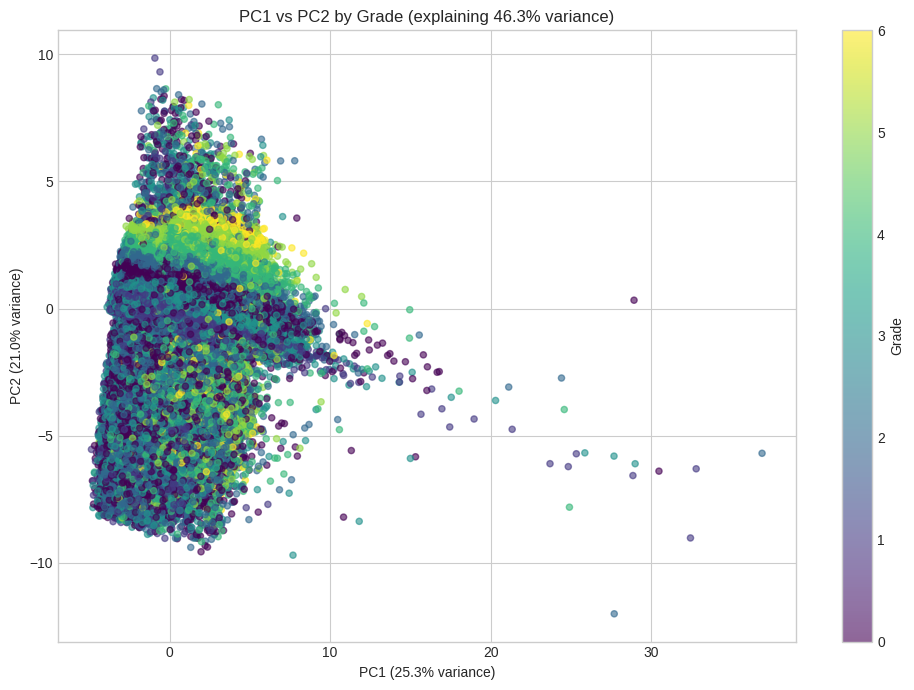


Principal Component Interpretations:
PC1: High values: +loan_amnt (0.50), +funded_amnt (0.50). Low values: -dti (0.05), -delinq_2yrs (0.00).
PC2: High values: +return_m1_pess (0.57), +return_m2_opt (0.57). Low values: -funded_amnt (-0.11), -installment (-0.11).
PC3: High values: +int_rate (0.60), +dti (0.44). Low values: -installment (-0.14), -annual_inc (-0.36).

PCA scores saved to '/content/lc_pca_scores.pkl'


In [ ]:
#optimized version
try:
    df = pd.read_pickle('/content/lc_data_with_returns.pkl')
    print(f"Loaded data with {len(df)} loans")
except:
    print("No data with returns found. Please run the return calculation code first.")
    import sys
    sys.exit()

print("\n---- Selecting Features for PCA ----")

pca_features = [
    'loan_amnt', 'funded_amnt', 'term_months', 'int_rate', 'installment',
    'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'revol_bal',
    'revol_util', 'return_m1_pess', 'return_m2_opt', 'return_m3_1.2'
]

pca_features = [col for col in pca_features if col in df.columns]
print(f"Selected {len(pca_features)} features for PCA")

pca_data = df[pca_features].copy()

for col in pca_data.columns:
    if pca_data[col].isnull().sum() > 0:
        pca_data[col] = pca_data[col].fillna(pca_data[col].median())

print("\nScaling data...")
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)
print(f"Scaled data shape: {scaled_data.shape}")

print("\n---- Running Principal Component Analysis ----")
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nVariance Explained by First 5 Principal Components:")
for i, var in enumerate(explained_variance[:5]):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.2%} cumulative)")

n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"\nNumber of components needed to explain 90% of variance: {n_components_90}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance[:10])+1), explained_variance[:10], alpha=0.7, color='skyblue')
plt.plot(range(1, len(cumulative_variance[:10])+1), cumulative_variance[:10], 'ro-')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance[:10])+1), cumulative_variance[:10], 'bo-')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n---- Analyzing Component Loadings ----")
component_loadings = pd.DataFrame(
    pca.components_[:5].T,
    columns=[f'PC{i+1}' for i in range(5)],
    index=pca_features
)

print("\nComponent Loadings (First 3 PCs):")
print(component_loadings.iloc[:, :3].round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(component_loadings.iloc[:, :3], annot=True, cmap='coolwarm',
            center=0, annot_kws={'size': 8})
plt.title('Component Loadings (First 3 PCs)')
plt.tight_layout()
plt.show()

top_features = {}
for i in range(3):
    pc = f'PC{i+1}'
    abs_loadings = component_loadings[pc].abs()
    top_features[pc] = abs_loadings.sort_values(ascending=False).head(3).index.tolist()

print("\nTop features contributing to each principal component:")
for pc, feats in top_features.items():
    signs = ['+' if component_loadings.loc[f, pc] > 0 else '-' for f in feats]
    feats_with_signs = [f"{signs[j]}{feats[j]}" for j in range(len(feats))]
    print(f"{pc}: {', '.join(feats_with_signs)}")

print("\n---- Visualizing PCA Results ----")
pc_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1]
})

if 'grade' in df.columns:
    pc_df['Grade'] = df['grade']
if 'final_cluster' in df.columns:
    pc_df['Cluster'] = df['final_cluster']
if any(col.startswith('return_') for col in df.columns):
    pc_df['Return'] = df[[col for col in df.columns if col.startswith('return_')][0]]

plt.figure(figsize=(10, 7))

if 'Grade' in pc_df.columns:
    pc_df['Grade_numeric'] = pd.factorize(pc_df['Grade'])[0]
    scatter = plt.scatter(pc_df['PC1'], pc_df['PC2'],
                c=pc_df['Grade_numeric'],
                cmap='viridis',
                alpha=0.6,
                s=20)
    plt.colorbar(scatter, label='Grade')
    plt.title(f'PC1 vs PC2 by Grade (explaining {explained_variance[0]+explained_variance[1]:.1%} variance)')
elif 'Return' in pc_df.columns:
    scatter = plt.scatter(pc_df['PC1'], pc_df['PC2'],
                c=pc_df['Return'],
                cmap='RdYlGn',
                alpha=0.6,
                s=20)
    plt.colorbar(scatter, label='Return')
    plt.title(f'PC1 vs PC2 by Return (explaining {explained_variance[0]+explained_variance[1]:.1%} variance)')
else:
    plt.scatter(pc_df['PC1'], pc_df['PC2'], alpha=0.6, s=20)
    plt.title(f'PC1 vs PC2 (explaining {explained_variance[0]+explained_variance[1]:.1%} variance)')

plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)")
plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)")
plt.grid(True)
plt.tight_layout()
plt.show()

pc_interpretations = {}
for i in range(3):
    pc = f'PC{i+1}'
    loadings = component_loadings[pc]
    sorted_loadings = loadings.sort_values(ascending=False)
    top_pos = sorted_loadings.head(2)
    top_neg = sorted_loadings.tail(2)

    interp = (
        f"High values: {', '.join([f'+{feat} ({loadings[feat]:.2f})' for feat in top_pos.index])}. "
        f"Low values: {', '.join([f'-{feat} ({loadings[feat]:.2f})' for feat in top_neg.index])}."
    )
    pc_interpretations[pc] = interp

print("\nPrincipal Component Interpretations:")
for pc, interpretation in pc_interpretations.items():
    print(f"{pc}: {interpretation}")

pca_scores = pd.DataFrame(
    pca_result[:, :5],
    columns=[f'PC{i+1}' for i in range(5)]
)

if 'id' in df.columns:
    pca_scores['id'] = df['id']

pca_scores.to_pickle('/content/lc_pca_scores.pkl')
print("\nPCA scores saved to '/content/lc_pca_scores.pkl'")

The Principal Component Analysis (PCA) performed on the LendingClub dataset successfully reduced the dimensionality of 14 loan features while preserving 74.68% of the original variance using just 5 principal components. PC1 accounts for the largest portion of variance (25.27%) and is primarily associated with loan size metrics, with loan_amnt and funded_amnt having the strongest positive loadings (0.50). This indicates that PC1 essentially captures the scale of the loans - higher values represent larger loans with higher installments.

PC2 explains an additional 21.02% of variance and is predominantly influenced by the three return metrics (all with loadings around 0.56-0.57), suggesting it represents the profitability dimension of loans. PC3 (11.20% variance) is characterized by high loadings for interest rate (0.60) and debt-to-income ratio (0.44), capturing the risk profile of loans. The clear separation visible in the PC1 vs PC2 scatter plot, with color gradients by loan grade, demonstrates that these derived components effectively differentiate between loan quality classes. The clustering pattern shows higher-grade loans (lighter colors) tend to have different positions in the component space than lower-grade loans, validating that the PCA has successfully extracted meaningful patterns that align with LendingClub's own risk assessment system.